# Data Loading and Pre-processing

In [ ]:
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# declaring image folder path
data_path = '/content/drive/MyDrive/Colab Notebooks/Osteosercoma/Sorted Dataset'

In [ ]:
# defining transformation
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                        ])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root= data_path, transform= transforms)

In [ ]:
print("total samples in dataset: ", len(dataset))

total samples in dataset:  1144


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
num_workers = 0
batch_size = 16

# obtain training indices that will be used for validation
valid_size= 0.2 # taking 20% data as our test set
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

print('After splitting train data: ',len(train_idx))
print('After splitting test data: ',len(test_idx))

# define samplers for obtaining training and test batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)
# image classes
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

After splitting train data:  916
After splitting test data:  228


In [ ]:
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

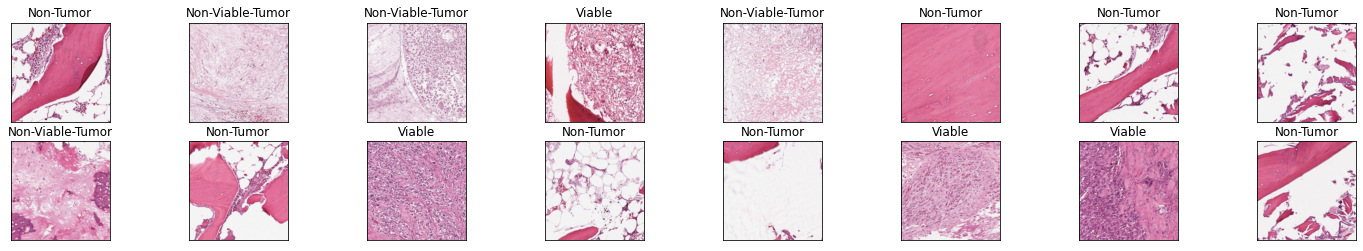

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converted Image to numpy

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Taking Pre-tained Densnet 121 model for feature extraction

In [ ]:
# Taking Densenet 121 model 
from torchvision import models
densenet_121 = models.densenet121(pretrained= True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn

# freexing layers to use pre-trained weights
model = models.densenet121(pretrained=True)
for param in model.parameters():
        param.requires_grad = False

# we will extract 1024 features from densnet pre trained model
model.classifier = nn.Linear(1024, 1024)

# demo
x = torch.rand(4, 3, 224, 224)
out = model.forward(x)
print(out.shape)

torch.Size([4, 1024])


# Making training and test features for ML algorithm

In [ ]:
# feature extraction for training images

x_train = []
y_train = []
model.eval()
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = model(data)
    x_train.append(output)

    if torch.cuda.is_available():
        target = torch.tensor(target, device= 'cpu')
    target = target.numpy()
    target = target.astype(int)
    y_train.append(target)

In [ ]:
# feature extraction for test images 

x_test = []
y_test = []
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = model(data)
    x_test.append(output)

    if torch.cuda.is_available():
        target = torch.tensor(target, device= 'cpu')

    target = target.numpy()
    target = target.astype(int)
    y_test.append(target)

In [ ]:
# As we are getting data from dataloader, so data are inserted as batch size
# that's why we need to convert this into 1D list 
from itertools import chain
x_train_features = list(chain.from_iterable(x_train))
x_test_features = list(chain.from_iterable(x_test))

print("Total training features: ", len(x_train_features))
print("Total test features: ", len(x_test_features))

Total training features:  916
Total test features:  228


In [ ]:
# converting labels into one dimensional list 
y_train = list(chain.from_iterable(y_train))
y_test = list(chain.from_iterable(y_test))

print("Total training labels: ", len(y_train))
print("Total test labels: ", len(y_test))

Total training labels:  916
Total test labels:  228


In [ ]:
for i in range(len(x_train_features)):
    # x_train_features[i] = x_train_features[i].numpy()
    if torch.cuda.is_available():
        x_train_features[i] = x_train_features[i].cpu().detach().numpy()   # if use GPU
  
    x_train_features[i] = x_train_features[i].detach().numpy()  

#converting list to numpy array
x_train_features = np.array(x_train_features)
print("Shape of training features: ",x_train_features.shape)

Shape of training features:  (916, 1024)


In [ ]:
for i in range(len(x_test_features)):
    # x_test_features[i] = x_test_features[i].numpy()
    if torch.cuda.is_available():
        x_test_features[i] = x_test_features[i].cpu().detach().numpy()

    x_test_features[i] = x_test_features[i].detach().numpy()

# converting list to numpy array
x_test_features = np.array(x_test_features)
print("Shape of test features: ",x_test_features.shape)

Shape of test features:  (228, 1024)


In [ ]:
#Convert label lists to arrays                
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Shape of training labels: ", y_train.shape)
print("Shape of test labels: ", y_test.shape)

Shape of training labels:  (916,)
Shape of test labels:  (228,)


### converting train features into CSV and save file to local machine

In [ ]:
import pandas as pd
# making a dataframe from the train features
t_labels = y_train.tolist()
df_train = pd.DataFrame(x_train_features)

# assigning labels into a new column
df_train.assign(labels= t_labels)
df_train.head()

0         1         2         3         4         5         6     \
0  0.346548 -0.078256 -0.697295 -0.093487 -0.682940  0.265473  0.470517   
1  0.085925  0.645651 -0.218978 -0.498305 -0.118714  0.157486  0.029360   
2  0.316375  0.617709 -0.381798 -0.515732  0.745896 -0.184708 -0.644307   
3  0.841414  0.294849 -0.093402 -0.652596  0.449027 -0.145580  0.016482   
4  0.497590  0.186927 -0.043757 -0.397813  0.441618 -0.035589 -0.176317   

       7         8         9     ...      1014      1015      1016      1017  \
0  0.885406  0.330339 -0.444395  ... -0.243440  0.057361 -0.275842  0.158298   
1  0.452892  0.131940 -0.571627  ... -0.330665 -0.005882  0.103631 -0.217199   
2 -0.025148  0.270348  0.227977  ... -1.422467 -0.702541 -0.208912  0.201068   
3  0.272818  0.219391 -0.004497  ... -0.264897 -0.072987 -0.410579 -0.212700   
4  0.546296  0.400335  0.174616  ... -0.725510 -0.039772 -0.036930 -0.183300   

       1018      1019      1020      1021      1022      1023  
0 -0.059462 -0.769957 -0.165915 -0.049850 -0.259743 -0.035301  
1 -0.125145 -0.620012 -0.444758  0.345002  0.201922  0.132300  
2 -0.721714 -0.051762 -0.280917  0.459863 -0.081743  0.565273  
3 -0.101899 -0.424244 -0.477472 -0.054563  0.034105 -0.043669  
4 -0.413861 -0.385908 -0.724044  0.195584  0.012614 -0.087922  

[5 rows x 1024 columns]

In [ ]:
# getting information about train features
df_train.describe()

0           1           2           3           4           5     \
count  916.000000  916.000000  916.000000  916.000000  916.000000  916.000000   
mean     0.359606    0.406582   -0.383369   -0.384490   -0.027791    0.244434   
std      0.303170    0.252997    0.273773    0.255535    0.376965    0.343253   
min     -0.453752   -0.503247   -1.380334   -1.162080   -1.316278   -0.896543   
25%      0.150750    0.245256   -0.552002   -0.555627   -0.268352    0.014638   
50%      0.380410    0.410175   -0.363505   -0.372926    0.001144    0.227984   
75%      0.567524    0.576956   -0.203232   -0.206037    0.258297    0.457264   
max      1.449992    1.118422    0.312390    0.422001    0.978063    1.546261   

             6           7           8           9     ...        1014  \
count  916.000000  916.000000  916.000000  916.000000  ...  916.000000   
mean    -0.035908    0.443137    0.261951   -0.238536  ...   -0.734768   
std      0.308024    0.288819    0.246620    0.351485  ...    0.321060   
min     -1.651483   -0.463010   -0.580588   -1.422474  ...   -1.765112   
25%     -0.216390    0.249937    0.111072   -0.489410  ...   -0.955258   
50%     -0.029946    0.428443    0.254582   -0.227346  ...   -0.717930   
75%      0.171633    0.629305    0.421914    0.044629  ...   -0.501873   
max      0.824510    1.517868    1.081857    0.609233  ...    0.084659   

             1015        1016        1017        1018        1019        1020  \
count  916.000000  916.000000  916.000000  916.000000  916.000000  916.000000   
mean    -0.062380   -0.060554   -0.112704   -0.131812   -0.332765   -0.392351   
std      0.261917    0.270561    0.236079    0.268702    0.314213    0.261380   
min     -0.870604   -1.120398   -0.882878   -0.921218   -1.401701   -1.149030   
25%     -0.243990   -0.238064   -0.261513   -0.312427   -0.548404   -0.561571   
50%     -0.078215   -0.062948   -0.119829   -0.141975   -0.301866   -0.402006   
75%      0.118049    0.117884    0.043718    0.024821   -0.104267   -0.231994   
max      0.828477    0.765984    0.875095    0.787498    0.529210    0.646833   

             1021        1022        1023  
count  916.000000  916.000000  916.000000  
mean     0.042225    0.151574    0.037073  
std      0.267866    0.276665    0.254132  
min     -0.941946   -0.745043   -0.756586  
25%     -0.131962   -0.035395   -0.125444  
50%      0.036441    0.131962    0.026805  
75%      0.221826    0.321223    0.203217  
max      0.914595    1.455987    0.762610  

[8 rows x 1024 columns]

In [ ]:
# saving csv to local machine
df_train.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/train_information.csv', index=False)

### converting test features into CSV and save to local machine

In [ ]:
# making a dataframe from the train features
df_test = pd.DataFrame(x_test_features)
df_test = df_test.assign(labels= y_test)
df_test.head()

0         1         2         3         4         5         6  \
0  0.281744  0.418026 -0.014159 -0.099534  0.369130 -0.195914  0.094328   
1  0.495417  0.535078 -0.336168 -0.500757  0.649774  0.012718  0.268865   
2  0.204016  0.465168 -0.066356 -0.561008  0.282004  0.353160 -0.266353   
3  0.510035  0.258165 -0.289984 -0.174095 -0.075995 -0.088292 -0.158673   
4  0.689707  0.265720 -0.700918 -0.407370 -0.811670  1.168657 -0.035256   

          7         8         9  ...      1015      1016      1017      1018  \
0  0.289904  0.309968  0.126544  ... -0.019519 -0.091772  0.003070  0.066842   
1  0.474080  0.652879  0.189803  ... -0.247910  0.092971 -0.365918 -0.568190   
2  0.074931  0.380856 -0.050992  ...  0.103439 -0.279206 -0.488683 -0.188490   
3  0.145305  0.088462  0.173718  ...  0.047717 -0.078377 -0.137403 -0.104987   
4  0.784826  0.064221 -0.509205  ... -0.044020  0.081976  0.307454  0.509271   

       1019      1020      1021      1022      1023  labels  
0  0.033391 -0.547672 -0.055621  0.201363  0.068743       1  
1 -0.377668 -0.539601  0.412045  0.166450 -0.071871       2  
2  0.078071 -0.515714  0.141255  0.161023  0.035463       0  
3 -0.377568 -0.156521 -0.154767  0.253181  0.200711       2  
4 -0.711480 -0.782232 -0.490685  0.736642 -0.593326       2  

[5 rows x 1025 columns]

In [ ]:
# getting information about train features
df_test.describe()

0           1           2           3           4           5  \
count  228.000000  228.000000  228.000000  228.000000  228.000000  228.000000   
mean     0.356812    0.403195   -0.376508   -0.413764   -0.038639    0.277622   
std      0.316869    0.260728    0.305094    0.241785    0.395261    0.342323   
min     -0.579705   -0.410645   -1.317157   -1.117092   -1.184210   -0.630128   
25%      0.144077    0.239864   -0.603418   -0.562781   -0.343008    0.077075   
50%      0.361554    0.409218   -0.353782   -0.415451   -0.022692    0.269005   
75%      0.604308    0.566041   -0.120793   -0.253298    0.250194    0.466242   
max      1.041104    1.202271    0.329112    0.164269    0.952298    1.678680   

                6           7           8           9  ...        1015  \
count  228.000000  228.000000  228.000000  228.000000  ...  228.000000   
mean    -0.056712    0.449660    0.262512   -0.250480  ...   -0.044023   
std      0.319673    0.310169    0.256032    0.374819  ...    0.273628   
min     -1.232693   -0.390174   -0.795946   -1.404879  ...   -0.987709   
25%     -0.258061    0.246795    0.104874   -0.505017  ...   -0.218891   
50%     -0.026126    0.416946    0.258599   -0.191008  ...   -0.063691   
75%      0.156989    0.644464    0.408509    0.051718  ...    0.105740   
max      0.616834    1.273781    1.043605    0.442516  ...    0.747410   

             1016        1017        1018        1019        1020        1021  \
count  228.000000  228.000000  228.000000  228.000000  228.000000  228.000000   
mean    -0.066961   -0.111865   -0.132359   -0.350724   -0.412760    0.036939   
std      0.278482    0.226670    0.278804    0.329445    0.256178    0.270876   
min     -0.843060   -0.654855   -0.925497   -1.211367   -1.009675   -0.723095   
25%     -0.249951   -0.267288   -0.323617   -0.590776   -0.606470   -0.148183   
50%     -0.049716   -0.124096   -0.126571   -0.326789   -0.433940    0.024718   
75%      0.131586    0.025596    0.044463   -0.126984   -0.228884    0.225921   
max      0.653311    0.538251    1.035815    0.512842    0.409154    0.819637   

             1022        1023      labels  
count  228.000000  228.000000  228.000000  
mean     0.168079    0.026475    0.846491  
std      0.261420    0.268545    0.879595  
min     -0.648898   -0.686568    0.000000  
25%     -0.000599   -0.156508    0.000000  
50%      0.149867    0.044801    1.000000  
75%      0.324420    0.208467    2.000000  
max      1.072769    0.759498    2.000000  

[8 rows x 1025 columns]

In [ ]:
# saving dataframe to local machine
df_test.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/test_information.csv', index=False)

# Feature Scaling

In [ ]:
# Scaling train and test features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(x_train_features)
X_test = sc.transform(x_test_features)

print("After scaling train: ", X_train.shape)
print("After scaling test size: ", X_test.shape)

After scaling train:  (916, 1024)
After scaling test size:  (228, 1024)


# Multi-class Classification without feature selection

In [ ]:
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(x_train_features, y_train)

# predicting through test data
mlp_pred = mlp_classifier.predict(x_test_features)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

Accuracy =  0.934
ROC-AUC score is:  0.985


**K-fold Validation and feature scaling**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(x_train_features, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, x_train_features, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(x_test_features)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

k-fold validation accuracy for k=5 is:  0.907
Accuracy on test data is:  0.934
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.893


**Matthews correlation coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.915


**confusion matrix**

In [ ]:
# Function to plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize= False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
        title = "Normalized Confusion Matrix"
    else:
        # print('Confusion matrix, without normalization')
        title = "Confusion Matrix"

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

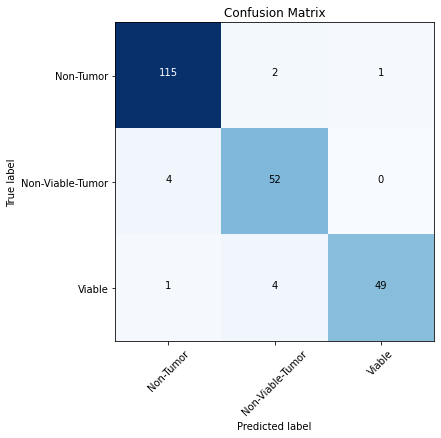

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, mlp_pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

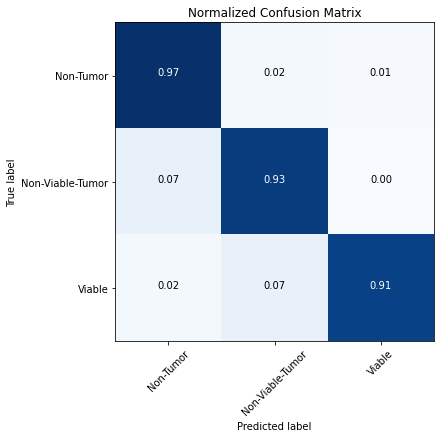

In [ ]:
# plotting confusion matrix with normalization
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.90      0.93      0.91        56
           2       0.98      0.91      0.94        54

    accuracy                           0.95       228
   macro avg       0.94      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228



**calculating precision, recall(sensitivity), specificity by formula**

In [ ]:
# function to measure TP, FP, TN, FN

def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, mlp_pred)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.943      	   0.953   
  1   Non-Viable-Tumor     0.897     	      0.897      	   0.965   
  2        Viable           0.98      	      0.817      	   0.994   


# Multi-class Classification with feautre selection

## Visualize helper functions

In [ ]:
def get_cls_reports(y_test, mlp_pred):
  print(classification_report(y_test, mlp_pred))

def get_sns_spc(y_test, mlp_pred):
  c, tp, fp, tn, fn = perf_measure(y_test, mlp_pred)

  # for class 0
  tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

  # precision= TP/(TP + FP)
  precision_0 = tp_0 /(tp_0 + fp_0)
  precision_0 = np.round(precision_0, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_0 = tp_0 / (tp_0 + fn_0)
  recall_0 = np.round(recall_0, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_0 = tn_0 / (tn_0 + fp_0)
  speci_0 = np.round(speci_0, 3)

  #### for class 1
  tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

  # precision= TP/(TP + FP)
  precision_1 = tp_1 /(tp_1 + fp_1)
  precision_1 = np.round(precision_1, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_1 = tp_1 / (tp_1 + fn_1)
  recall_1 = np.round(recall_1, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_1 = tn_1 / (tn_1 + fp_1)
  speci_1 = np.round(speci_1, 3)

  ### for class 2
  tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

  # precision= TP/(TP + FP)
  precision_2 = tp_2 /(tp_2 + fp_2)
  precision_2 = np.round(precision_2, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_2 = tp_2 / (tp_2 + fn_2)
  recall_2 = np.round(recall_2, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_2 = tn_2 / (tn_2 + fp_2)
  speci_2 = np.round(speci_2, 3)

  c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
  print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
  print('--------------------------------------------------------------------------')
  print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
  print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
  print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))


# function to plot confusion matrix
def get_conf_matrix(classes, y_test, mlp_pred):
  # getting confusion matrix
  conf_matrix = confusion_matrix(y_test, mlp_pred)

  # plotting confusion matrix
  plt.figure(figsize=(6,6))
  plot_confusion_matrix(conf_matrix, classes, normalize= False)
  plt.show()

  # plotting confusion matrix with normalization
  plt.figure(figsize=(6,6))
  plot_confusion_matrix(conf_matrix, classes, normalize= True)
  plt.show()


## Principle Component Analysis (PCA)

**Applying PCA**

Text(0, 0.5, 'Cum variance')

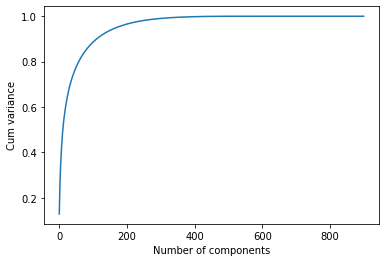

In [ ]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components= 900)  # n_components must be between: min(n_samples, n_features)
pca_test.fit(X_train)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

### PCA 100

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(n_components= 100)  # taking 100 PCA components 

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 100)
After applying PCA, shape for test data:  (228, 100)
k-fold validation accuracy for k=5 is:  0.916
Accuracy on test data is:  0.943
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       118
           1       0.92      0.88      0.90        56
           2       0.91      0.93      0.92        54

    accuracy                           0.94       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.967     	      0.928      	   0.961   
  1   Non-Viable-Tumor     0.925     	      0.845      	   0.976   
  2        Viable          0.909      	      0.862      	   0.971   


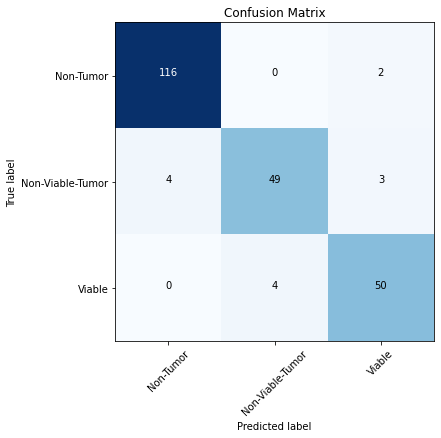

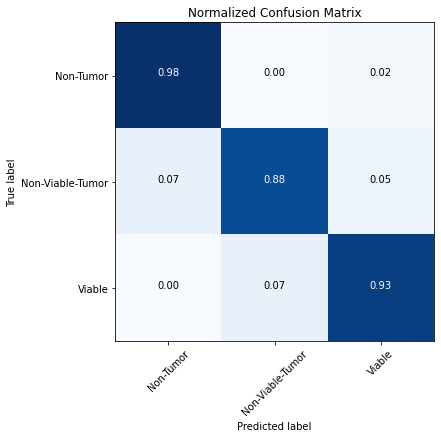

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

### PCA 200

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(n_components= 200)  # taking 200 PCA components 

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 200)
After applying PCA, shape for test data:  (228, 200)
k-fold validation accuracy for k=5 is:  0.905
Accuracy on test data is:  0.934
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.893


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.91      0.88      0.89        56
           2       0.92      0.91      0.92        54

    accuracy                           0.93       228
   macro avg       0.93      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.95     	      0.927      	   0.942   
  1   Non-Viable-Tumor     0.907     	      0.831      	    0.97   
  2        Viable          0.925      	      0.817      	   0.976   


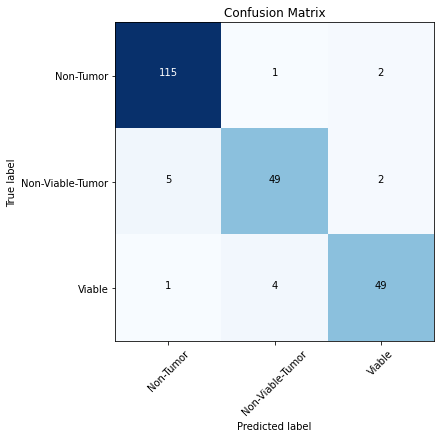

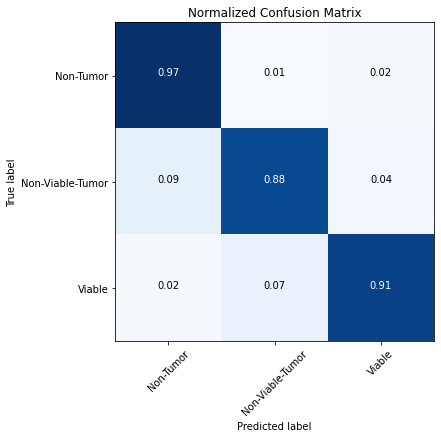

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

### PCA 300

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(n_components= 300)  # taking 300 PCA components 

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 300)
After applying PCA, shape for test data:  (228, 300)
k-fold validation accuracy for k=5 is:  0.914
Accuracy on test data is:  0.93
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.886


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       118
           1       0.92      0.88      0.90        56
           2       0.91      0.89      0.90        54

    accuracy                           0.93       228
   macro avg       0.92      0.91      0.92       228
weighted avg       0.93      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.943     	      0.927      	   0.933   
  1   Non-Viable-Tumor     0.925     	      0.803      	   0.976   
  2        Viable          0.906      	      0.814      	    0.97   


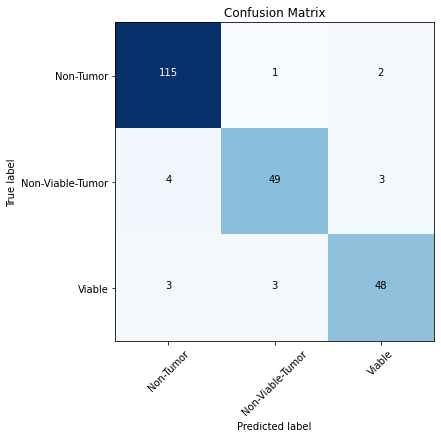

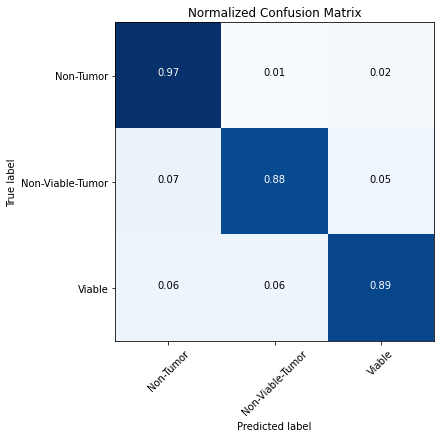

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

### PCA 400

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(n_components= 400)  # taking 400 PCA components 

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 400)
After applying PCA, shape for test data:  (228, 400)
k-fold validation accuracy for k=5 is:  0.894
Accuracy on test data is:  0.917
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.865


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       118
           1       0.87      0.86      0.86        56
           2       0.89      0.91      0.90        54

    accuracy                           0.92       228
   macro avg       0.90      0.90      0.90       228
weighted avg       0.92      0.92      0.92       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.949     	      0.896      	   0.942   
  1   Non-Viable-Tumor     0.873     	       0.8       	   0.958   
  2        Viable          0.891      	       0.79      	   0.964   


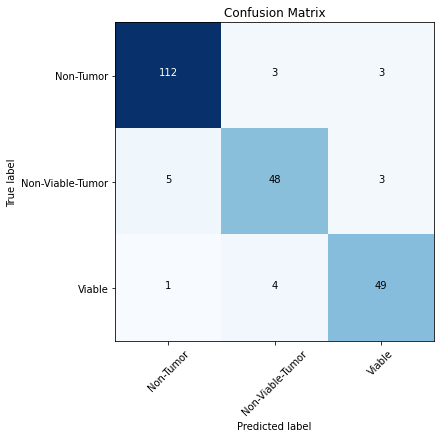

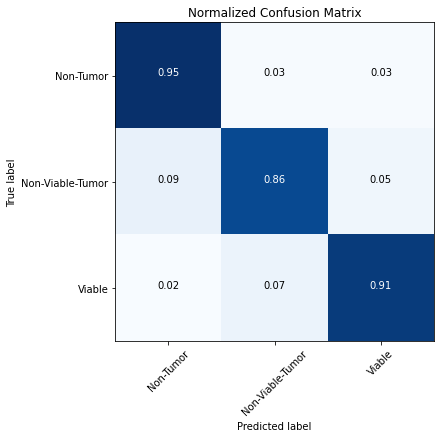

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

### PCA 500

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(n_components= 500)  # taking 500 PCA components 

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 500)
After applying PCA, shape for test data:  (228, 500)
k-fold validation accuracy for k=5 is:  0.896
Accuracy on test data is:  0.925
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.879


              precision    recall  f1-score   support

           0       0.96      0.95      0.95       118
           1       0.88      0.88      0.88        56
           2       0.91      0.93      0.92        54

    accuracy                           0.93       228
   macro avg       0.91      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.957     	      0.903      	   0.952   
  1   Non-Viable-Tumor     0.875     	      0.831      	   0.959   
  2        Viable          0.909      	      0.806      	    0.97   


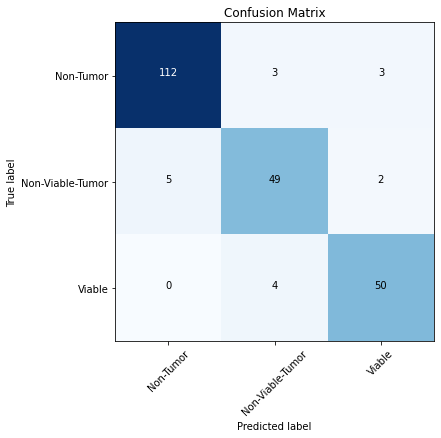

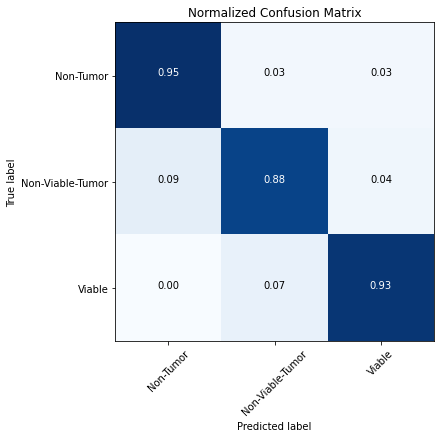

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

### PCA 600

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(n_components= 600)  # taking 600 PCA components 

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 600)
After applying PCA, shape for test data:  (228, 600)
k-fold validation accuracy for k=5 is:  0.912
Accuracy on test data is:  0.93
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.886


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       118
           1       0.88      0.88      0.88        56
           2       0.94      0.93      0.93        54

    accuracy                           0.93       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.95     	      0.919      	   0.943   
  1   Non-Viable-Tumor     0.875     	      0.845      	   0.959   
  2        Viable          0.943      	      0.794      	   0.982   


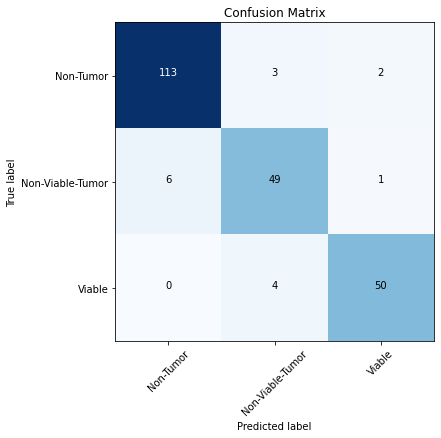

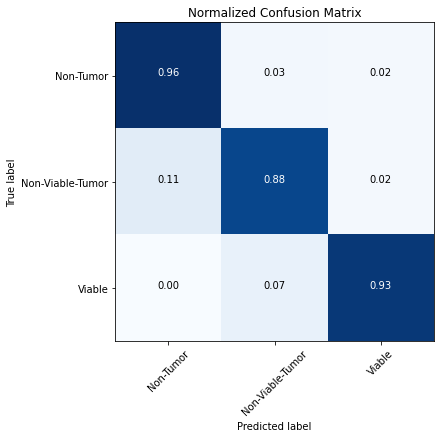

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

### PCA 700

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(n_components= 700)  # taking 700 PCA components 

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 700)
After applying PCA, shape for test data:  (228, 700)
k-fold validation accuracy for k=5 is:  0.909
Accuracy on test data is:  0.93
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.886


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       118
           1       0.88      0.89      0.88        56
           2       0.94      0.91      0.92        54

    accuracy                           0.93       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.95     	      0.919      	   0.943   
  1   Non-Viable-Tumor     0.877     	      0.847      	   0.959   
  2        Viable          0.942      	       0.79      	   0.982   


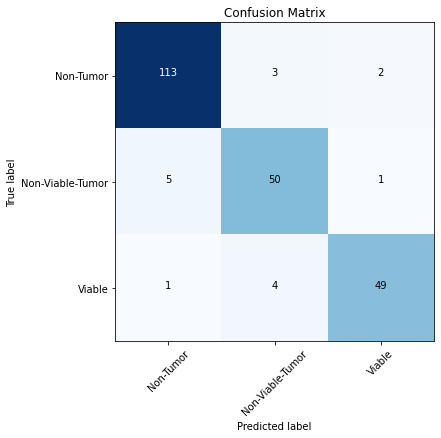

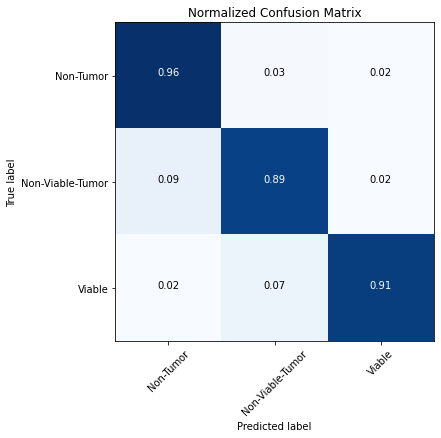

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

### PCA 800

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(n_components= 800)  # taking 800 PCA components 

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 800)
After applying PCA, shape for test data:  (228, 800)
k-fold validation accuracy for k=5 is:  0.908
Accuracy on test data is:  0.939
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.9


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.91      0.89      0.90        56
           2       0.92      0.91      0.92        54

    accuracy                           0.94       228
   macro avg       0.93      0.92      0.93       228
weighted avg       0.94      0.94      0.94       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.927      	   0.952   
  1   Non-Viable-Tumor     0.909     	      0.847      	    0.97   
  2        Viable          0.925      	      0.831      	   0.976   


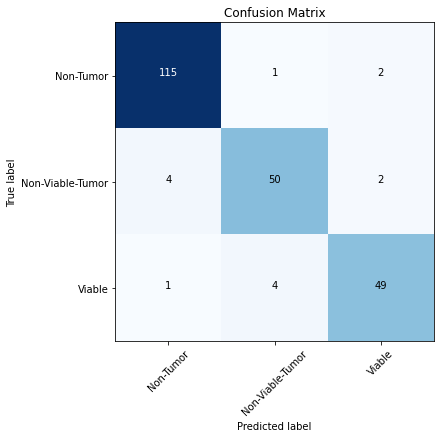

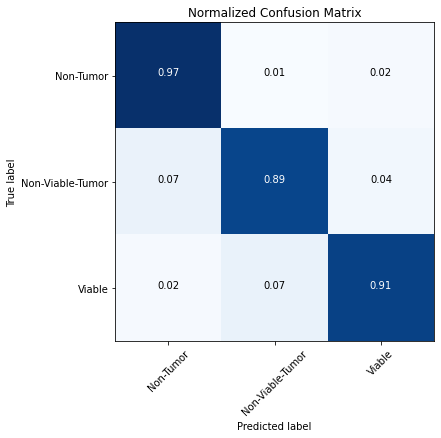

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

### PCA 900

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(n_components= 900)  # taking 900 PCA components 

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 900)
After applying PCA, shape for test data:  (228, 900)
k-fold validation accuracy for k=5 is:  0.916
Accuracy on test data is:  0.93
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.886


              precision    recall  f1-score   support

           0       0.96      0.95      0.95       118
           1       0.88      0.91      0.89        56
           2       0.92      0.91      0.92        54

    accuracy                           0.93       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.957     	      0.911      	   0.952   
  1   Non-Viable-Tumor     0.879     	       0.85      	   0.958   
  2        Viable          0.925      	      0.803      	   0.976   


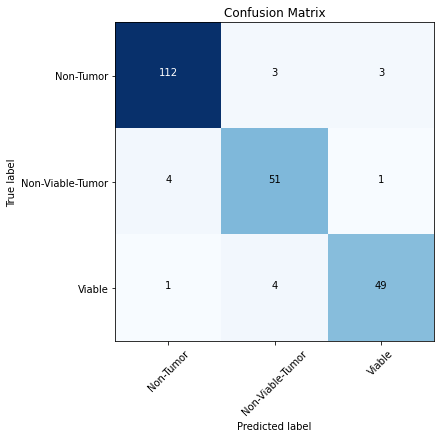

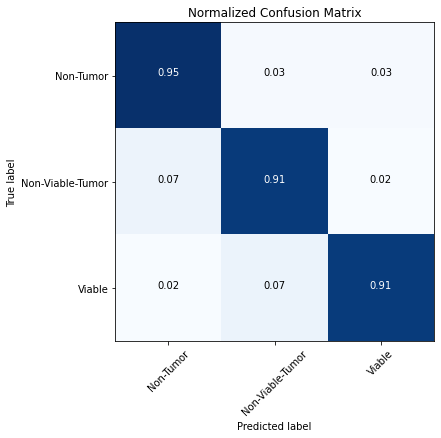

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

#### PCA 0.9

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(0.9)   # we want to capture 90% information by covariance

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 112)
After applying PCA, shape for test data:  (228, 112)
k-fold validation accuracy for k=5 is:  0.913
Accuracy on test data is:  0.93
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.886


              precision    recall  f1-score   support

           0       0.96      0.95      0.95       118
           1       0.89      0.91      0.90        56
           2       0.91      0.91      0.91        54

    accuracy                           0.93       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.957     	      0.911      	   0.952   
  1   Non-Viable-Tumor     0.895     	      0.836      	   0.964   
  2        Viable          0.907      	      0.817      	    0.97   


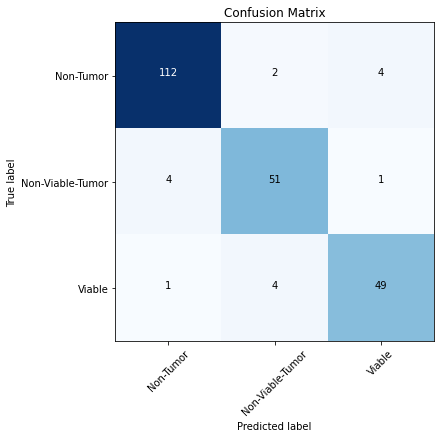

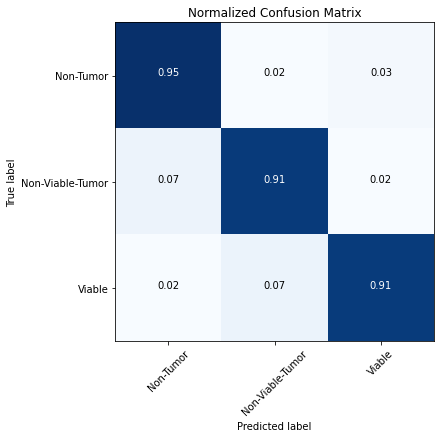

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

#### PCA 0.8

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(0.8)   # we want to capture 80% information by covariance

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 59)
After applying PCA, shape for test data:  (228, 59)
k-fold validation accuracy for k=5 is:  0.901
Accuracy on test data is:  0.917
ROC-AUC score is:  0.98
The Matthews correlation coefficinet (MCC) is:  0.865


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       118
           1       0.84      0.88      0.86        56
           2       0.94      0.91      0.92        54

    accuracy                           0.92       228
   macro avg       0.91      0.91      0.91       228
weighted avg       0.92      0.92      0.92       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.941     	      0.902      	   0.933   
  1   Non-Viable-Tumor     0.845     	      0.831      	   0.947   
  2        Viable          0.942      	      0.754      	   0.982   


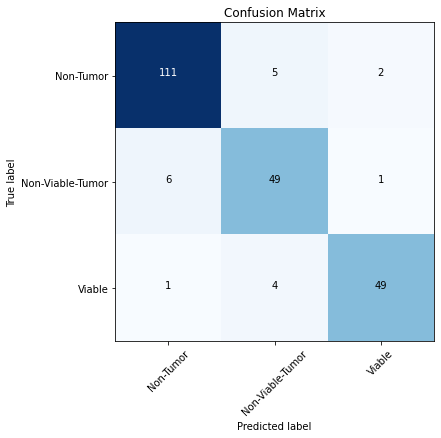

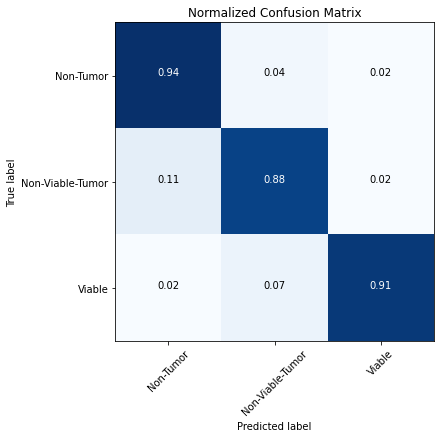

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

#### PCA 0.85

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(0.85)   # we want to capture 85% information by covariance

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 80)
After applying PCA, shape for test data:  (228, 80)
k-fold validation accuracy for k=5 is:  0.912
Accuracy on test data is:  0.921
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.872


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       118
           1       0.88      0.89      0.88        56
           2       0.92      0.89      0.91        54

    accuracy                           0.92       228
   macro avg       0.91      0.91      0.91       228
weighted avg       0.92      0.92      0.92       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.941     	      0.911      	   0.933   
  1   Non-Viable-Tumor     0.877     	       0.82      	   0.958   
  2        Viable          0.923      	      0.774      	   0.976   


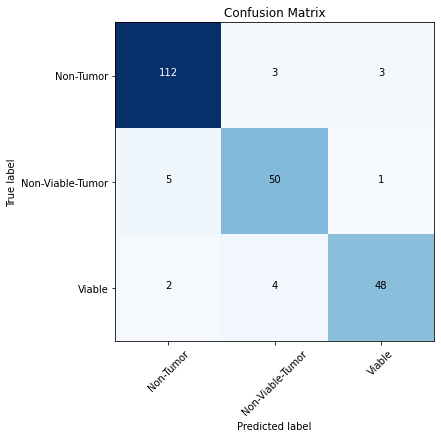

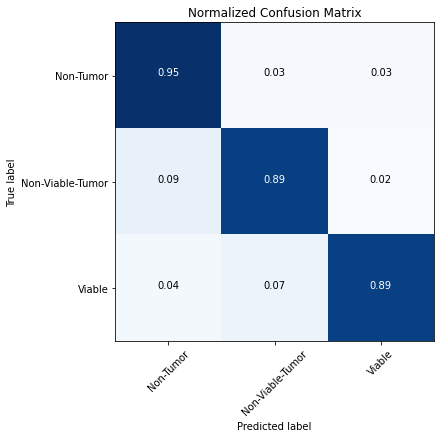

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

#### PCA 0.95

In [ ]:
from sklearn.decomposition import PCA
# defining PCA 
pca = PCA(0.95)   # we want to capture 95% information by covariance

# fit to PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("After applying PCA, shape for train data: ", X_train_pca.shape)
print("After applying PCA, shape for test data: ", X_test_pca.shape)

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_pca, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)

#Print overall accuracy on test data
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test_pca), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying PCA, shape for train data:  (916, 170)
After applying PCA, shape for test data:  (228, 170)
k-fold validation accuracy for k=5 is:  0.898
Accuracy on test data is:  0.943
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.908


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.88      0.91      0.89        56
           2       0.96      0.93      0.94        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.966     	      0.927      	   0.962   
  1   Non-Viable-Tumor     0.879     	      0.895      	   0.959   
  2        Viable          0.962      	       0.82      	   0.988   


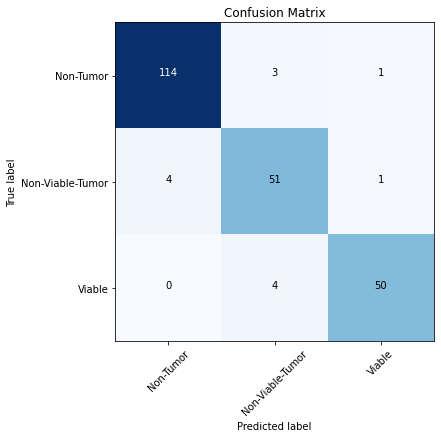

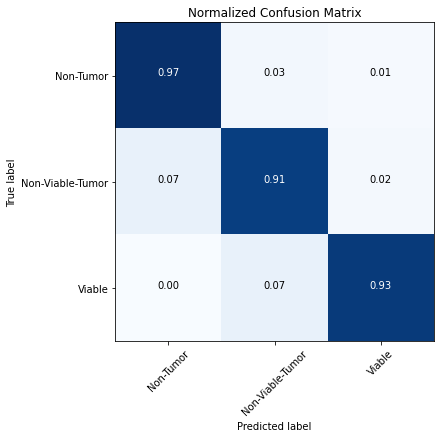

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_pred)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_pred)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_pred)

## Mutual Information Gain (MIG)

**Applying MIG**

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

### MIG 100

In [ ]:
# selecting best features
select = SelectKBest(mutual_info_classif, k=100)

# fit to selector
X_train_ig = select.fit_transform(X_train, y_train)
X_test_ig = select.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_ig.fit(X_train_ig, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy for test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_ig.predict_proba(X_test_ig), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)
k-fold validation accuracy for k=5 is:  0.912
Accuracy for test data is:  0.925
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.878


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       118
           1       0.91      0.88      0.89        56
           2       0.91      0.89      0.90        54

    accuracy                           0.93       228
   macro avg       0.92      0.91      0.91       228
weighted avg       0.92      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.942     	      0.919      	   0.933   
  1   Non-Viable-Tumor     0.907     	      0.803      	    0.97   
  2        Viable          0.906      	       0.8       	    0.97   


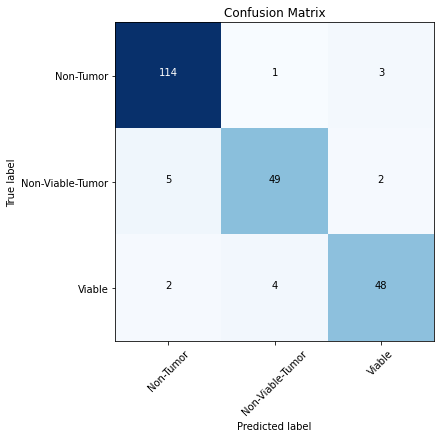

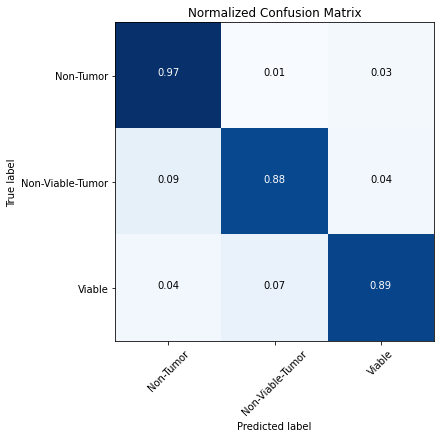

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### MIG 200

In [ ]:
# selecting best features
select = SelectKBest(mutual_info_classif, k=200)

# fit to selector
X_train_ig = select.fit_transform(X_train, y_train)
X_test_ig = select.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_ig.fit(X_train_ig, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy for test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_ig.predict_proba(X_test_ig), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)
k-fold validation accuracy for k=5 is:  0.915
Accuracy for test data is:  0.934
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.893


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       118
           1       0.88      0.91      0.89        56
           2       0.94      0.91      0.92        54

    accuracy                           0.93       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.93      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.919      	   0.952   
  1   Non-Viable-Tumor     0.879     	      0.864      	   0.959   
  2        Viable          0.942      	      0.803      	   0.982   


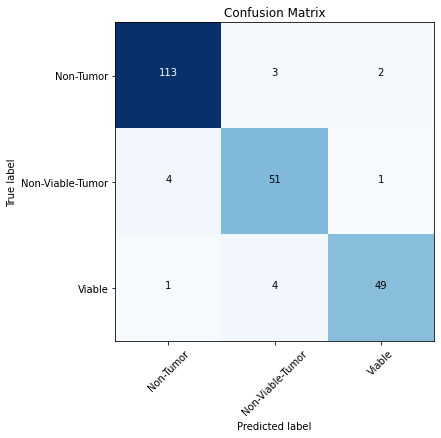

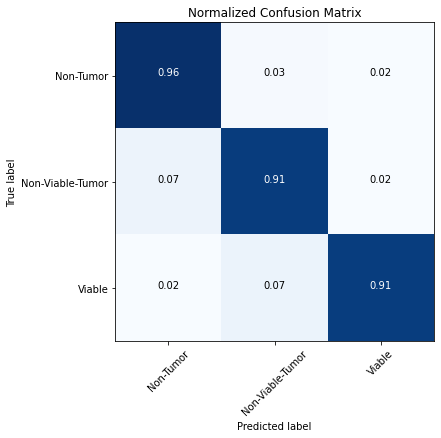

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### MIG 300

In [ ]:
# selecting best features
select = SelectKBest(mutual_info_classif, k=300)

# fit to selector
X_train_ig = select.fit_transform(X_train, y_train)
X_test_ig = select.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_ig.fit(X_train_ig, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy for test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_ig.predict_proba(X_test_ig), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)
k-fold validation accuracy for k=5 is:  0.917
Accuracy for test data is:  0.93
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.886


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       118
           1       0.88      0.93      0.90        56
           2       0.96      0.87      0.91        54

    accuracy                           0.93       228
   macro avg       0.93      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.942     	      0.926      	   0.934   
  1   Non-Viable-Tumor     0.881     	      0.852      	   0.958   
  2        Viable          0.959      	       0.77      	   0.988   


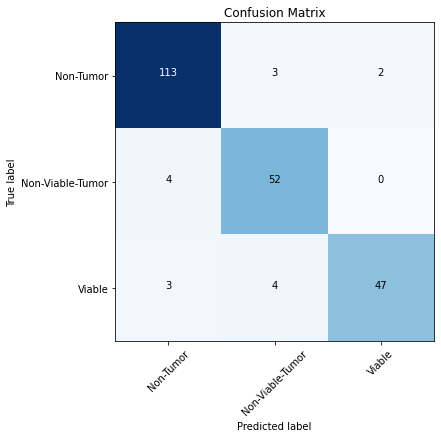

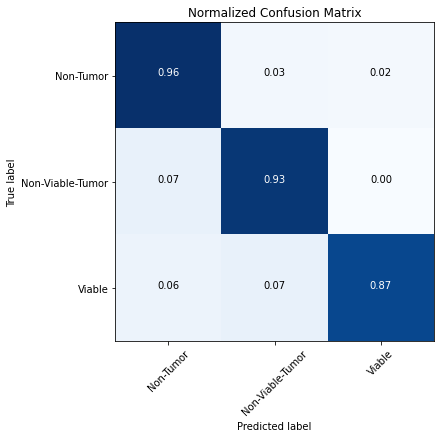

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### MIG 400

In [ ]:
# selecting best features
select = SelectKBest(mutual_info_classif, k=400)

# fit to selector
X_train_ig = select.fit_transform(X_train, y_train)
X_test_ig = select.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_ig.fit(X_train_ig, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy for test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_ig.predict_proba(X_test_ig), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)
k-fold validation accuracy for k=5 is:  0.928
Accuracy for test data is:  0.943
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.908


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.88      0.93      0.90        56
           2       0.98      0.91      0.94        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.94       228
weighted avg       0.94      0.94      0.94       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.934      	   0.953   
  1   Non-Viable-Tumor     0.881     	      0.897      	   0.959   
  2        Viable           0.98      	      0.803      	   0.994   


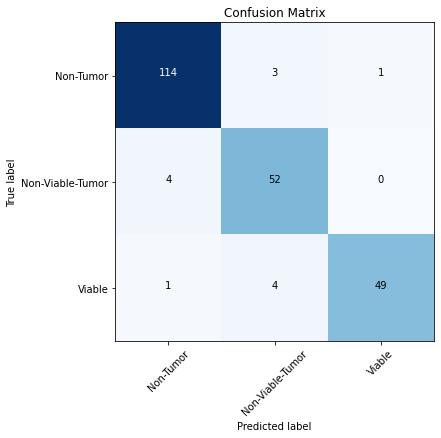

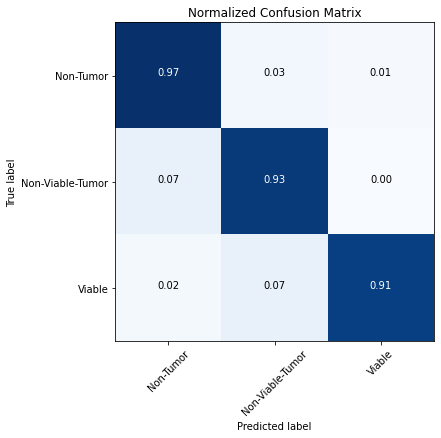

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### MIG 500

In [ ]:
# selecting best features
select = SelectKBest(mutual_info_classif, k=500)

# fit to selector
X_train_ig = select.fit_transform(X_train, y_train)
X_test_ig = select.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_ig.fit(X_train_ig, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy for test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_ig.predict_proba(X_test_ig), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)
k-fold validation accuracy for k=5 is:  0.914
Accuracy for test data is:  0.939
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.9


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.88      0.93      0.90        56
           2       0.98      0.91      0.94        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.94       228
weighted avg       0.94      0.94      0.94       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.934      	   0.953   
  1   Non-Viable-Tumor     0.881     	      0.897      	   0.959   
  2        Viable           0.98      	      0.803      	   0.994   


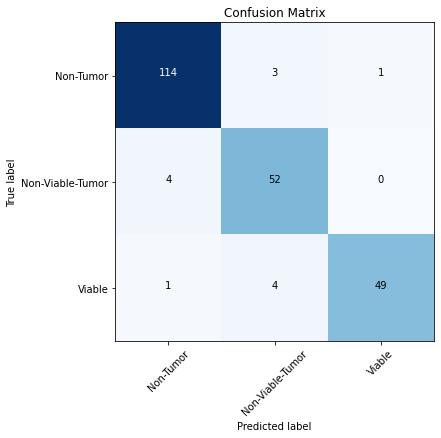

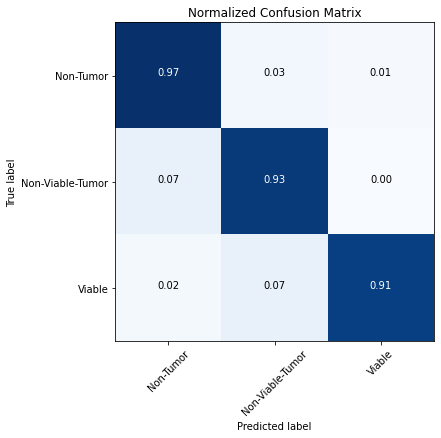

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### MIG 600

In [ ]:
# selecting best features
select = SelectKBest(mutual_info_classif, k=600)

# fit to selector
X_train_ig = select.fit_transform(X_train, y_train)
X_test_ig = select.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_ig.fit(X_train_ig, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy for test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_ig.predict_proba(X_test_ig), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)
k-fold validation accuracy for k=5 is:  0.919
Accuracy for test data is:  0.943
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.91      0.89      0.90        56
           2       0.96      0.93      0.94        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.94       228
weighted avg       0.94      0.94      0.94       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.95     	      0.943      	   0.943   
  1   Non-Viable-Tumor     0.909     	      0.862      	   0.971   
  2        Viable          0.962      	       0.82      	   0.988   


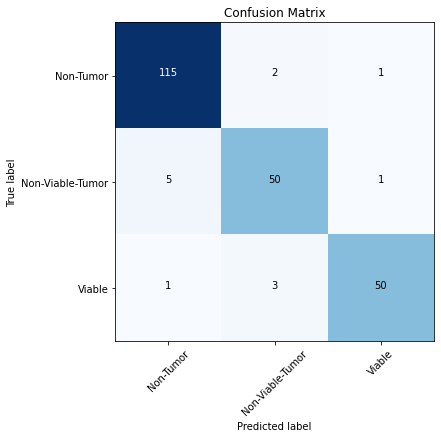

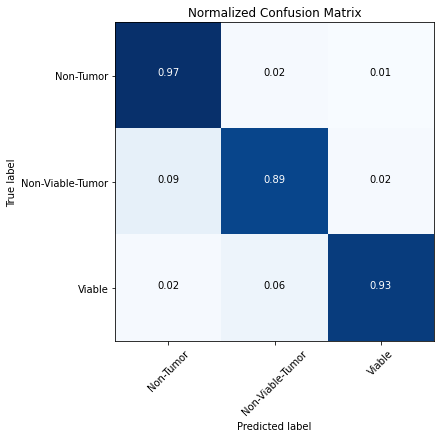

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### MIG 700

In [ ]:
# selecting best features
select = SelectKBest(mutual_info_classif, k=700)

# fit to selector
X_train_ig = select.fit_transform(X_train, y_train)
X_test_ig = select.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_ig.fit(X_train_ig, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy for test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_ig.predict_proba(X_test_ig), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)
k-fold validation accuracy for k=5 is:  0.918
Accuracy for test data is:  0.943
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.91      0.89      0.90        56
           2       0.94      0.93      0.93        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.935      	   0.952   
  1   Non-Viable-Tumor     0.909     	      0.862      	   0.971   
  2        Viable          0.943      	      0.833      	   0.982   


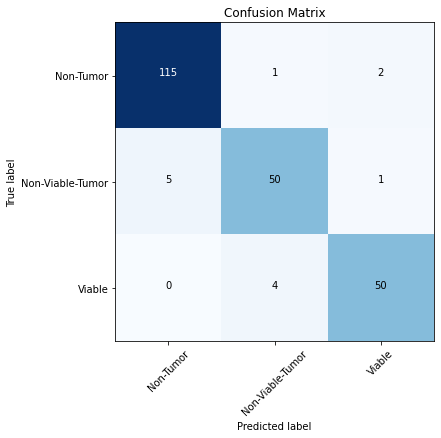

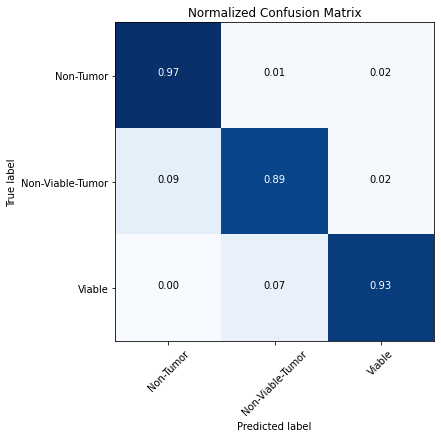

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### MIG 800

In [ ]:
# selecting best features
select = SelectKBest(mutual_info_classif, k=800)

# fit to selector
X_train_ig = select.fit_transform(X_train, y_train)
X_test_ig = select.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_ig.fit(X_train_ig, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy for test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_ig.predict_proba(X_test_ig), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)
k-fold validation accuracy for k=5 is:  0.922
Accuracy for test data is:  0.943
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.89      0.91      0.90        56
           2       0.96      0.91      0.93        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.935      	   0.952   
  1   Non-Viable-Tumor     0.895     	      0.879      	   0.965   
  2        Viable          0.961      	      0.817      	   0.988   


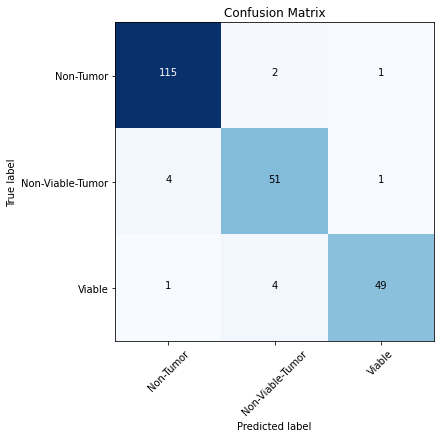

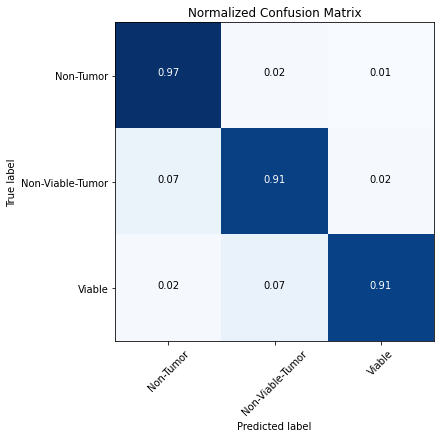

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### MIG 900

In [ ]:
# selecting best features
select = SelectKBest(mutual_info_classif, k=900)

# fit to selector
X_train_ig = select.fit_transform(X_train, y_train)
X_test_ig = select.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_ig.fit(X_train_ig, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy for test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_ig.predict_proba(X_test_ig), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)
k-fold validation accuracy for k=5 is:  0.919
Accuracy for test data is:  0.939
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.9


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       118
           1       0.89      0.89      0.89        56
           2       0.98      0.91      0.94        54

    accuracy                           0.94       228
   macro avg       0.94      0.92      0.93       228
weighted avg       0.94      0.94      0.94       228

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.943     	      0.943      	   0.934   
  1   Non-Viable-Tumor     0.893     	      0.862      	   0.965   
  2        Viable           0.98      	       0.79      	   0.994   


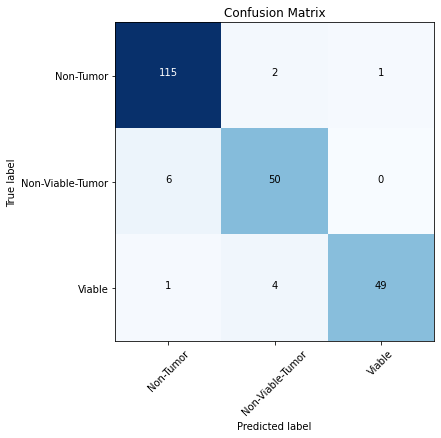

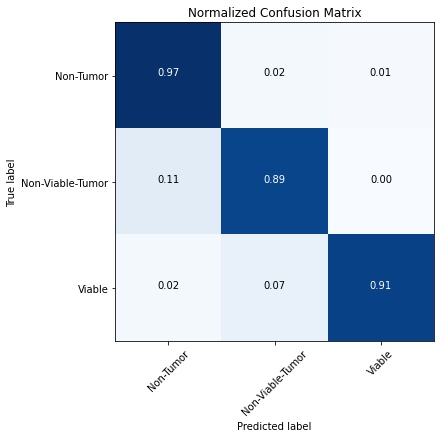

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)

# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)

# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

## Recursive Feature Elimination (RFE)

**APplying RFE**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

### RFE 100

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=100)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)
k-fold validation accuracy for k=5 is:  0.912
Accuracy on test data is:  0.934
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.893


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.92      0.88      0.90        56
           2       0.91      0.91      0.91        54

    accuracy                           0.93       228
   macro avg       0.93      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.95     	      0.927      	   0.942   
  1   Non-Viable-Tumor     0.925     	      0.817      	   0.976   
  2        Viable          0.907      	      0.831      	    0.97   





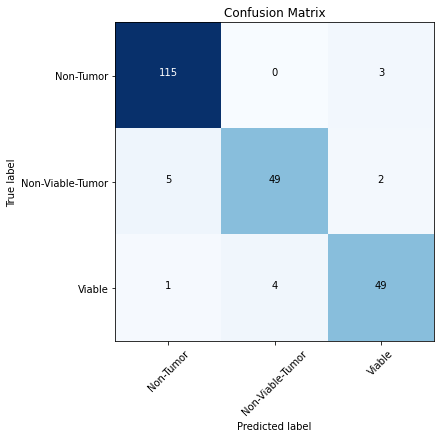

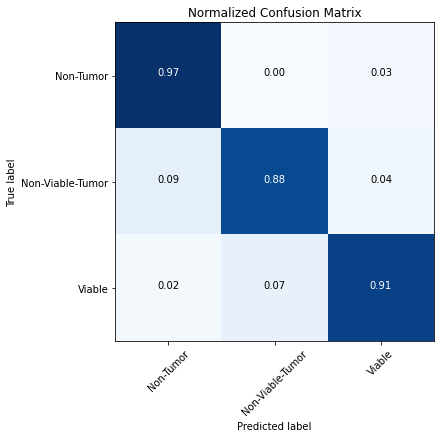

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### RFE 200

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=200)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)
k-fold validation accuracy for k=5 is:  0.914
Accuracy on test data is:  0.934
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.893


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       118
           1       0.91      0.91      0.91        56
           2       0.89      0.91      0.90        54

    accuracy                           0.93       228
   macro avg       0.92      0.93      0.92       228
weighted avg       0.93      0.93      0.93       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.966     	      0.911      	   0.962   
  1   Non-Viable-Tumor     0.911     	      0.836      	    0.97   
  2        Viable          0.891      	      0.845      	   0.965   





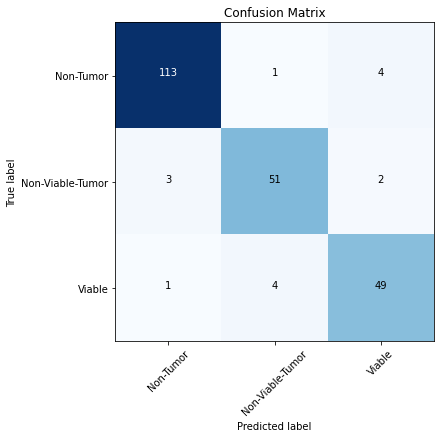

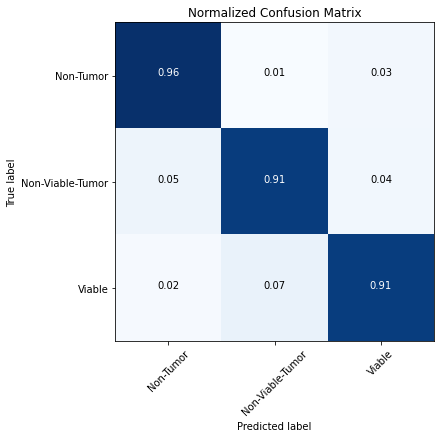

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### RFE 300

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=300)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)
k-fold validation accuracy for k=5 is:  0.92
Accuracy on test data is:  0.943
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.91      0.89      0.90        56
           2       0.96      0.93      0.94        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.94       228
weighted avg       0.94      0.94      0.94       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.95     	      0.943      	   0.943   
  1   Non-Viable-Tumor     0.909     	      0.862      	   0.971   
  2        Viable          0.962      	       0.82      	   0.988   





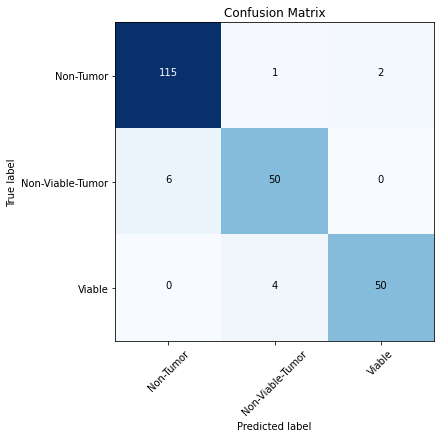

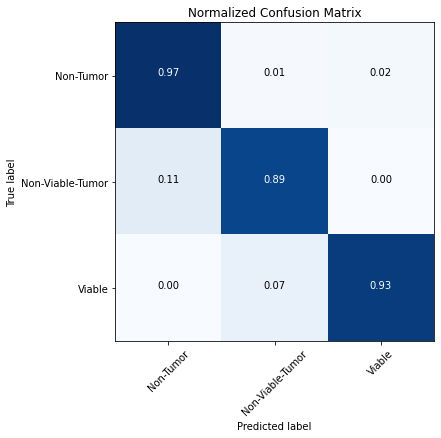

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### RFE 400

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=400)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)
k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.947
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.914


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       118
           1       0.91      0.89      0.90        56
           2       0.94      0.93      0.93        54

    accuracy                           0.95       228
   macro avg       0.94      0.93      0.94       228
weighted avg       0.95      0.95      0.95       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.967     	      0.935      	   0.962   
  1   Non-Viable-Tumor     0.909     	      0.877      	   0.971   
  2        Viable          0.943      	      0.847      	   0.982   





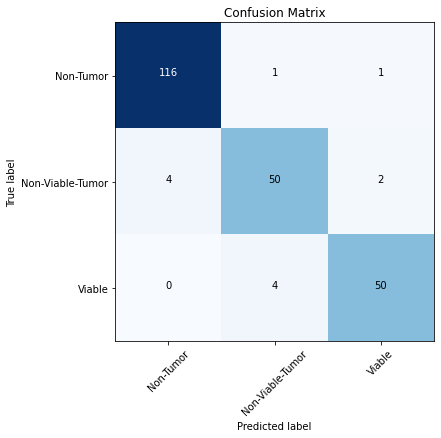

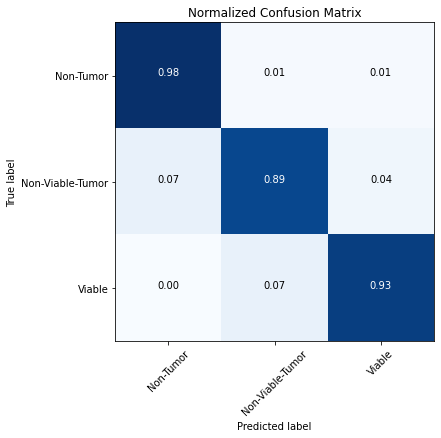

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### RFE 500

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=500)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)
k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.947
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.914


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.89      0.91      0.90        56
           2       0.98      0.93      0.95        54

    accuracy                           0.95       228
   macro avg       0.94      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.943      	   0.953   
  1   Non-Viable-Tumor     0.895     	      0.895      	   0.965   
  2        Viable           0.98      	       0.82      	   0.994   





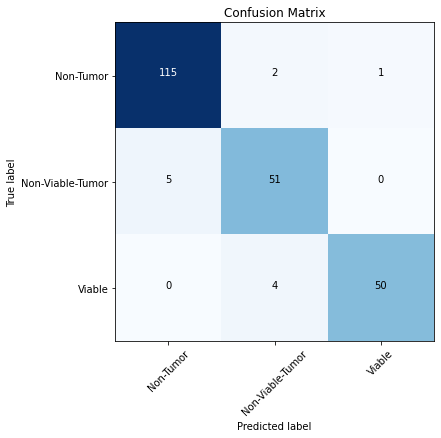

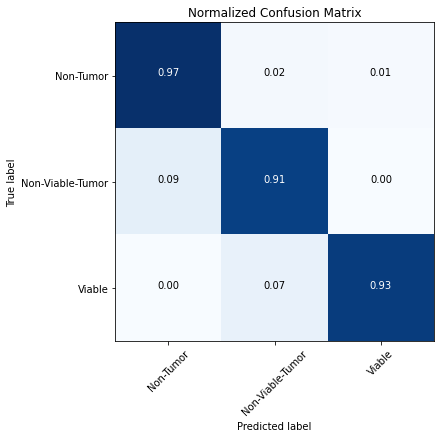

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### RFE 600

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=600)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)
k-fold validation accuracy for k=5 is:  0.922
Accuracy on test data is:  0.943
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.89      0.89      0.89        56
           2       0.96      0.93      0.94        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.935      	   0.952   
  1   Non-Viable-Tumor     0.893     	      0.877      	   0.965   
  2        Viable          0.962      	       0.82      	   0.988   





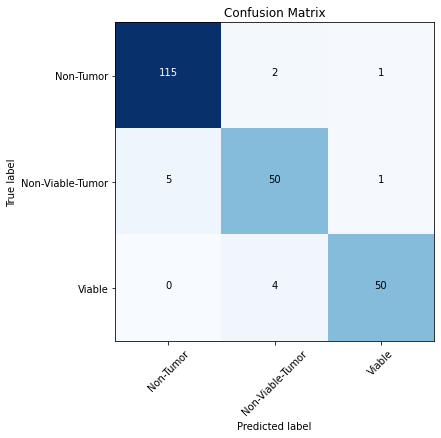

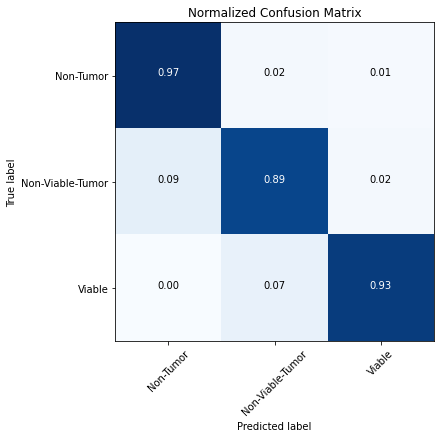

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### RFE 700

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=700)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.939
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.9


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.89      0.89      0.89        56
           2       0.96      0.91      0.93        54

    accuracy                           0.94       228
   macro avg       0.93      0.92      0.93       228
weighted avg       0.94      0.94      0.94       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.95     	      0.935      	   0.943   
  1   Non-Viable-Tumor     0.893     	      0.862      	   0.965   
  2        Viable          0.961      	      0.803      	   0.988   





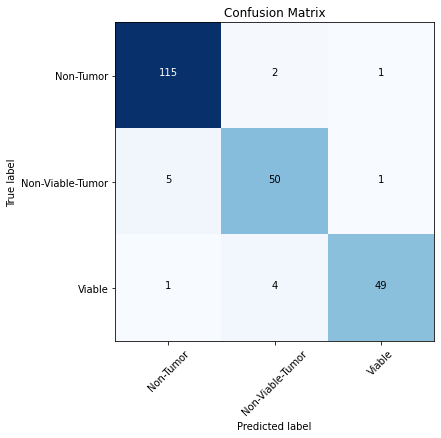

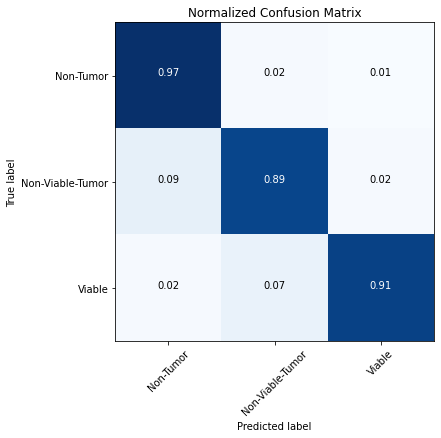

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### RFE 800

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=800)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)
k-fold validation accuracy for k=5 is:  0.918
Accuracy on test data is:  0.947
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.915


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.90      0.93      0.91        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       228
   macro avg       0.94      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.966     	      0.934      	   0.962   
  1   Non-Viable-Tumor     0.897     	      0.897      	   0.965   
  2        Viable          0.962      	      0.833      	   0.988   





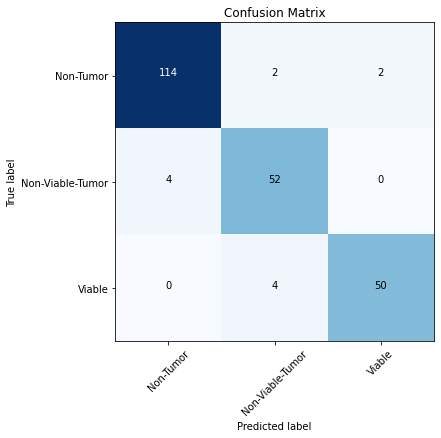

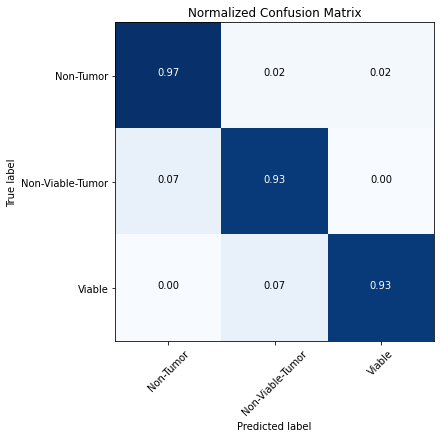

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### RFE 900

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=900)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)
k-fold validation accuracy for k=5 is:  0.913
Accuracy on test data is:  0.952
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.922


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.90      0.93      0.91        56
           2       0.98      0.93      0.95        54

    accuracy                           0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.966     	      0.943      	   0.962   
  1   Non-Viable-Tumor     0.897     	      0.912      	   0.965   
  2        Viable           0.98      	      0.833      	   0.994   





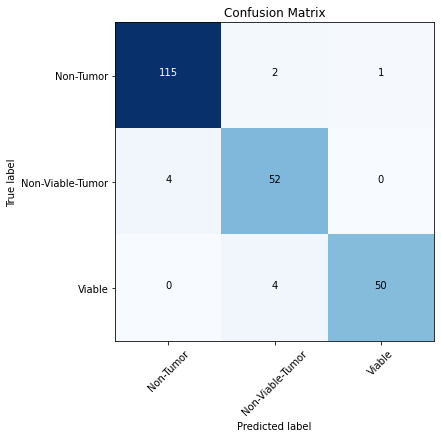

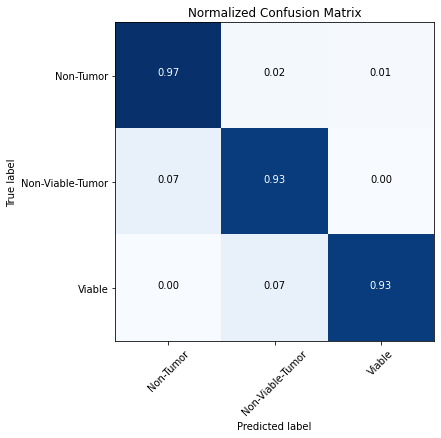

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

## Univariate

**Applying TBA**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=100)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)
k-fold validation accuracy for k=5 is:  0.908
Accuracy on test data is:  0.917
ROC-AUC score is:  0.981
The Matthews correlation coefficinet (MCC) is:  0.864


### 100

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=100)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)
k-fold validation accuracy for k=5 is:  0.908
Accuracy on test data is:  0.917
ROC-AUC score is:  0.981
The Matthews correlation coefficinet (MCC) is:  0.864


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       118
           1       0.88      0.88      0.88        56
           2       0.89      0.87      0.88        54

    accuracy                           0.92       228
   macro avg       0.90      0.90      0.90       228
weighted avg       0.92      0.92      0.92       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.95     	      0.897      	   0.941   
  1   Non-Viable-Tumor     0.875     	      0.803      	   0.958   
  2        Viable          0.887      	      0.783      	   0.964   





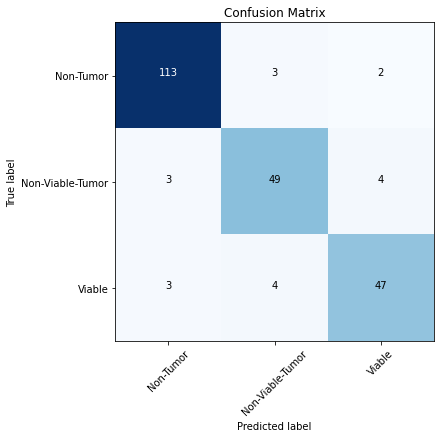

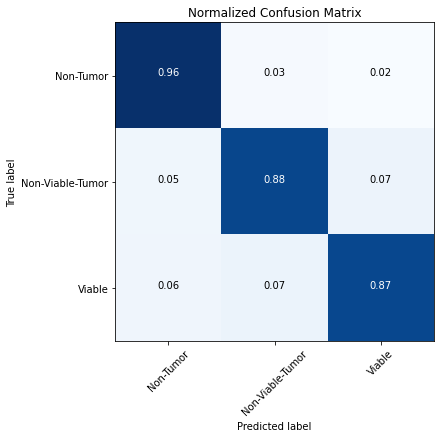

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### 200

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=200)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)
k-fold validation accuracy for k=5 is:  0.905
Accuracy on test data is:  0.943
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.89      0.91      0.90        56
           2       0.96      0.93      0.94        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.94       228
weighted avg       0.94      0.94      0.94       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.934      	   0.953   
  1   Non-Viable-Tumor     0.895     	      0.879      	   0.965   
  2        Viable          0.962      	       0.82      	   0.988   





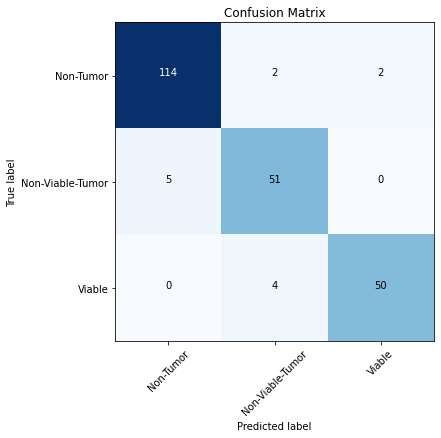

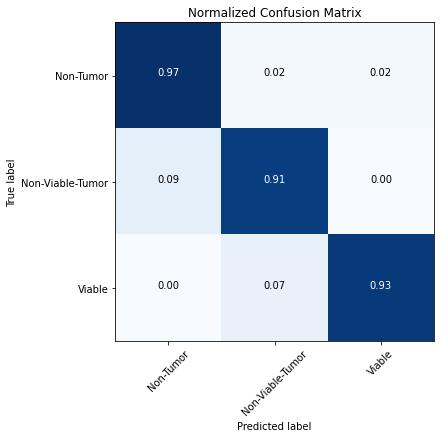

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### 300

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=300)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)
k-fold validation accuracy for k=5 is:  0.918
Accuracy on test data is:  0.939
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.901


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       118
           1       0.88      0.93      0.90        56
           2       0.94      0.91      0.92        54

    accuracy                           0.94       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.966     	      0.919      	   0.962   
  1   Non-Viable-Tumor     0.881     	      0.881      	   0.959   
  2        Viable          0.942      	      0.817      	   0.982   





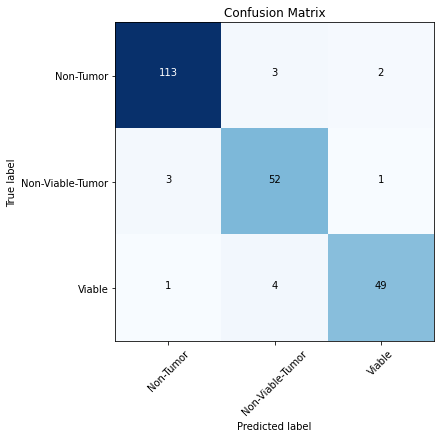

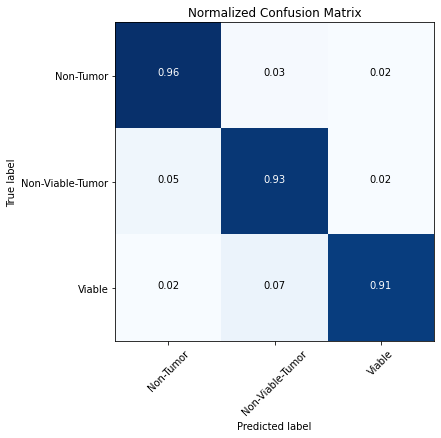

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### 400

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=400)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)
k-fold validation accuracy for k=5 is:  0.916
Accuracy on test data is:  0.934
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.893


              precision    recall  f1-score   support

           0       0.93      0.97      0.95       118
           1       0.89      0.89      0.89        56
           2       0.98      0.89      0.93        54

    accuracy                           0.93       228
   macro avg       0.94      0.92      0.93       228
weighted avg       0.94      0.93      0.93       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.935     	      0.943      	   0.925   
  1   Non-Viable-Tumor     0.893     	      0.847      	   0.964   
  2        Viable           0.98      	      0.774      	   0.994   





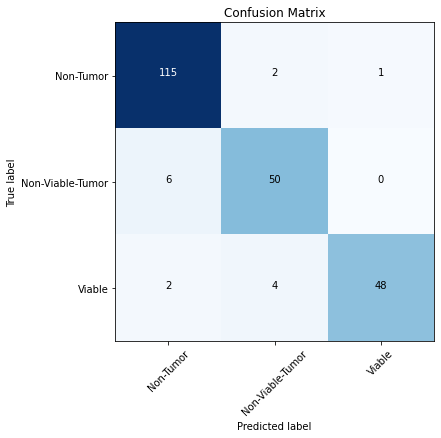

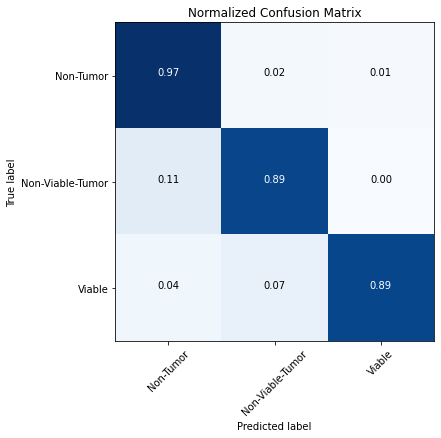

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### 500

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=500)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)
k-fold validation accuracy for k=5 is:  0.918
Accuracy on test data is:  0.947
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.915


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.90      0.93      0.91        56
           2       0.98      0.91      0.94        54

    accuracy                           0.95       228
   macro avg       0.94      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.943      	   0.953   
  1   Non-Viable-Tumor     0.897     	      0.897      	   0.965   
  2        Viable           0.98      	      0.817      	   0.994   





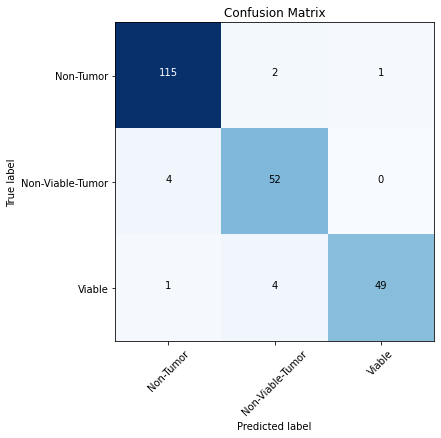

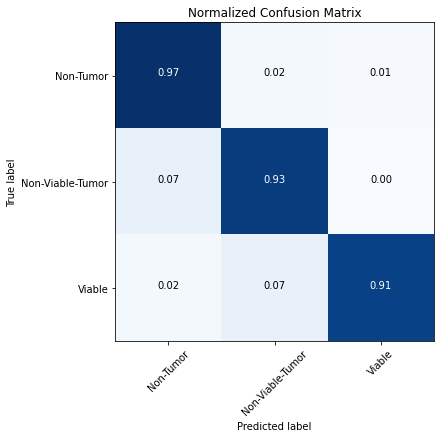

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### 600

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=600)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)
k-fold validation accuracy for k=5 is:  0.914
Accuracy on test data is:  0.93
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.886


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       118
           1       0.88      0.91      0.89        56
           2       0.94      0.91      0.92        54

    accuracy                           0.93       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.949     	      0.918      	   0.943   
  1   Non-Viable-Tumor     0.879     	       0.85      	   0.958   
  2        Viable          0.942      	       0.79      	   0.982   





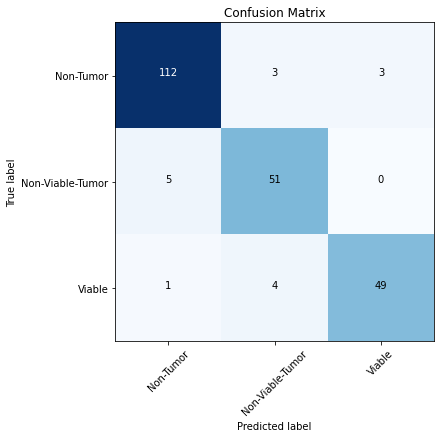

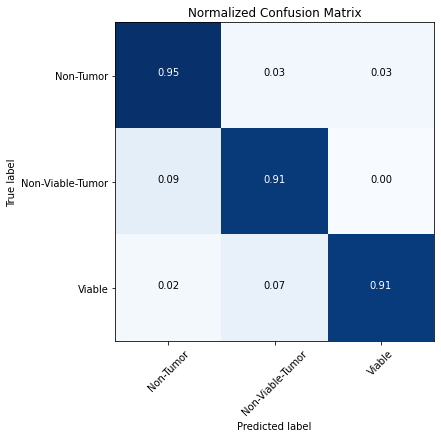

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### 700

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=700)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)
k-fold validation accuracy for k=5 is:  0.919
Accuracy on test data is:  0.952
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.922


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.88      0.93      0.90        56
           2       1.00      0.93      0.96        54

    accuracy                           0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.966     	      0.943      	   0.962   
  1   Non-Viable-Tumor     0.881     	      0.929      	   0.959   
  2        Viable           1.0       	       0.82      	    1.0    





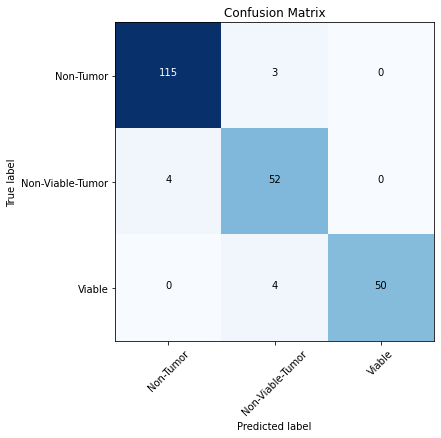

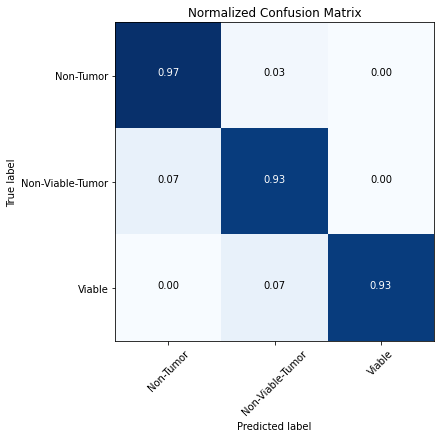

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### 800

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=800)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)
k-fold validation accuracy for k=5 is:  0.913
Accuracy on test data is:  0.952
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       118
           1       0.91      0.91      0.91        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       228
   macro avg       0.95      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.967     	      0.943      	   0.962   
  1   Non-Viable-Tumor     0.911     	      0.895      	   0.971   
  2        Viable          0.962      	      0.847      	   0.988   





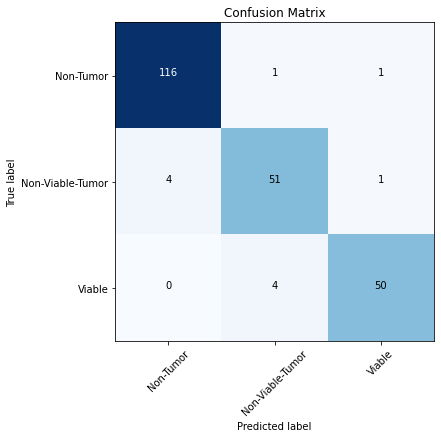

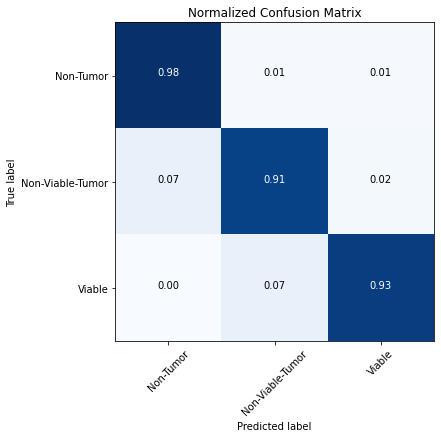

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

### 900

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=900)
selector.fit(X_train, y_train)

# getting transformed train features
X_train_uv = selector.transform(X_train)

# getting transformed test features
X_test_uv = selector.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_uv.predict_proba(X_test_uv), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)
k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.943
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.89      0.89      0.89        56
           2       0.96      0.93      0.94        54

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228




class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.958     	      0.935      	   0.952   
  1   Non-Viable-Tumor     0.893     	      0.877      	   0.965   
  2        Viable          0.962      	       0.82      	   0.988   





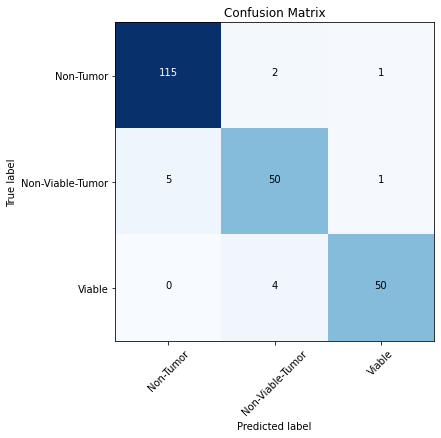

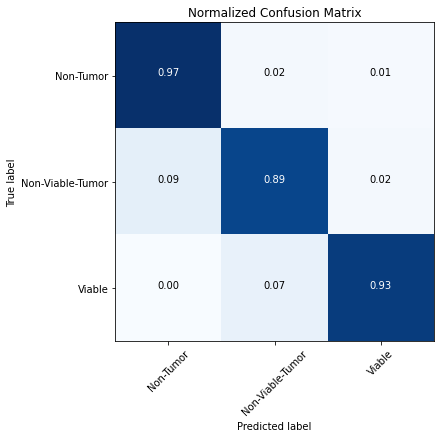

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

# getting classsification reports
get_cls_reports(y_test, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sns_spc(y_test, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
get_conf_matrix(classes, y_test, mlp_p)

# Separating features and labels for every class

**separting train data**

In [ ]:
# separating data for train set 

non_tumor_train = []
non_tumor_train_l = []

non_viable_tumor_train = []
non_viable_tumor_train_l = []

viable_tumor_train = []
viable_tumor_train_l  = []

for i in range(len(x_train_features)):
    if(y_train[i] == 0):
        non_tumor_train.append(x_train_features[i])
        non_tumor_train_l.append(y_train[i])
        
    elif(y_train[i] == 1):
        non_viable_tumor_train.append(x_train_features[i])
        non_viable_tumor_train_l.append(y_train[i])
    else: 
        viable_tumor_train.append(x_train_features[i])
        viable_tumor_train_l.append(y_train[i])
        
# converting list to np array
non_tumor_train = np.array(non_tumor_train)
non_tumor_train_l = np.array(non_tumor_train_l)

non_viable_tumor_train = np.array(non_viable_tumor_train)
non_viable_tumor_train_l = np.array(non_viable_tumor_train_l)

viable_tumor_train = np.array(viable_tumor_train)
viable_tumor_train_l = np.array(viable_tumor_train_l)

print("Non-tumor train shape: ", non_tumor_train.shape)
print("Non-tumor train labels shape: ",non_tumor_train_l.shape)
print("Non-viable tumor train shape: ", non_viable_tumor_train.shape)
print("Non-viable tumor train labels shape: ", non_viable_tumor_train_l.shape)
print("Viable tumor train shape: ", viable_tumor_train.shape)
print("Viable tumor train labels shape: ", viable_tumor_train_l.shape)

Non-tumor train shape:  (419, 1024)
Non-tumor train labels shape:  (419,)
Non-viable tumor train shape:  (206, 1024)
Non-viable tumor train labels shape:  (206,)
Viable tumor train shape:  (291, 1024)
Viable tumor train labels shape:  (291,)


**separating test data**

In [ ]:
# separating data for test set 

non_tumor_test = []
non_tumor_test_l = []

non_viable_tumor_test = []
non_viable_tumor_test_l = []

viable_tumor_test = []
viable_tumor_test_l  = []

for i in range(len(x_test_features)):
    if(y_test[i] == 0):
        non_tumor_test.append(x_test_features[i])
        non_tumor_test_l.append(y_test[i])
        
    elif(y_test[i] == 1):
        non_viable_tumor_test.append(x_test_features[i])
        non_viable_tumor_test_l.append(y_test[i])
    else: 
        viable_tumor_test.append(x_test_features[i])
        viable_tumor_test_l.append(y_test[i])
        
# converting list to np array
non_tumor_test = np.array(non_tumor_test)
non_tumor_test_l = np.array(non_tumor_test_l)

non_viable_tumor_test = np.array(non_viable_tumor_test)
non_viable_tumor_test_l = np.array(non_viable_tumor_test_l)

viable_tumor_test = np.array(viable_tumor_test)
viable_tumor_test_l = np.array(viable_tumor_test_l)

print("Non-tumor test shape: ", non_tumor_test.shape)
print("Non-tumor test labels shape: ",non_tumor_test_l.shape)
print("Non-viable tumor test shape: ", non_viable_tumor_test.shape)
print("Non-viable tumor test labels shape: ", non_viable_tumor_test_l.shape)
print("Viable tumor test shape: ", viable_tumor_test.shape)
print("Viable tumor test labels shape: ", viable_tumor_test_l.shape)

Non-tumor test shape:  (118, 1024)
Non-tumor test labels shape:  (118,)
Non-viable tumor test shape:  (56, 1024)
Non-viable tumor test labels shape:  (56,)
Viable tumor test shape:  (54, 1024)
Viable tumor test labels shape:  (54,)


# Binary Classificataion without feature selection

### Helper function to visualize data

In [ ]:
# function get classification reports 
def get_reports(y_test, mlp_pred):
  print(classification_report(y_test, mlp_pred))

# function to get confuaion matrix
def conf_mat(classes, y_test, mlp_pred):
  # getting confusion matrix
  conf_matrix = confusion_matrix(y_test, mlp_pred)

  # plotting confusion matrix
  plt.figure(figsize=(6,6))
  plot_confusion_matrix(conf_matrix, classes, normalize= False)
  plt.show()

  # plotting confusion matrix with normalization
  plt.figure(figsize=(6,6))
  plot_confusion_matrix(conf_matrix, classes, normalize= True)
  plt.show()

# function to get sensitivity and specificty
def get_sn_sp(test_y, mlp_pred):
  cc, tp, fp, tn, fn = perf_measure(test_y, mlp_pred)

  # for class 0
  tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

  # precision= TP/(TP + FP)
  precision_0 = tp_0 /(tp_0 + fp_0)
  precision_0 = np.round(precision_0, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_0 = tp_0 / (tp_0 + fn_0)
  recall_0 = np.round(recall_0, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_0 = tn_0 / (tn_0 + fp_0)
  speci_0 = np.round(speci_0, 3)

  #### for class 1
  tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

  # precision= TP/(TP + FP)
  precision_1 = tp_1 /(tp_1 + fp_1)
  precision_1 = np.round(precision_1, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_1 = tp_1 / (tp_1 + fn_1)
  recall_1 = np.round(recall_1, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_1 = tn_1 / (tn_1 + fp_1)
  speci_1 = np.round(speci_1, 3)


  c_0, c_1 = 'Non-Tumor', 'Non-Viable-Tumor and Viable', 
  print("class \tprecision \tsensitivity(recall) \tspecificity ")
  print('------------------------------------------------------------------------------')
  print(str(0).center(5),  str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
  print(str(1).center(5),  str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))


## Non- tumor VS non-viable and viable

In [ ]:
# making Non-tumor VS non-viable and viable dataset
print("Label for non-tumor: ",np.unique(non_tumor_train_l))
print(np.unique(non_viable_tumor_train_l))
print(np.unique(viable_tumor_train_l))

# We need to concatenate vible and non-viable as a single class for training data
viable_n_non_viable_train = np.concatenate((non_viable_tumor_train, viable_tumor_train), axis=0)
print("Shape of no-viable and viable train features after concatenate: ", viable_n_non_viable_train.shape)

# concatenate for test data
viable_n_non_viable_test = np.concatenate((non_viable_tumor_test, viable_tumor_test), axis=0)
print("Shape of no-viable and viable train features after concatenate: ", viable_n_non_viable_test.shape)

# concatenating labels for training data 
viable_n_non_viable_train_l = np.concatenate((non_viable_tumor_train_l, viable_tumor_train_l), axis=0)

# concatenating labels for test data 
viable_n_non_viable_test_l = np.concatenate((non_viable_tumor_test_l, viable_tumor_test_l), axis=0)

print("Shape of no-viable and viable train features labels after concatenate: ", viable_n_non_viable_train_l.shape)

print("Label for non-viable and viable features: ",np.unique(viable_n_non_viable_train_l))
print("Label for non-viable and viable features: ",np.unique(viable_n_non_viable_test_l))

Label for non-tumor:  [0]
[1]
[2]
Shape of no-viable and viable train features after concatenate:  (497, 1024)
Shape of no-viable and viable train features after concatenate:  (110, 1024)
Shape of no-viable and viable train features labels after concatenate:  (497,)
Label for non-viable and viable features:  [1 2]
Label for non-viable and viable features:  [1 2]


In [ ]:
# AS we can see above, non-viable and viable contains two different labels  1, 2 respectively. 
# We need to convert those into label 1, as we are going to implement binary classification 

for i in range(viable_n_non_viable_train_l.shape[0]):
    viable_n_non_viable_train_l[i] = 1

for i in range(viable_n_non_viable_test_l.shape[0]):
    viable_n_non_viable_test_l[i] = 1

print('After conversion: ',np.unique(viable_n_non_viable_test_l))
print('After conversion: ',np.unique(viable_n_non_viable_train_l))

After conversion:  [1]
After conversion:  [1]


In [ ]:
# combinig dataset for train set 
train_x_b1 = np.concatenate((non_tumor_train, viable_n_non_viable_train), axis=0)
train_y_b1 = np.concatenate((non_tumor_train_l, viable_n_non_viable_train_l), axis= 0)
print('Training features shape: ',train_x_b1.shape)
print('Training labels shape: ',train_y_b1.shape)
print("Lables in train data: ", np.unique(train_y_b1))
print("=============================================================")

# combining for test data 
test_x_b1 = np.concatenate((non_tumor_test, viable_n_non_viable_test), axis=0)
test_y_b1 = np.concatenate((non_tumor_test_l, viable_n_non_viable_test_l), axis= 0)
print('Training features shape: ',test_x_b1.shape)
print('Training labels shape: ',test_y_b1.shape)
print("Lables in train data: ", np.unique(test_y_b1))

Training features shape:  (916, 1024)
Training labels shape:  (916,)
Lables in train data:  [0 1]
Training features shape:  (228, 1024)
Training labels shape:  (228,)
Lables in train data:  [0 1]


In [ ]:
# performing binary classification without feature scaling 
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(train_x_b1, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, train_x_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(test_x_b1)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(test_x_b1)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

k-fold validation accuracy for k=5 is:  0.921
Accuracy =  0.943
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.886


In [ ]:
# Scaling train and test features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_b1 = sc.fit_transform(train_x_b1)
X_test_b1 = sc.transform(test_x_b1)

print("After scaling train: ", X_train_b1.shape)
print("After scaling test size: ", X_test_b1.shape)

After scaling train:  (916, 1024)
After scaling test size:  (228, 1024)


In [ ]:

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_b1, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_b1)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_b1)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

k-fold validation accuracy for k=5 is:  0.924
Accuracy =  0.947
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.895


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       118
           1       0.95      0.94      0.94       110

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.942     	      0.958      	   0.936   
  1       0.954     	      0.936      	   0.958   





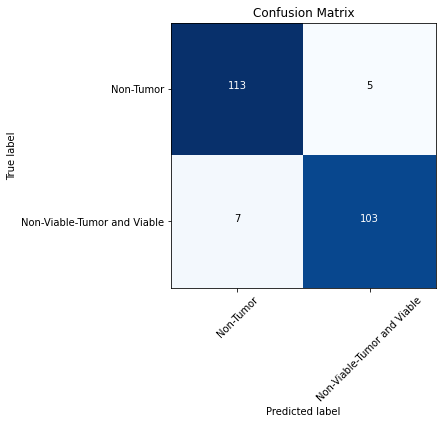

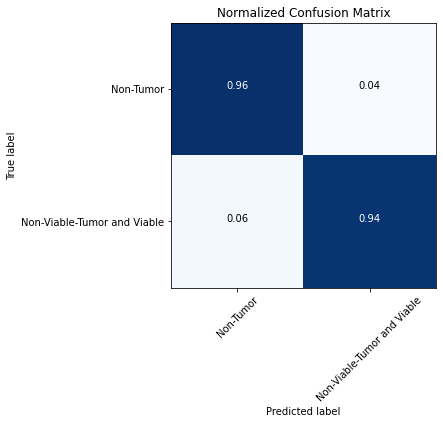

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor and Viable']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

## Non-tumor VS Non-Viable

In [ ]:
# combinig dataset for train set 
train_x_b2 = np.concatenate((non_tumor_train, non_viable_tumor_train), axis=0)
train_y_b2 = np.concatenate((non_tumor_train_l, non_viable_tumor_train_l), axis= 0)
print('Train set shape: ',train_x_b2.shape)
print('Train labels shape: ',train_y_b2.shape)

# combinig dataset for test set 
test_x_b2 = np.concatenate((non_tumor_test, non_viable_tumor_test), axis=0)
test_y_b2 = np.concatenate((non_tumor_test_l, non_viable_tumor_test_l), axis= 0)
print('Test set shape: ',test_x_b2.shape)
print('Test labels shape: ',test_y_b2.shape)

Train set shape:  (625, 1024)
Train labels shape:  (625,)
Test set shape:  (174, 1024)
Test labels shape:  (174,)


In [ ]:
# Scaling train and test features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_b2 = sc.fit_transform(train_x_b2)
X_test_b2 = sc.transform(test_x_b2)

print("After scaling train: ", X_train_b2.shape)
print("After scaling test size: ", X_test_b2.shape)

After scaling train:  (625, 1024)
After scaling test size:  (174, 1024)


In [ ]:
# with feature scaling 
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
# mlp_classifier.fit(X_train_b2, train_y_b2)
mlp_classifier.fit(train_x_b2, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
# k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)
k_fold_acc = cross_val_score(mlp_classifier, train_x_b2, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
# mlp_pred = mlp_classifier.predict(X_test_b2)
mlp_pred = mlp_classifier.predict(test_x_b2)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
# lr_probs = mlp_classifier.predict_proba(X_test_b2)
lr_probs = mlp_classifier.predict_proba(test_x_b2)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.954
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.894


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.94      0.91      0.93        56

    accuracy                           0.95       174
   macro avg       0.95      0.94      0.95       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.975      	   0.911   
  1       0.944     	      0.911      	   0.975   





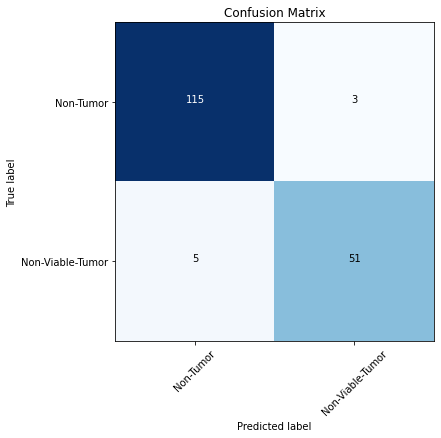

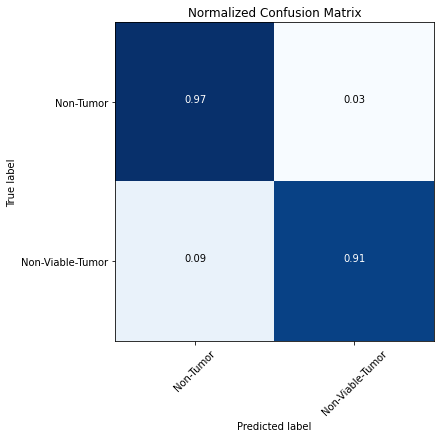

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor']

# getting classsification reports
get_reports(test_y_b2, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_pred)

## Non-tumor VS Viable tumor

In [ ]:
# combinig dataset for train set 
train_x_b3 = np.concatenate((non_tumor_train, viable_tumor_train), axis=0)
train_y_b3 = np.concatenate((non_tumor_train_l, viable_tumor_train_l), axis= 0)
print('Train set shape: ',train_x_b3.shape)
print('Train labels shape: ',train_y_b3.shape)

# combinig dataset for test set 
test_x_b3 = np.concatenate((non_tumor_test, viable_tumor_test), axis=0)
test_y_b3 = np.concatenate((non_tumor_test_l, viable_tumor_test_l), axis= 0)
print('Test set shape: ',test_x_b3.shape)
print('Test labels shape: ',test_y_b3.shape)

Train set shape:  (710, 1024)
Train labels shape:  (710,)
Test set shape:  (172, 1024)
Test labels shape:  (172,)


In [ ]:
# Scaling train and test features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_b3 = sc.fit_transform(train_x_b3)
X_test_b3 = sc.transform(test_x_b3)

print("After scaling train: ", X_train_b3.shape)
print("After scaling test size: ", X_test_b3.shape)

After scaling train:  (710, 1024)
After scaling test size:  (172, 1024)


In [ ]:
# with feature scaling 
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
# mlp_classifier.fit(X_train_b3, train_y_b3)
mlp_classifier.fit(train_x_b3, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
# k_fold_acc = cross_val_score(mlp_classifier, X_train_b3, train_y_b3, cv= 5)
k_fold_acc = cross_val_score(mlp_classifier, train_x_b3, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
# mlp_pred = mlp_classifier.predict(X_test_b3)
mlp_pred = mlp_classifier.predict(test_x_b3)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
# lr_probs = mlp_classifier.predict_proba(X_test_b3)
lr_probs = mlp_classifier.predict_proba(test_x_b3)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

k-fold validation accuracy for k=5 is:  0.965
Accuracy on test data is:  0.971
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.932


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       118
           2       0.96      0.94      0.95        54

    accuracy                           0.97       172
   macro avg       0.97      0.96      0.97       172
weighted avg       0.97      0.97      0.97       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.975     	      0.983      	   0.944   
  1       0.962     	      0.944      	   0.983   





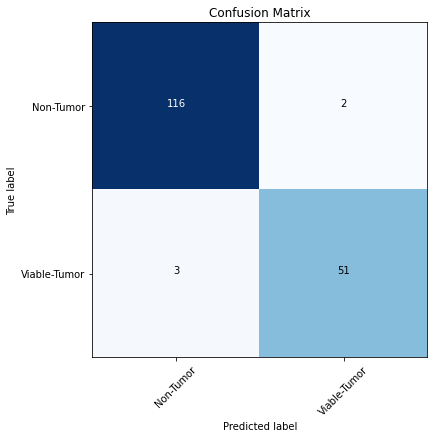

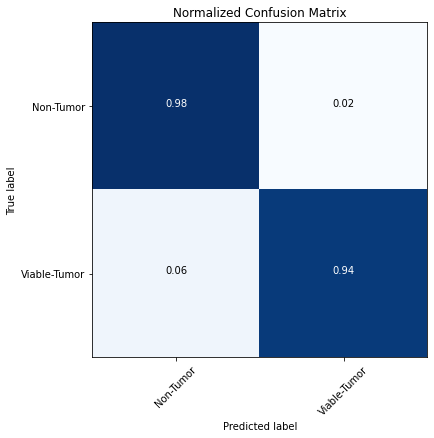

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_pred)

## Non-viable tumor VS Viable tumor

In [ ]:
# combinig dataset for train set 
train_x_b4 = np.concatenate((non_viable_tumor_train, viable_tumor_train), axis=0)
train_y_b4 = np.concatenate((non_viable_tumor_train_l, viable_tumor_train_l), axis= 0)
print('Train set shape: ',train_x_b4.shape)
print('Train labels shape: ',train_y_b4.shape)

# combinig dataset for test set 
test_x_b4 = np.concatenate((non_viable_tumor_test, viable_tumor_test), axis=0)
test_y_b4 = np.concatenate((non_viable_tumor_test_l, viable_tumor_test_l), axis= 0)
print('Test set shape: ',test_x_b4.shape)
print('Test labels shape: ',test_y_b4.shape)

Train set shape:  (497, 1024)
Train labels shape:  (497,)
Test set shape:  (110, 1024)
Test labels shape:  (110,)


In [ ]:
# Scaling train and test features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_b4 = sc.fit_transform(train_x_b4)
X_test_b4 = sc.transform(test_x_b4)

print("After scaling train: ", X_train_b4.shape)
print("After scaling test size: ", X_test_b4.shape)

After scaling train:  (497, 1024)
After scaling test size:  (110, 1024)


In [ ]:
# with feature scaling 
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
# mlp_classifier.fit(X_train_b3, train_y_b3)
mlp_classifier.fit(train_x_b4, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
# k_fold_acc = cross_val_score(mlp_classifier, X_train_b3, train_y_b3, cv= 5)
k_fold_acc = cross_val_score(mlp_classifier, train_x_b4, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
# mlp_pred = mlp_classifier.predict(X_test_b3)
mlp_pred = mlp_classifier.predict(test_x_b4)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
# lr_probs = mlp_classifier.predict_proba(X_test_b3)
lr_probs = mlp_classifier.predict_proba(test_x_b4)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

k-fold validation accuracy for k=5 is:  0.948
Accuracy on test data is:  0.936
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.874


              precision    recall  f1-score   support

           1       0.92      0.96      0.94        56
           2       0.96      0.91      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.915     	      0.964      	   0.907   
  1       0.961     	      0.907      	   0.964   





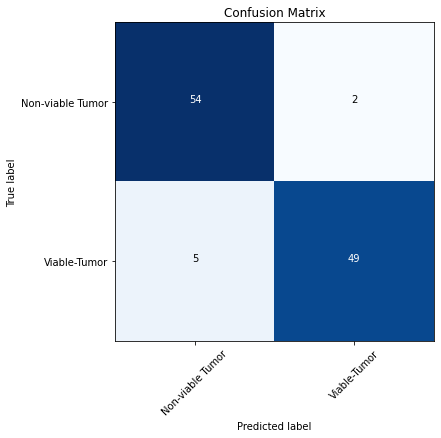

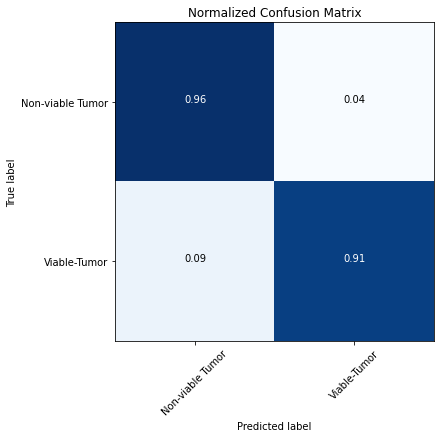

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_pred)

# Binary Classification with feature selection

## Non- tumor VS Non-viable and Viable

### Using PCA

Text(0, 0.5, 'Cum variance')

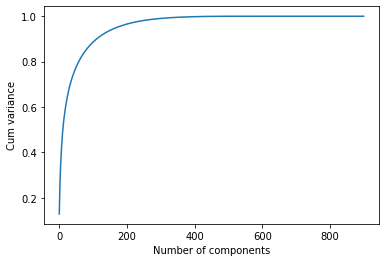

In [ ]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components= 900)  # n_components must be between: min(n_samples, n_features)
pca_test.fit(X_train_b1)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

#### PCA 100

In [ ]:
pca = PCA(n_components= 100)

X_train_pca = pca.fit_transform(X_train_b1)
X_test_pca = pca.transform(X_test_b1)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b1.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b1.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (916, 1024) 	after PCA-  (916, 100)
Test features shape:	before PCA-  (228, 1024) 	after PCA-  (228, 100)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.956
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.912


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       118
           1       0.95      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.958      	   0.955   
  1       0.955     	      0.955      	   0.958   





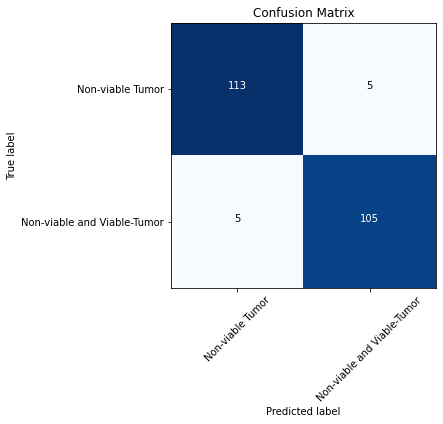

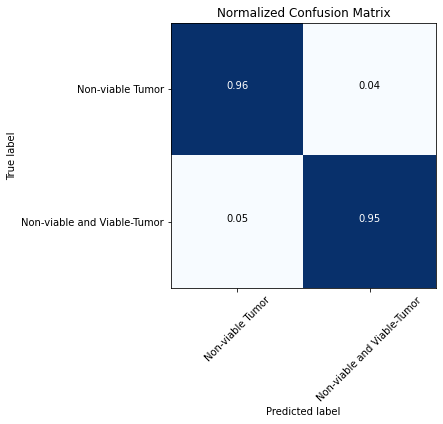

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

#### PCA 200

In [ ]:
pca = PCA(n_components= 200)

X_train_pca = pca.fit_transform(X_train_b1)
X_test_pca = pca.transform(X_test_b1)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b1.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b1.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (916, 1024) 	after PCA-  (916, 200)
Test features shape:	before PCA-  (228, 1024) 	after PCA-  (228, 200)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.969
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.939


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.96      0.97      0.97       110

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.974     	      0.966      	   0.973   
  1       0.964     	      0.973      	   0.966   





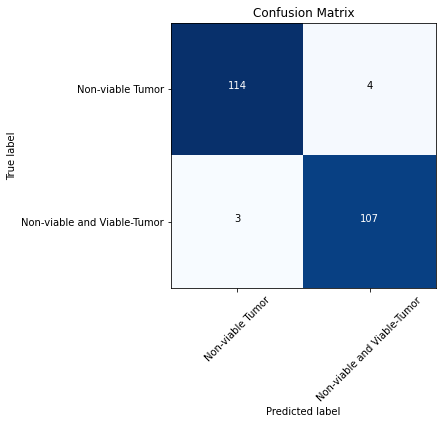

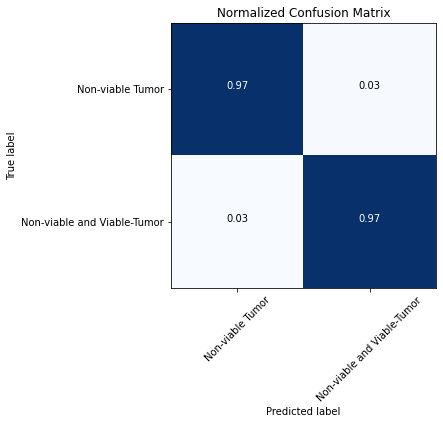

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

#### PCA 300

In [ ]:
pca = PCA(n_components= 300)

X_train_pca = pca.fit_transform(X_train_b1)
X_test_pca = pca.transform(X_test_b1)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b1.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b1.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (916, 1024) 	after PCA-  (916, 300)
Test features shape:	before PCA-  (228, 1024) 	after PCA-  (228, 300)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.939
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.877


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       118
           1       0.93      0.95      0.94       110

    accuracy                           0.94       228
   macro avg       0.94      0.94      0.94       228
weighted avg       0.94      0.94      0.94       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.948     	      0.932      	   0.945   
  1       0.929     	      0.945      	   0.932   





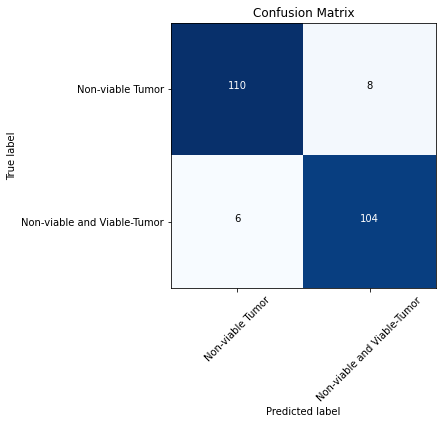

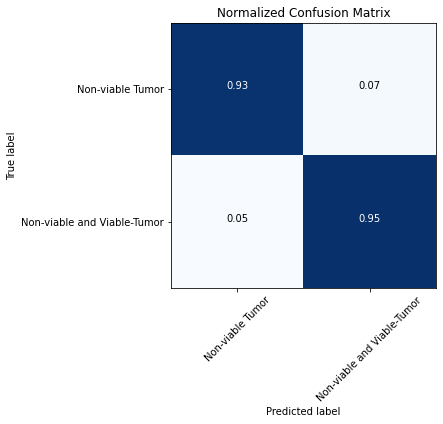

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

#### PCA 400

In [ ]:
pca = PCA(n_components= 400)

X_train_pca = pca.fit_transform(X_train_b1)
X_test_pca = pca.transform(X_test_b1)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b1.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b1.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (916, 1024) 	after PCA-  (916, 400)
Test features shape:	before PCA-  (228, 1024) 	after PCA-  (228, 400)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.961
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       118
           1       0.95      0.96      0.96       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.966     	      0.958      	   0.964   
  1       0.955     	      0.964      	   0.958   





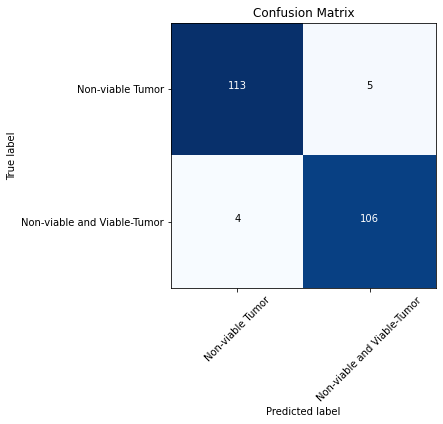

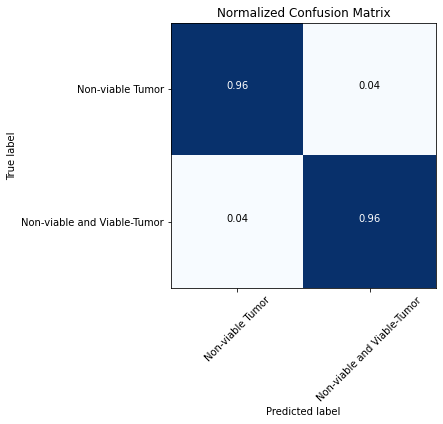

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

#### PCA 500

In [ ]:
pca = PCA(n_components= 500)

X_train_pca = pca.fit_transform(X_train_b1)
X_test_pca = pca.transform(X_test_b1)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b1.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b1.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (916, 1024) 	after PCA-  (916, 500)
Test features shape:	before PCA-  (228, 1024) 	after PCA-  (228, 500)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.969
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.939


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.96      0.97      0.97       110

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.974     	      0.966      	   0.973   
  1       0.964     	      0.973      	   0.966   





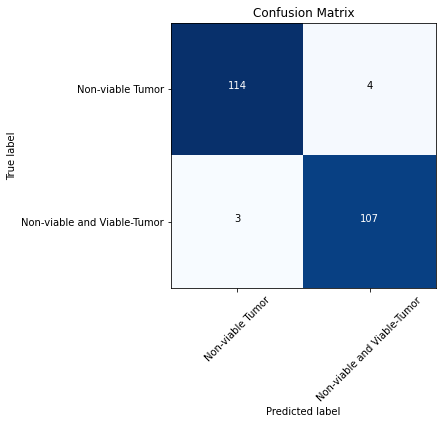

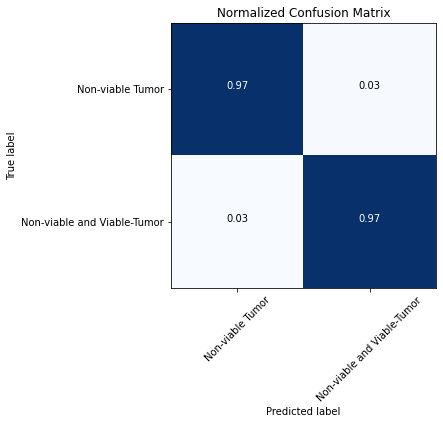

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

#### PCA 600

In [ ]:
pca = PCA(n_components= 600)

X_train_pca = pca.fit_transform(X_train_b1)
X_test_pca = pca.transform(X_test_b1)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b1.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b1.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (916, 1024) 	after PCA-  (916, 600)
Test features shape:	before PCA-  (228, 1024) 	after PCA-  (228, 600)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.969
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.939


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.96      0.97      0.97       110

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.974     	      0.966      	   0.973   
  1       0.964     	      0.973      	   0.966   





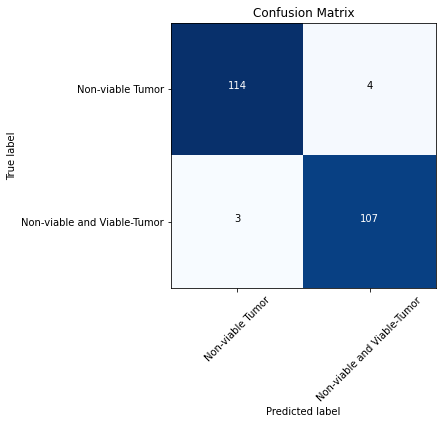

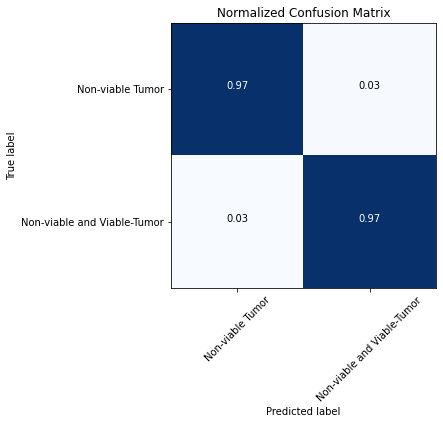

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

#### PCA 700

In [ ]:
pca = PCA(n_components= 700)

X_train_pca = pca.fit_transform(X_train_b1)
X_test_pca = pca.transform(X_test_b1)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b1.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b1.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (916, 1024) 	after PCA-  (916, 700)
Test features shape:	before PCA-  (228, 1024) 	after PCA-  (228, 700)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.969
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.939


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.96      0.97      0.97       110

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.974     	      0.966      	   0.973   
  1       0.964     	      0.973      	   0.966   





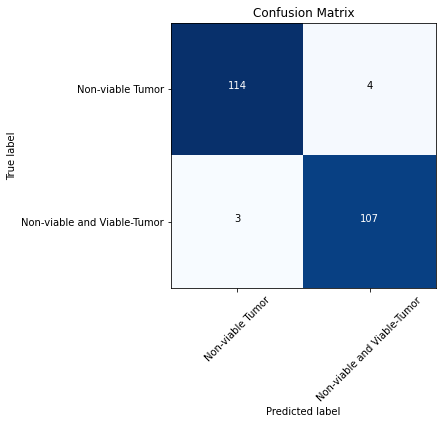

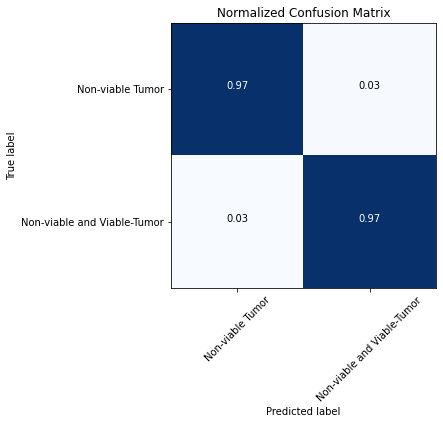

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

#### PCA 800

In [ ]:
pca = PCA(n_components= 800)

X_train_pca = pca.fit_transform(X_train_b1)
X_test_pca = pca.transform(X_test_b1)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b1.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b1.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (916, 1024) 	after PCA-  (916, 800)
Test features shape:	before PCA-  (228, 1024) 	after PCA-  (228, 800)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.961
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.96      0.95      0.96       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.955   
  1       0.963     	      0.955      	   0.966   





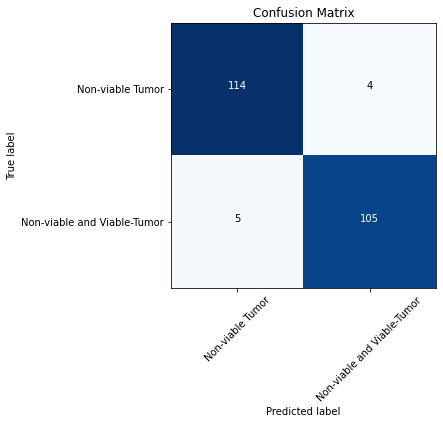

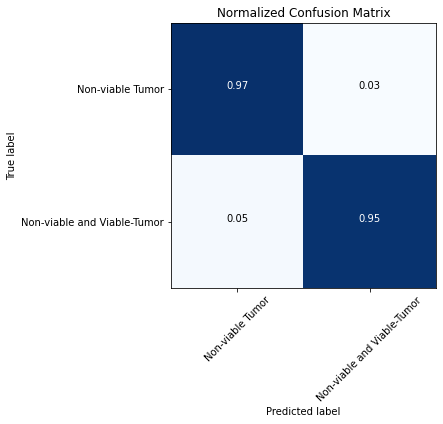

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

#### PCA 900

In [ ]:
pca = PCA(n_components= 900)

X_train_pca = pca.fit_transform(X_train_b1)
X_test_pca = pca.transform(X_test_b1)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b1.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b1.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (916, 1024) 	after PCA-  (916, 900)
Test features shape:	before PCA-  (228, 1024) 	after PCA-  (228, 900)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.961
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       118
           1       0.95      0.96      0.96       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.966     	      0.958      	   0.964   
  1       0.955     	      0.964      	   0.958   





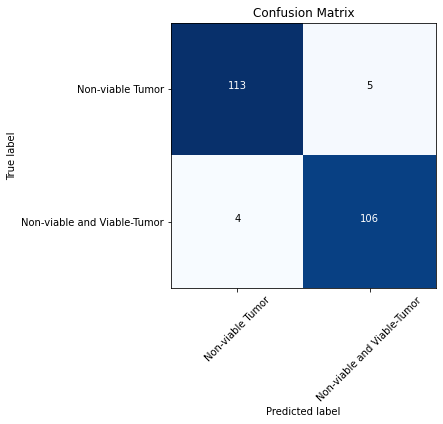

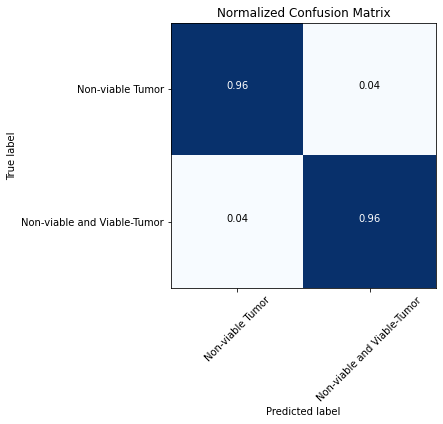

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

### Using MIG

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

#### MIG 100

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=100)

# fit to selector
X_train_ig = select.fit_transform(X_train_b1, train_y_b1)
X_test_ig = select.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)
k-fold validation accuracy for k=5 is:  0.912
Accuracy on test data is:  0.947
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.895


              precision    recall  f1-score   support

           0       0.96      0.93      0.95       118
           1       0.93      0.96      0.95       110

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.965     	      0.932      	   0.964   
  1        0.93     	      0.964      	   0.932   





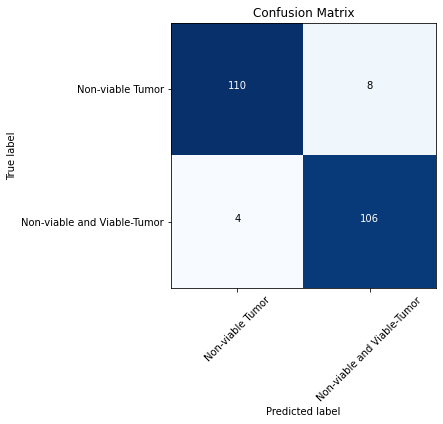

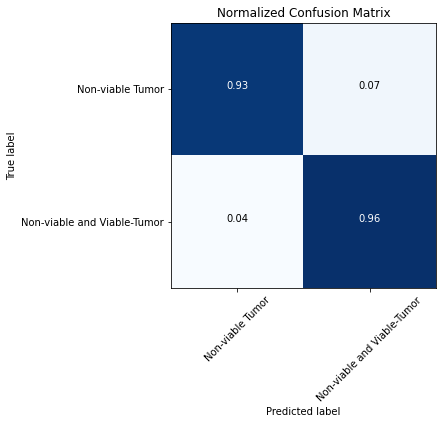

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### MIG 200

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=200)

# fit to selector
X_train_ig = select.fit_transform(X_train_b1, train_y_b1)
X_test_ig = select.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)
k-fold validation accuracy for k=5 is:  0.935
Accuracy on test data is:  0.956
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.912


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       118
           1       0.95      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.958      	   0.955   
  1       0.955     	      0.955      	   0.958   





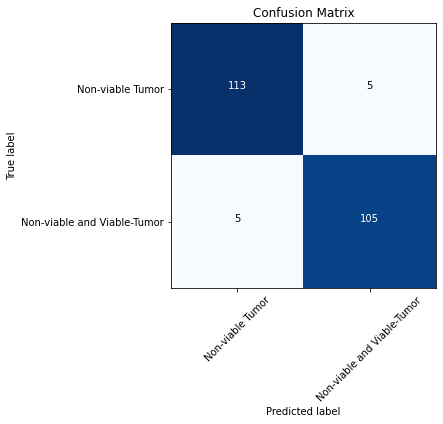

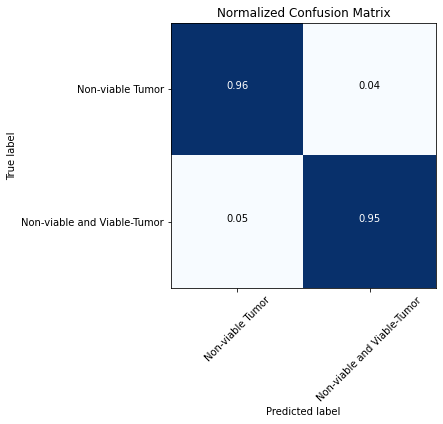

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### MIG 300

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=300)

# fit to selector
X_train_ig = select.fit_transform(X_train_b1, train_y_b1)
X_test_ig = select.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)
k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.956
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.912


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       118
           1       0.95      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.958      	   0.955   
  1       0.955     	      0.955      	   0.958   





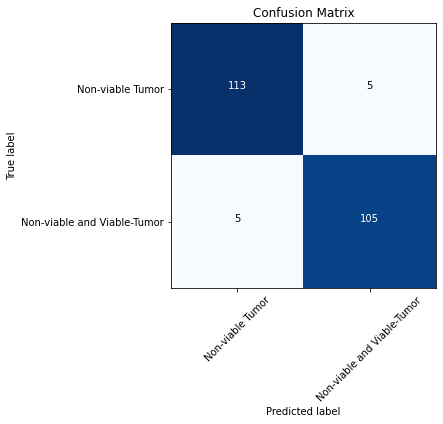

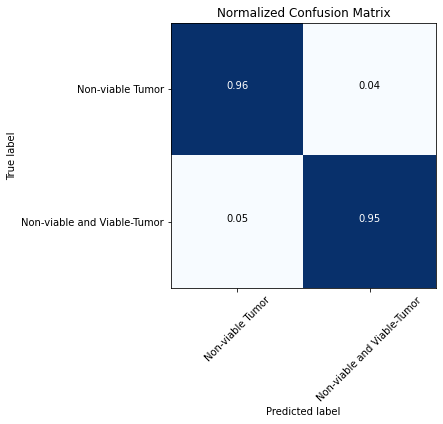

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### MIG 400

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=400)

# fit to selector
X_train_ig = select.fit_transform(X_train_b1, train_y_b1)
X_test_ig = select.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)
k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.956
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.912


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.96      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.966      	   0.945   
  1       0.963     	      0.945      	   0.966   





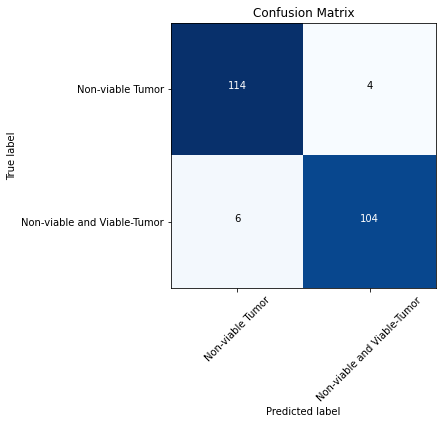

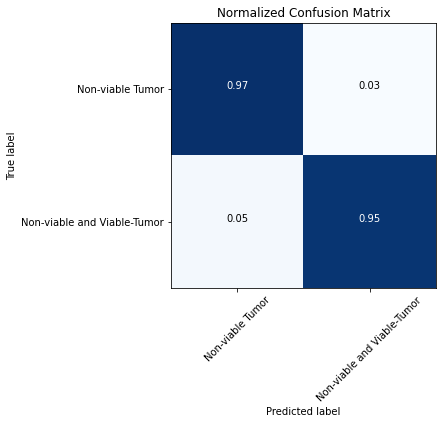

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### MIG 500

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=500)

# fit to selector
X_train_ig = select.fit_transform(X_train_b1, train_y_b1)
X_test_ig = select.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)
k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.961
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.96      0.95      0.96       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.955   
  1       0.963     	      0.955      	   0.966   





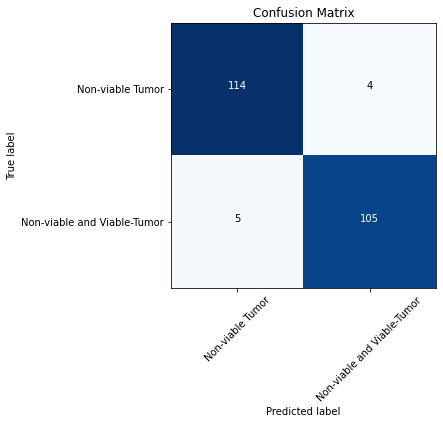

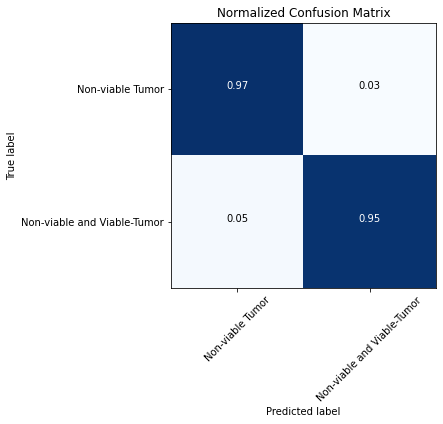

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### MIG 600

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=600)

# fit to selector
X_train_ig = select.fit_transform(X_train_b1, train_y_b1)
X_test_ig = select.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)
k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.969
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.939


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.96      0.97      0.97       110

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.974     	      0.966      	   0.973   
  1       0.964     	      0.973      	   0.966   





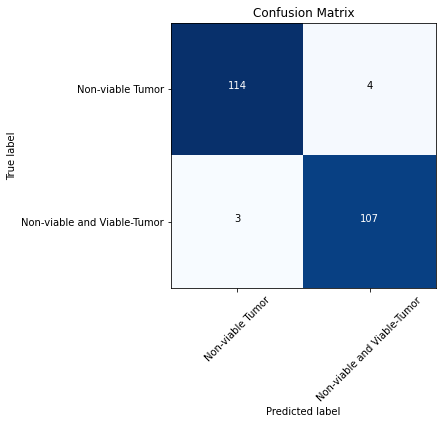

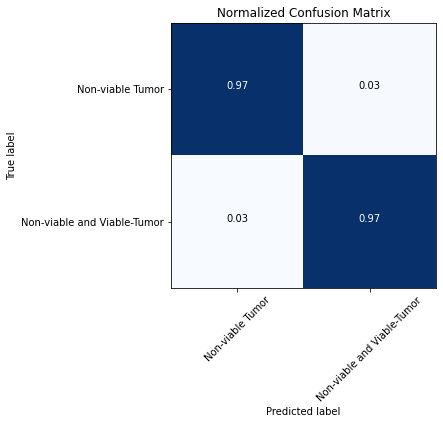

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### MIG 700

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=700)

# fit to selector
X_train_ig = select.fit_transform(X_train_b1, train_y_b1)
X_test_ig = select.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.952
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.904


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       118
           1       0.96      0.94      0.95       110

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.942     	      0.966      	   0.936   
  1       0.963     	      0.936      	   0.966   





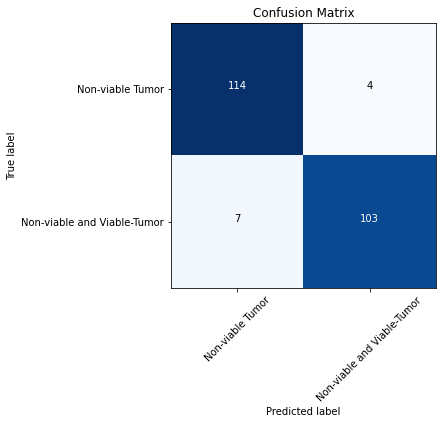

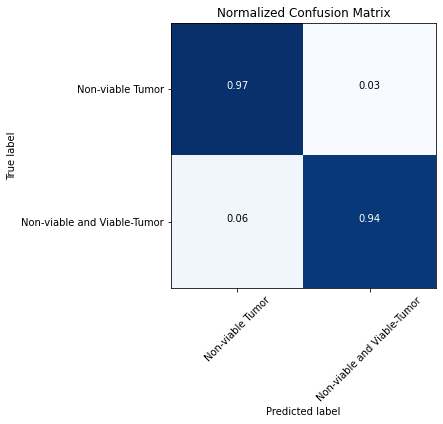

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### MIG 800

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=800)

# fit to selector
X_train_ig = select.fit_transform(X_train_b1, train_y_b1)
X_test_ig = select.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)
k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.952
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.904


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       118
           1       0.96      0.94      0.95       110

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.942     	      0.966      	   0.936   
  1       0.963     	      0.936      	   0.966   





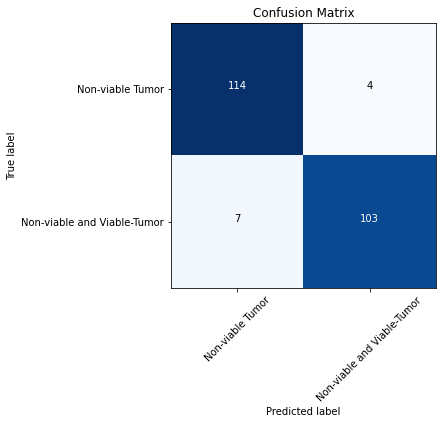

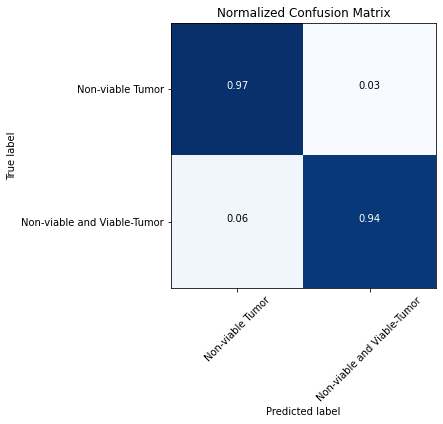

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### MIG 900

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=900)

# fit to selector
X_train_ig = select.fit_transform(X_train_b1, train_y_b1)
X_test_ig = select.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)
k-fold validation accuracy for k=5 is:  0.93
Accuracy on test data is:  0.961
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.96      0.95      0.96       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.955   
  1       0.963     	      0.955      	   0.966   





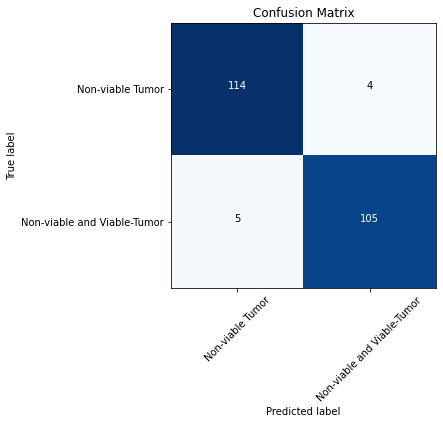

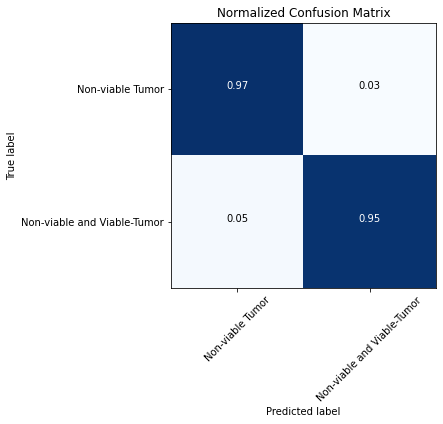

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

### Using RFE

#### RFE 100

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=100)

# fit our train data into RFE 
rfe.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b1)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.969
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.939


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.96      0.97      0.97       110

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.974     	      0.966      	   0.973   
  1       0.964     	      0.973      	   0.966   





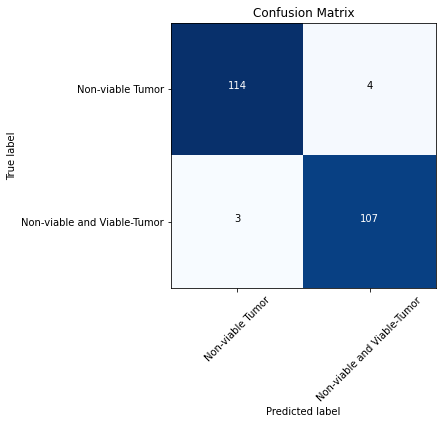

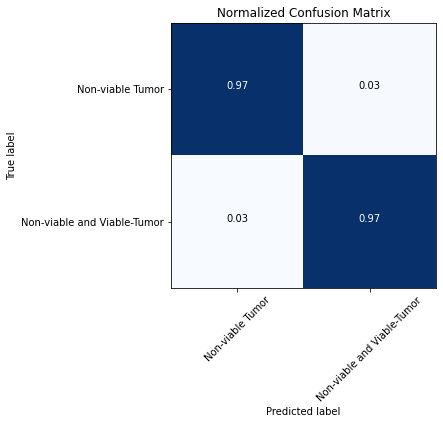

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### RFE 200

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=200)

# fit our train data into RFE 
rfe.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b1)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)
k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.943
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.886


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       118
           1       0.94      0.94      0.94       110

    accuracy                           0.94       228
   macro avg       0.94      0.94      0.94       228
weighted avg       0.94      0.94      0.94       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.941     	      0.949      	   0.936   
  1       0.945     	      0.936      	   0.949   





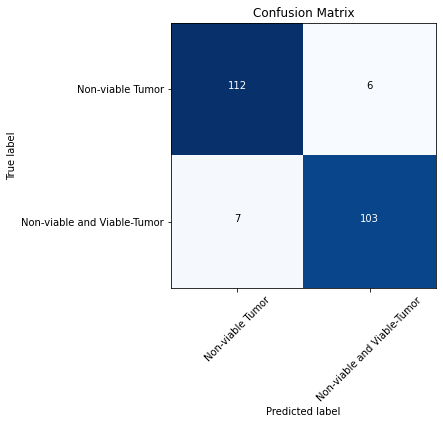

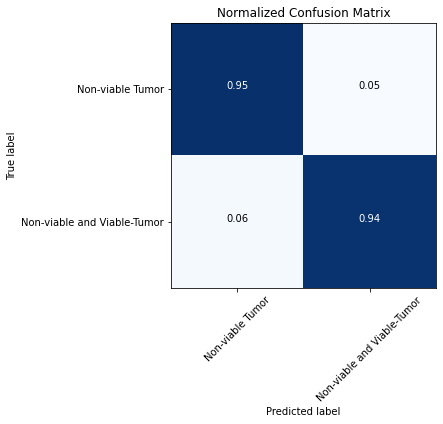

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### RFE 300

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=300)

# fit our train data into RFE 
rfe.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b1)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)
k-fold validation accuracy for k=5 is:  0.932
Accuracy on test data is:  0.961
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.97      0.95      0.96       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.975      	   0.945   
  1       0.972     	      0.945      	   0.975   





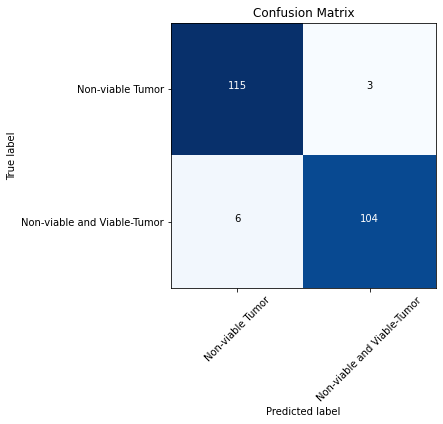

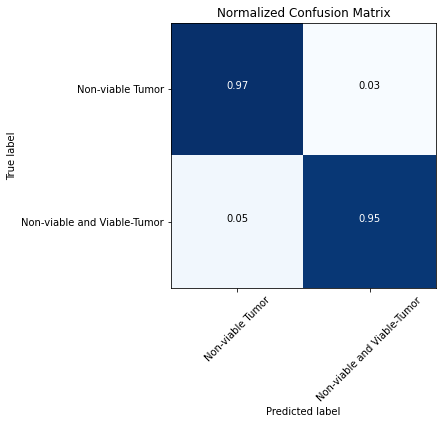

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### RFE 400

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=400)

# fit our train data into RFE 
rfe.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b1)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)
k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.956
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.912


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.96      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.966      	   0.945   
  1       0.963     	      0.945      	   0.966   





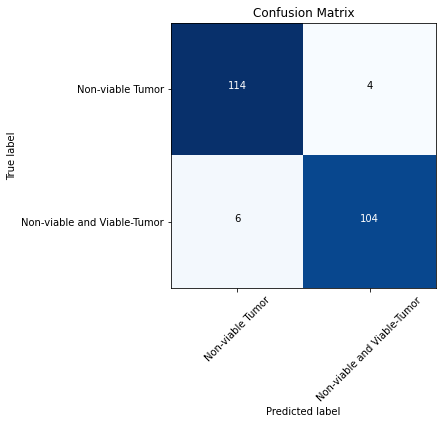

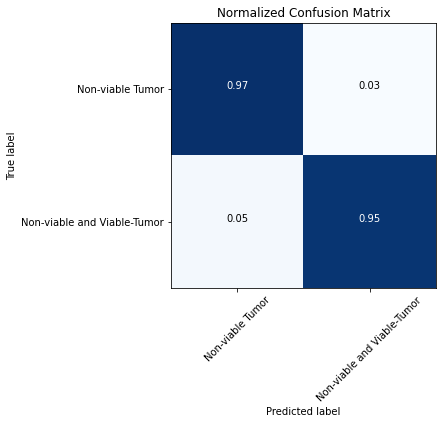

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### RFE 500

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=500)

# fit our train data into RFE 
rfe.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b1)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)
k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.961
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       118
           1       0.95      0.96      0.96       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.966     	      0.958      	   0.964   
  1       0.955     	      0.964      	   0.958   





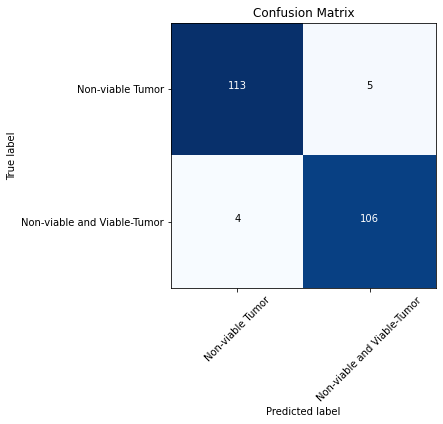

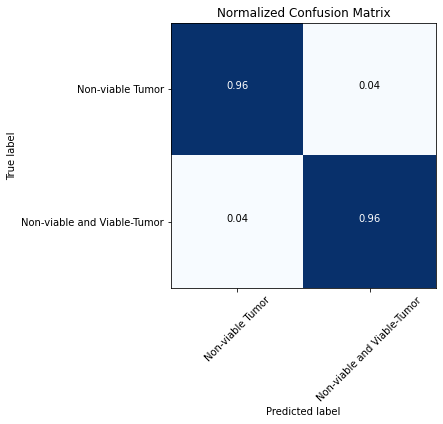

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### RFE 600

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=600)

# fit our train data into RFE 
rfe.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b1)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.956
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.912


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.96      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.966      	   0.945   
  1       0.963     	      0.945      	   0.966   





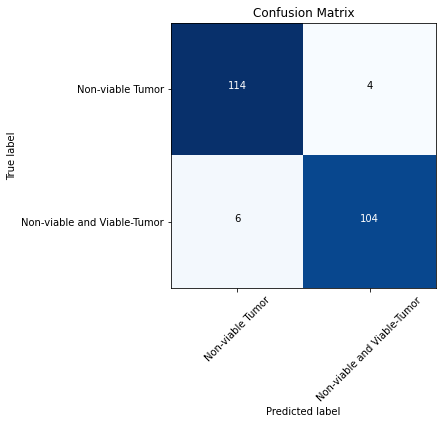

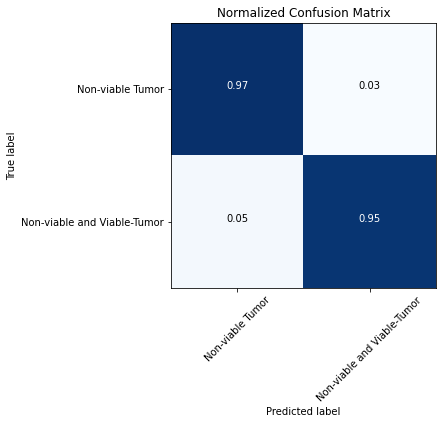

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### RFE 700

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=700)

# fit our train data into RFE 
rfe.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b1)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)
k-fold validation accuracy for k=5 is:  0.93
Accuracy on test data is:  0.952
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.903


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       118
           1       0.95      0.95      0.95       110

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.958      	   0.945   
  1       0.954     	      0.945      	   0.958   





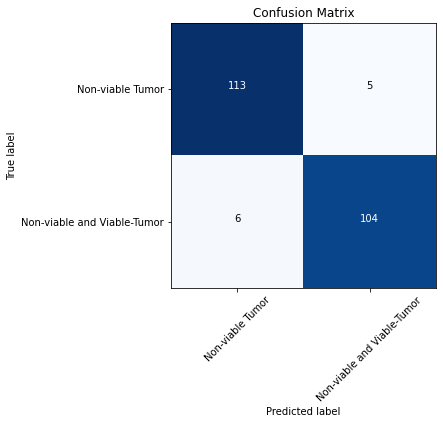

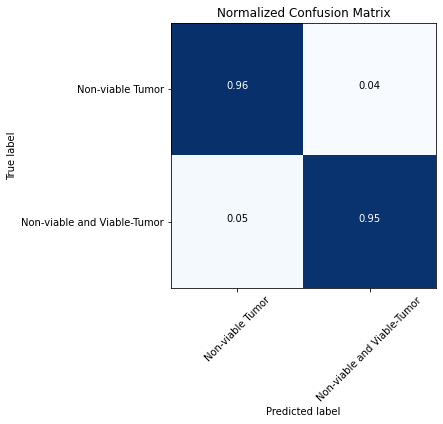

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### RFE 800

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=800)

# fit our train data into RFE 
rfe.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b1)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)
k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.947
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.895


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       118
           1       0.95      0.94      0.94       110

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.942     	      0.958      	   0.936   
  1       0.954     	      0.936      	   0.958   





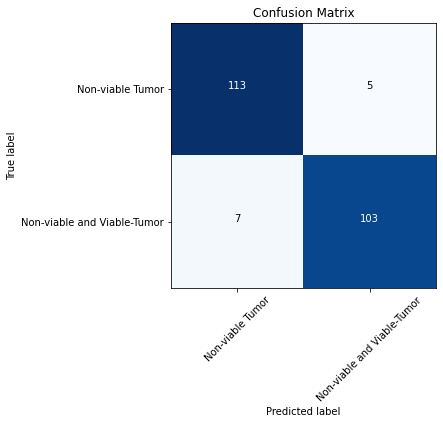

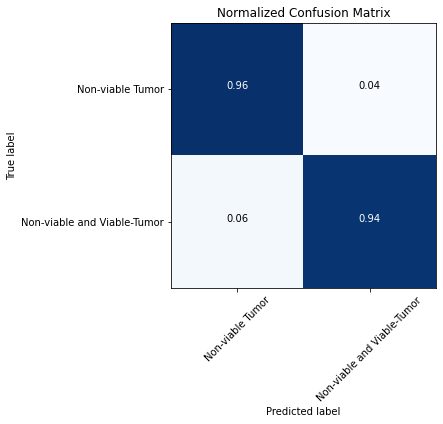

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### RFE 900

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=900)

# fit our train data into RFE 
rfe.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b1)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)
k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.947
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.895


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.96      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.966      	   0.945   
  1       0.963     	      0.945      	   0.966   





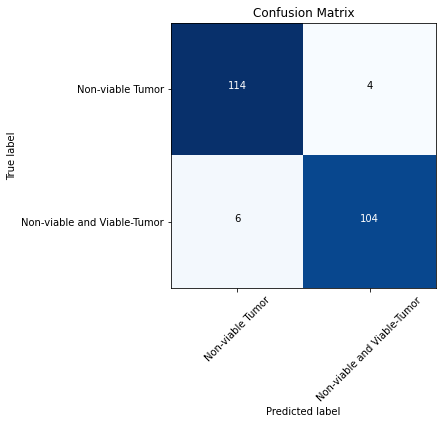

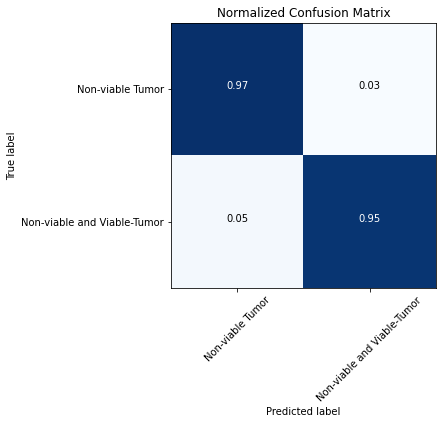

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

### Univariate

#### 100

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=100)
selector.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_uv = selector.transform(X_train_b1)

# getting transformed test features
X_test_uv = selector.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)
k-fold validation accuracy for k=5 is:  0.921
Accuracy on test data is:  0.961
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       118
           1       0.95      0.97      0.96       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.974     	      0.949      	   0.973   
  1       0.947     	      0.973      	   0.949   





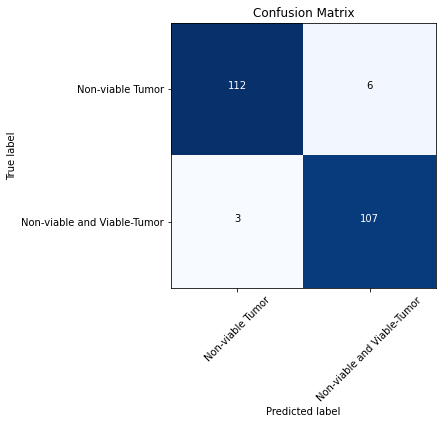

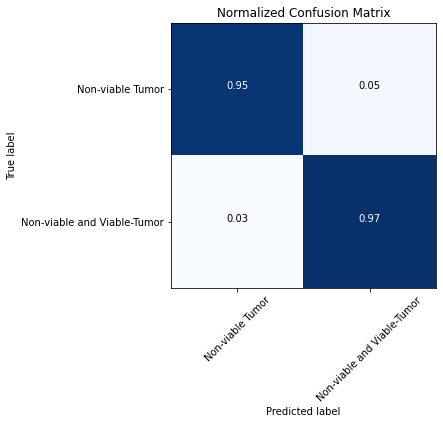

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### 200

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=200)
selector.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_uv = selector.transform(X_train_b1)

# getting transformed test features
X_test_uv = selector.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)
k-fold validation accuracy for k=5 is:  0.923
Accuracy on test data is:  0.969
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.939


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.96      0.97      0.97       110

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.974     	      0.966      	   0.973   
  1       0.964     	      0.973      	   0.966   





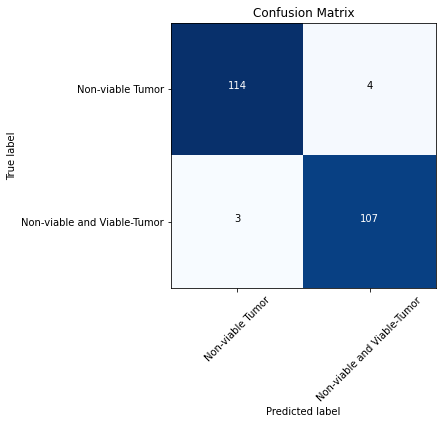

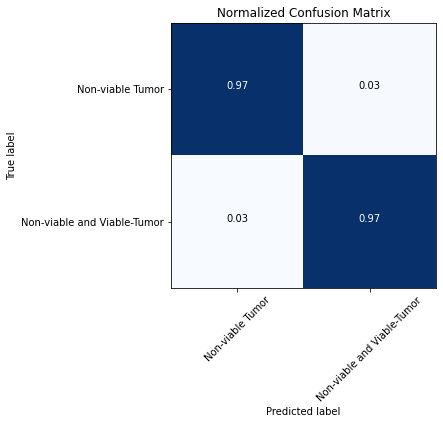

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### 300

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=300)
selector.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_uv = selector.transform(X_train_b1)

# getting transformed test features
X_test_uv = selector.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)
k-fold validation accuracy for k=5 is:  0.932
Accuracy on test data is:  0.956
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.912


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.96      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.966      	   0.945   
  1       0.963     	      0.945      	   0.966   





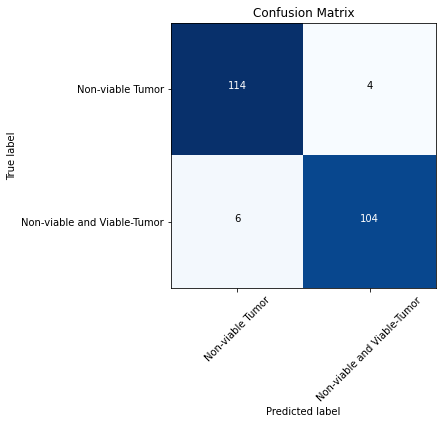

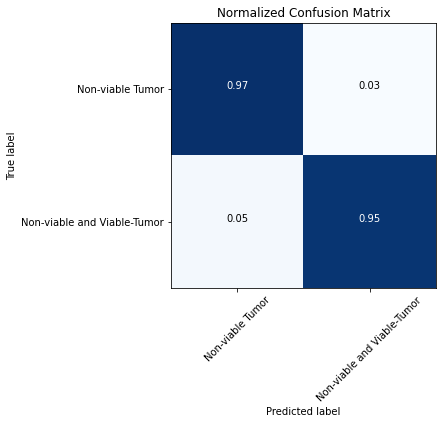

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### 400

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=400)
selector.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_uv = selector.transform(X_train_b1)

# getting transformed test features
X_test_uv = selector.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)
k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.947
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.895


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       118
           1       0.95      0.95      0.95       110

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.949     	      0.949      	   0.945   
  1       0.945     	      0.945      	   0.949   





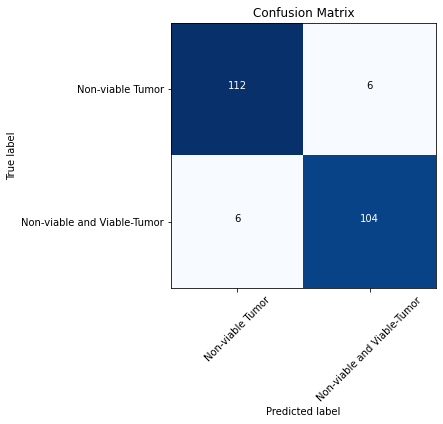

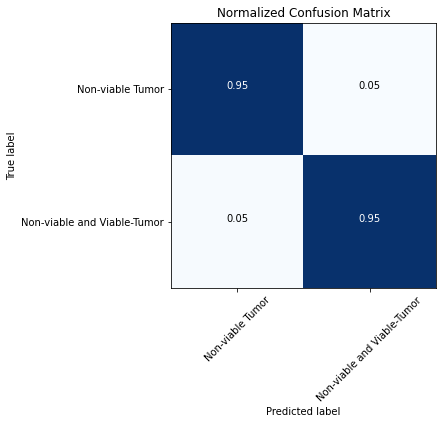

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### 500

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=500)
selector.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_uv = selector.transform(X_train_b1)

# getting transformed test features
X_test_uv = selector.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)
k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.952
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.903


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       118
           1       0.95      0.95      0.95       110

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.958      	   0.945   
  1       0.954     	      0.945      	   0.958   





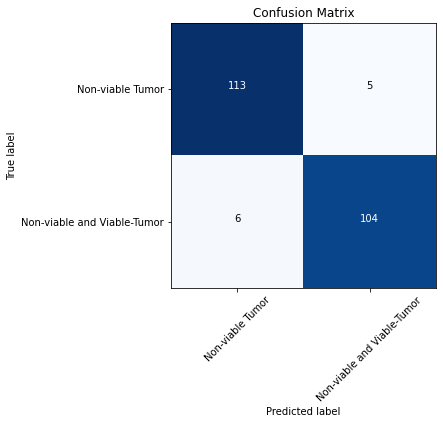

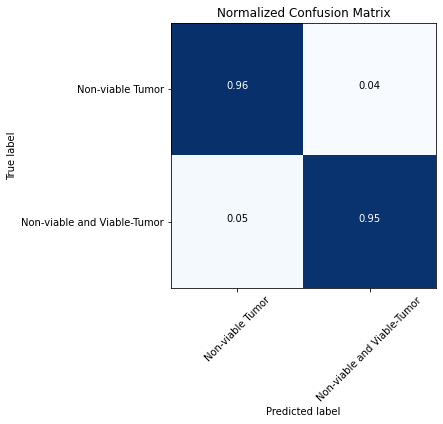

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### 600

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=600)
selector.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_uv = selector.transform(X_train_b1)

# getting transformed test features
X_test_uv = selector.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)
k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.956
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.912


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.96      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.966      	   0.945   
  1       0.963     	      0.945      	   0.966   





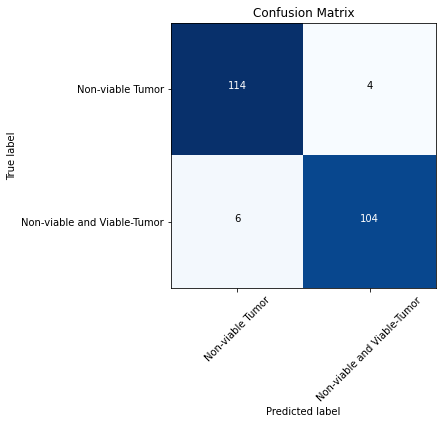

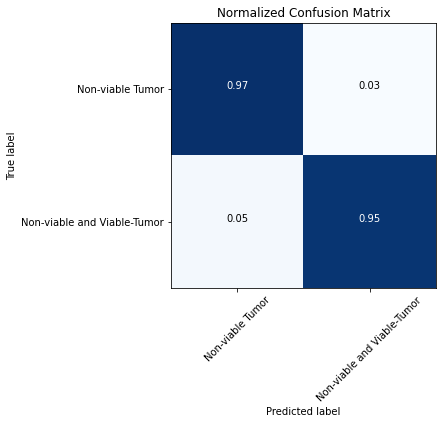

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### 700

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=700)
selector.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_uv = selector.transform(X_train_b1)

# getting transformed test features
X_test_uv = selector.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)
k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.965
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.93


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       118
           1       0.96      0.97      0.96       110

    accuracy                           0.96       228
   macro avg       0.96      0.97      0.96       228
weighted avg       0.97      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.974     	      0.958      	   0.973   
  1       0.955     	      0.973      	   0.958   





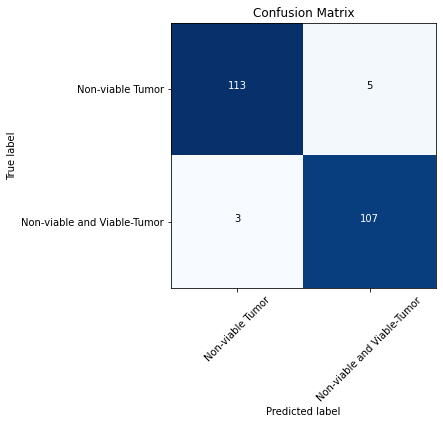

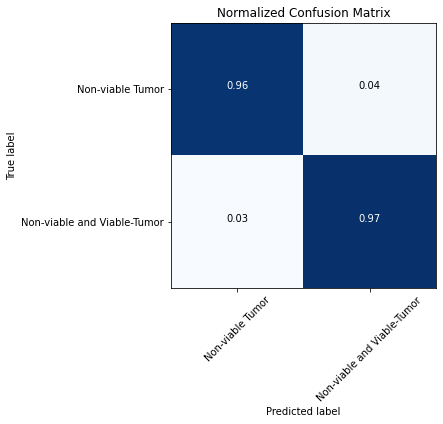

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### 800

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=800)
selector.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_uv = selector.transform(X_train_b1)

# getting transformed test features
X_test_uv = selector.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)
k-fold validation accuracy for k=5 is:  0.932
Accuracy on test data is:  0.952
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.903


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       118
           1       0.95      0.95      0.95       110

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.958      	   0.945   
  1       0.954     	      0.945      	   0.958   





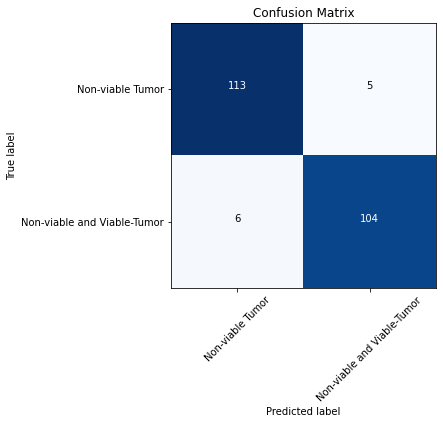

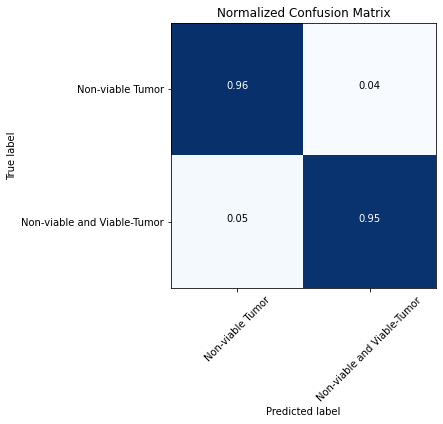

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

#### 900

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=900)
selector.fit(X_train_b1, train_y_b1)

# getting transformed train features
X_train_uv = selector.transform(X_train_b1)

# getting transformed test features
X_test_uv = selector.transform(X_test_b1)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b1, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)
k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.956
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.912


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       118
           1       0.95      0.95      0.95       110

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.958      	   0.955   
  1       0.955     	      0.955      	   0.958   





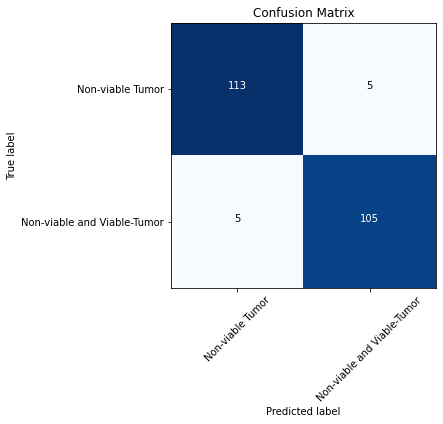

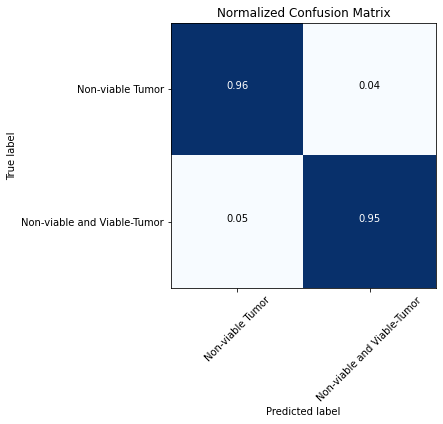

In [ ]:
classes = ['Non-viable Tumor', 'Non-viable and Viable-Tumor']

# getting classsification reports
get_reports(test_y_b1, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_p)

## Non-tumor VS Non-Viable

In [ ]:
# train set and labels = train_x_b2, train_y_b2
# test set = test_x_b2, test_y_b2
print(X_train_b2.shape)

(625, 1024)


### Using PCA

Text(0, 0.5, 'Cum variance')

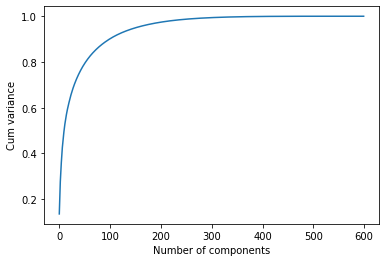

In [ ]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components= 600)  # n_components must be between: min(n_samples, n_features)
pca_test.fit(X_train_b2)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

#### PCA 100

In [ ]:
pca = PCA(n_components= 100)

X_train_pca = pca.fit_transform(X_train_b2)
X_test_pca = pca.transform(X_test_b2)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b2.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b2.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (625, 1024) 	after PCA-  (625, 100)
Test features shape:	before PCA-  (174, 1024) 	after PCA-  (174, 100)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.948
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.93      0.91      0.92        56

    accuracy                           0.95       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.911   
  1       0.927     	      0.911      	   0.966   





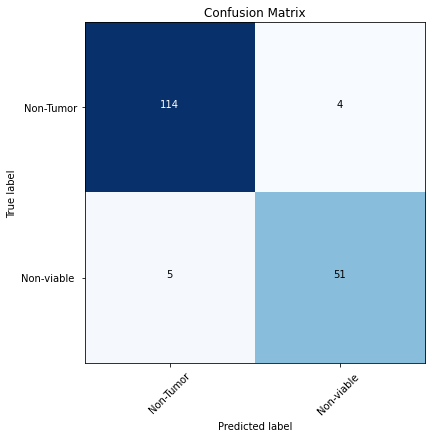

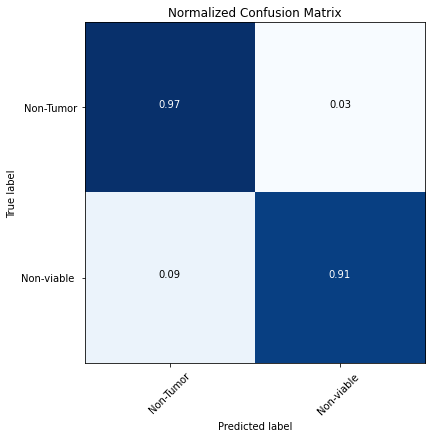

In [ ]:
classes = ['Non-Tumor', 'Non-viable ']

# getting classsification reports
get_reports(test_y_b2, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_pred)

#### PCA 200

In [ ]:
pca = PCA(n_components= 200)

X_train_pca = pca.fit_transform(X_train_b2)
X_test_pca = pca.transform(X_test_b2)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b2.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b2.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (625, 1024) 	after PCA-  (625, 200)
Test features shape:	before PCA-  (174, 1024) 	after PCA-  (174, 200)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.954
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.895


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.93      0.93      0.93        56

    accuracy                           0.95       174
   macro avg       0.95      0.95      0.95       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.966     	      0.966      	   0.929   
  1       0.929     	      0.929      	   0.966   





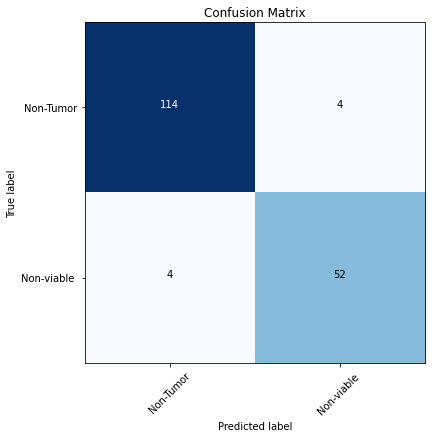

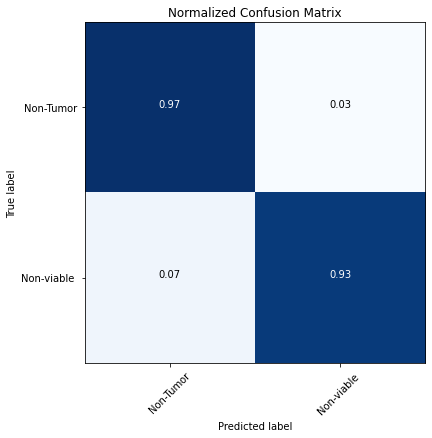

In [ ]:
classes = ['Non-Tumor', 'Non-viable ']

# getting classsification reports
get_reports(test_y_b2, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_pred)

#### PCA 300

In [ ]:
pca = PCA(n_components= 300)

X_train_pca = pca.fit_transform(X_train_b2)
X_test_pca = pca.transform(X_test_b2)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b2.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b2.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (625, 1024) 	after PCA-  (625, 300)
Test features shape:	before PCA-  (174, 1024) 	after PCA-  (174, 300)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.954
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.894


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.94      0.91      0.93        56

    accuracy                           0.95       174
   macro avg       0.95      0.94      0.95       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.975      	   0.911   
  1       0.944     	      0.911      	   0.975   





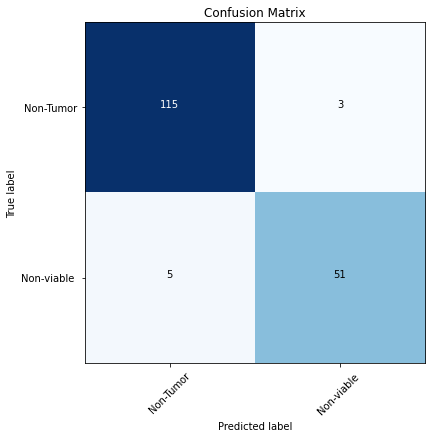

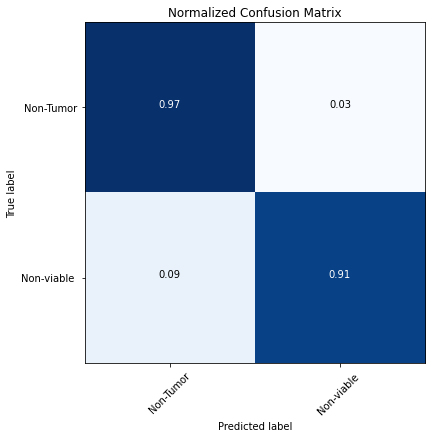

In [ ]:
classes = ['Non-Tumor', 'Non-viable ']

# getting classsification reports
get_reports(test_y_b2, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_pred)

#### PCA 400

In [ ]:
pca = PCA(n_components= 400)

X_train_pca = pca.fit_transform(X_train_b2)
X_test_pca = pca.transform(X_test_b2)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b2.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b2.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (625, 1024) 	after PCA-  (625, 400)
Test features shape:	before PCA-  (174, 1024) 	after PCA-  (174, 400)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.948
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.94      0.89      0.92        56

    accuracy                           0.95       174
   macro avg       0.95      0.93      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.975      	   0.893   
  1       0.943     	      0.893      	   0.975   





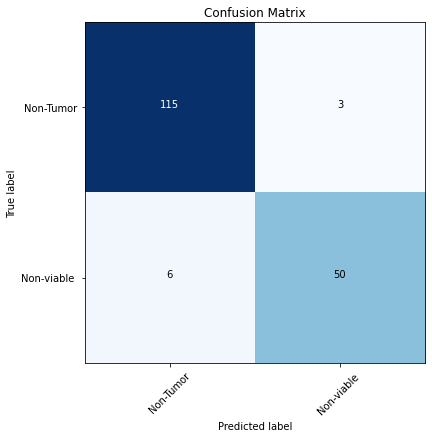

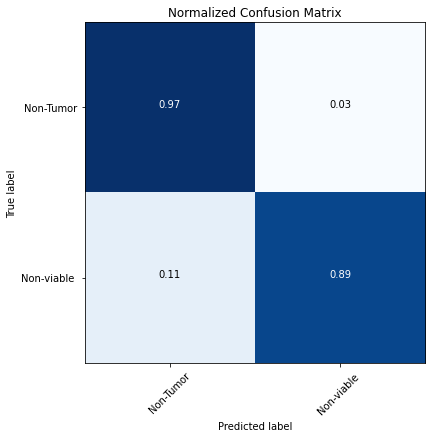

In [ ]:
classes = ['Non-Tumor', 'Non-viable ']

# getting classsification reports
get_reports(test_y_b2, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_pred)

#### PCA 500

In [ ]:
pca = PCA(n_components= 500)

X_train_pca = pca.fit_transform(X_train_b2)
X_test_pca = pca.transform(X_test_b2)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b2.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b2.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (625, 1024) 	after PCA-  (625, 500)
Test features shape:	before PCA-  (174, 1024) 	after PCA-  (174, 500)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.96
ROC-AUC score is:  0.976
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       118
           1       0.96      0.91      0.94        56

    accuracy                           0.96       174
   macro avg       0.96      0.95      0.95       174
weighted avg       0.96      0.96      0.96       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.959     	      0.983      	   0.911   
  1       0.962     	      0.911      	   0.983   





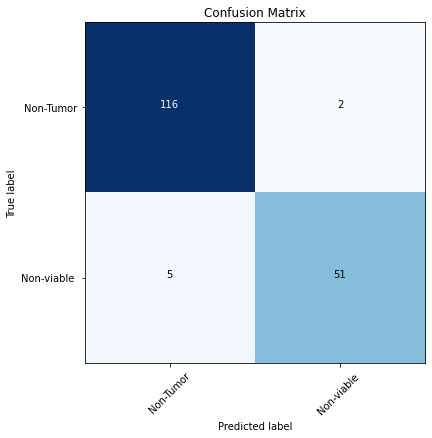

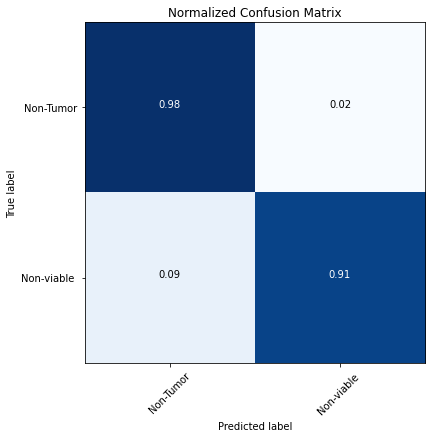

In [ ]:
classes = ['Non-Tumor', 'Non-viable ']

# getting classsification reports
get_reports(test_y_b2, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_pred)

#### PCA 600

In [ ]:
pca = PCA(n_components= 600)

X_train_pca = pca.fit_transform(X_train_b2)
X_test_pca = pca.transform(X_test_b2)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b2.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b2.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (625, 1024) 	after PCA-  (625, 600)
Test features shape:	before PCA-  (174, 1024) 	after PCA-  (174, 600)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.948
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.94      0.89      0.92        56

    accuracy                           0.95       174
   macro avg       0.95      0.93      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.975      	   0.893   
  1       0.943     	      0.893      	   0.975   





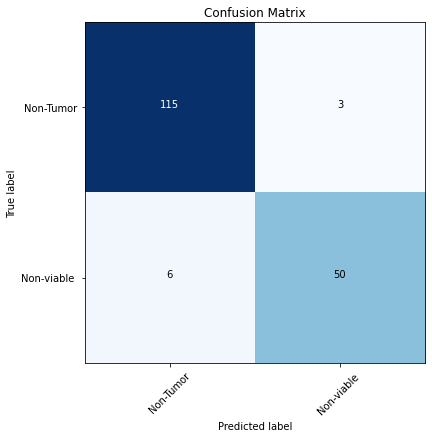

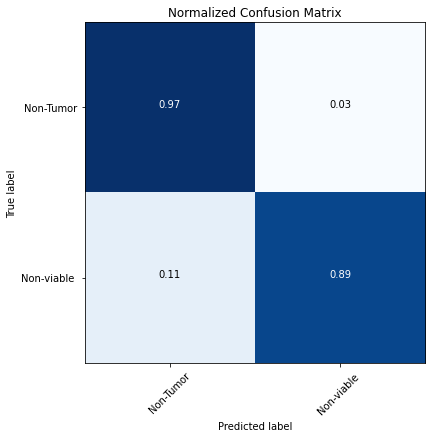

In [ ]:
classes = ['Non-Tumor', 'Non-viable ']

# getting classsification reports
get_reports(test_y_b2, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_pred)

### Using MIG

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

#### MIG 100

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=100)

# fit to selector
X_train_ig = select.fit_transform(X_train_b2, train_y_b2)
X_test_ig = select.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 100)
After applying Mututal information gain, shape for test data:  (174, 100)
k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.948
ROC-AUC score is:  0.976
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.93      0.91      0.92        56

    accuracy                           0.95       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.911   
  1       0.927     	      0.911      	   0.966   





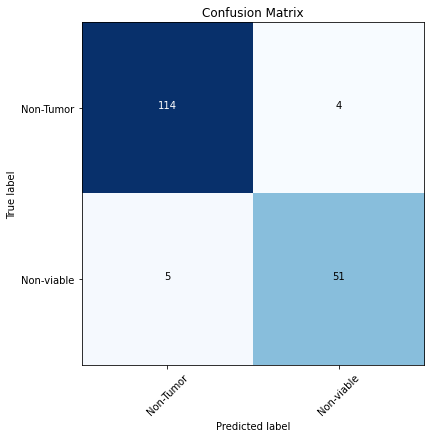

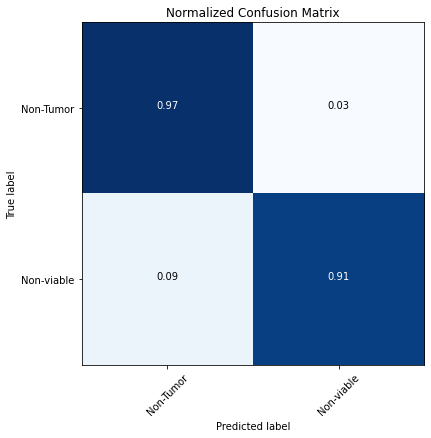

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### MIG 200

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=200)

# fit to selector
X_train_ig = select.fit_transform(X_train_b2, train_y_b2)
X_test_ig = select.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 200)
After applying Mututal information gain, shape for test data:  (174, 200)
k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.948
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.93      0.91      0.92        56

    accuracy                           0.95       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.911   
  1       0.927     	      0.911      	   0.966   





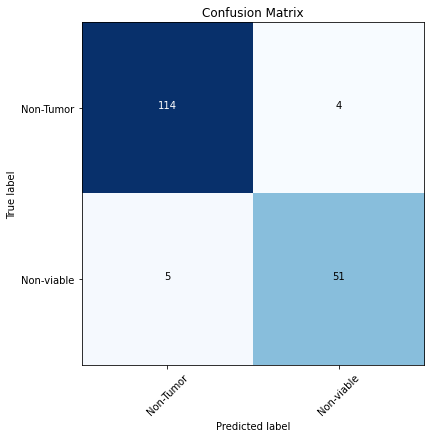

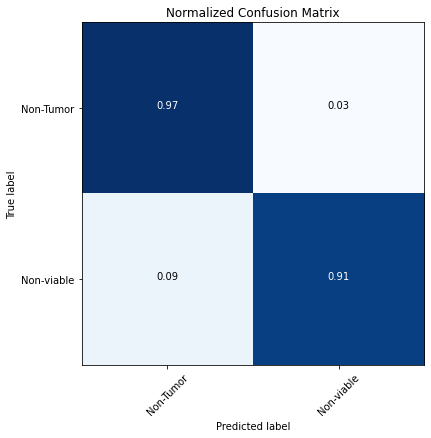

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### MIG 300

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=300)

# fit to selector
X_train_ig = select.fit_transform(X_train_b2, train_y_b2)
X_test_ig = select.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 300)
After applying Mututal information gain, shape for test data:  (174, 300)
k-fold validation accuracy for k=5 is:  0.942
Accuracy on test data is:  0.931
ROC-AUC score is:  0.973
The Matthews correlation coefficinet (MCC) is:  0.842


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       118
           1       0.89      0.89      0.89        56

    accuracy                           0.93       174
   macro avg       0.92      0.92      0.92       174
weighted avg       0.93      0.93      0.93       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.949     	      0.949      	   0.893   
  1       0.893     	      0.893      	   0.949   





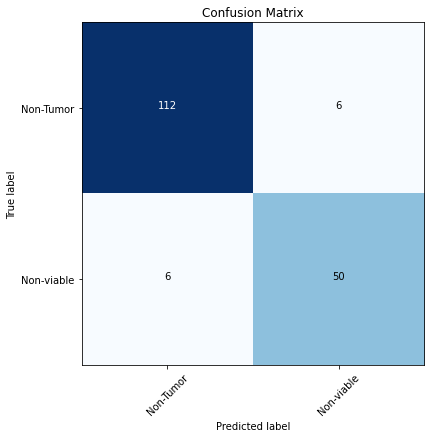

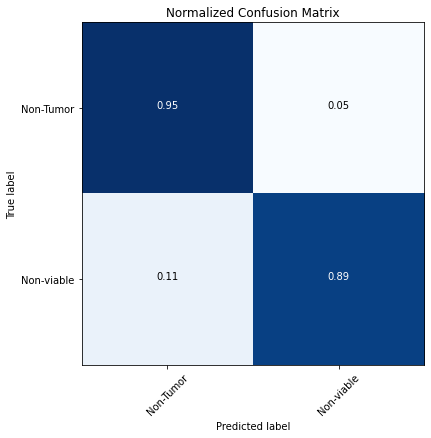

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### MIG 400

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=400)

# fit to selector
X_train_ig = select.fit_transform(X_train_b2, train_y_b2)
X_test_ig = select.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 400)
After applying Mututal information gain, shape for test data:  (174, 400)
k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.954
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.894


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.94      0.91      0.93        56

    accuracy                           0.95       174
   macro avg       0.95      0.94      0.95       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.975      	   0.911   
  1       0.944     	      0.911      	   0.975   





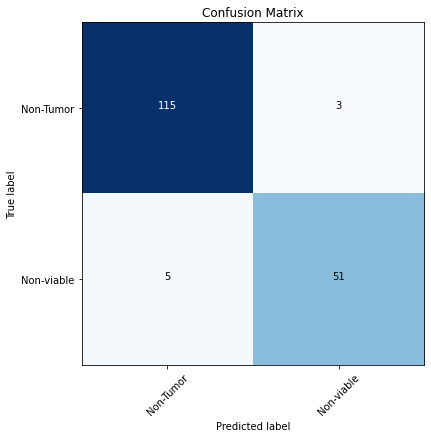

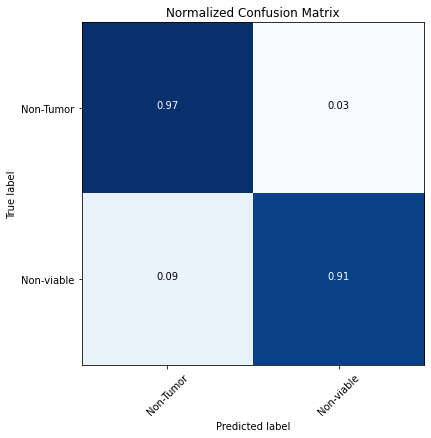

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### MIG 500

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=500)

# fit to selector
X_train_ig = select.fit_transform(X_train_b2, train_y_b2)
X_test_ig = select.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 500)
After applying Mututal information gain, shape for test data:  (174, 500)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.96
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       118
           1       0.96      0.91      0.94        56

    accuracy                           0.96       174
   macro avg       0.96      0.95      0.95       174
weighted avg       0.96      0.96      0.96       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.959     	      0.983      	   0.911   
  1       0.962     	      0.911      	   0.983   





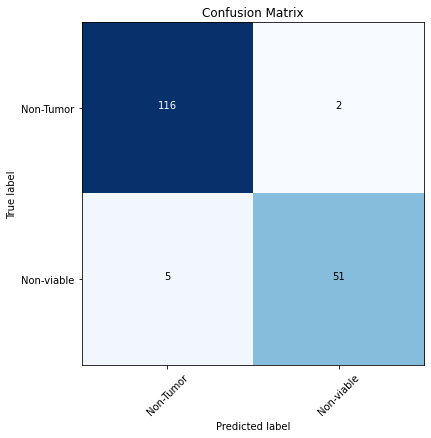

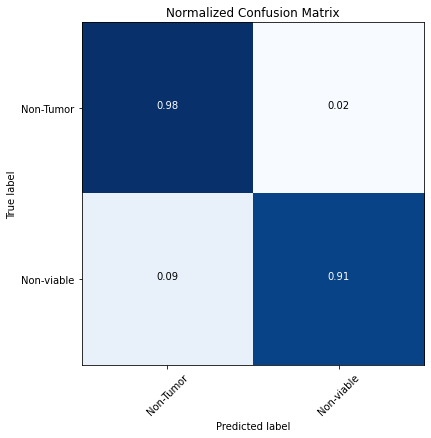

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### MIG 600

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=600)

# fit to selector
X_train_ig = select.fit_transform(X_train_b2, train_y_b2)
X_test_ig = select.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 600)
After applying Mututal information gain, shape for test data:  (174, 600)
k-fold validation accuracy for k=5 is:  0.941
Accuracy on test data is:  0.954
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.895


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.93      0.93      0.93        56

    accuracy                           0.95       174
   macro avg       0.95      0.95      0.95       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.966     	      0.966      	   0.929   
  1       0.929     	      0.929      	   0.966   





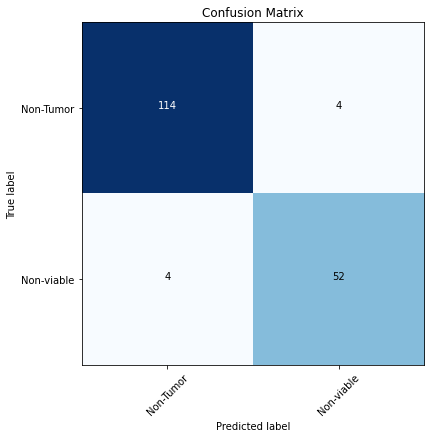

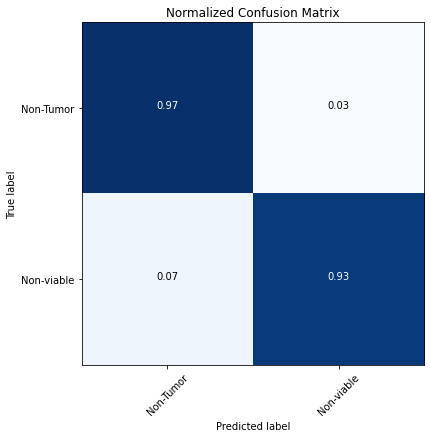

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### MIG 700

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=700)

# fit to selector
X_train_ig = select.fit_transform(X_train_b2, train_y_b2)
X_test_ig = select.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 700)
After applying Mututal information gain, shape for test data:  (174, 700)
k-fold validation accuracy for k=5 is:  0.942
Accuracy on test data is:  0.966
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       118
           1       0.96      0.93      0.95        56

    accuracy                           0.97       174
   macro avg       0.96      0.96      0.96       174
weighted avg       0.97      0.97      0.97       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.967     	      0.983      	   0.929   
  1       0.963     	      0.929      	   0.983   





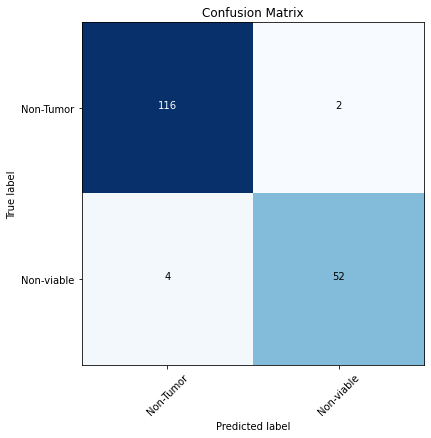

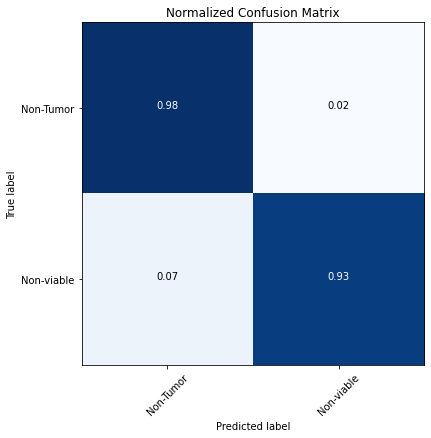

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### MIG 800

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=800)

# fit to selector
X_train_ig = select.fit_transform(X_train_b2, train_y_b2)
X_test_ig = select.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 800)
After applying Mututal information gain, shape for test data:  (174, 800)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.966
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       118
           1       0.96      0.93      0.95        56

    accuracy                           0.97       174
   macro avg       0.96      0.96      0.96       174
weighted avg       0.97      0.97      0.97       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.967     	      0.983      	   0.929   
  1       0.963     	      0.929      	   0.983   





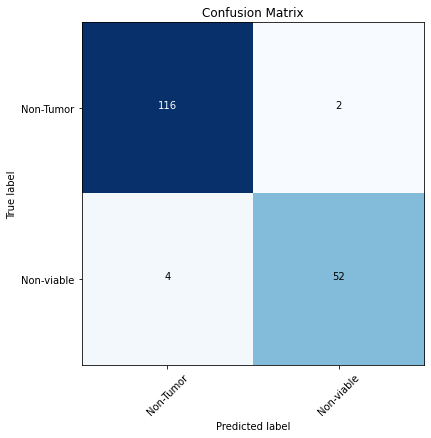

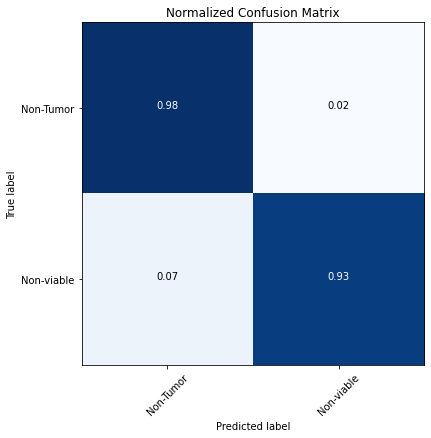

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### MIG 900

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=900)

# fit to selector
X_train_ig = select.fit_transform(X_train_b2, train_y_b2)
X_test_ig = select.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 900)
After applying Mututal information gain, shape for test data:  (174, 900)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.948
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.93      0.91      0.92        56

    accuracy                           0.95       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.911   
  1       0.927     	      0.911      	   0.966   





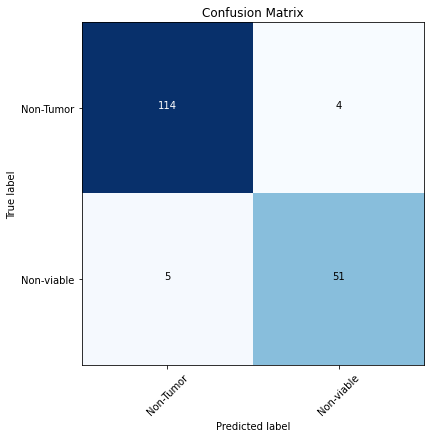

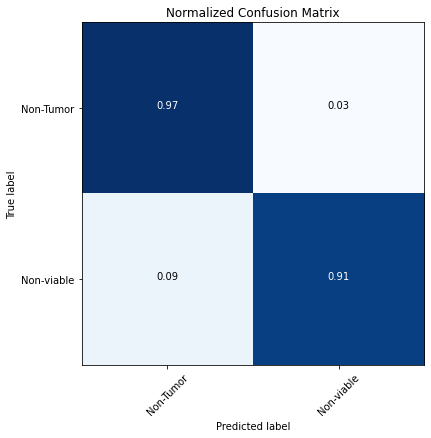

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

### Using RFE

#### RFE 100

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=100)

# fit our train data into RFE 
rfe.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b2)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 100)
After applying Mututal information gain, shape for test data:  (174, 100)
k-fold validation accuracy for k=5 is:  0.934
Accuracy on test data is:  0.966
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       118
           1       0.96      0.93      0.95        56

    accuracy                           0.97       174
   macro avg       0.96      0.96      0.96       174
weighted avg       0.97      0.97      0.97       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.967     	      0.983      	   0.929   
  1       0.963     	      0.929      	   0.983   





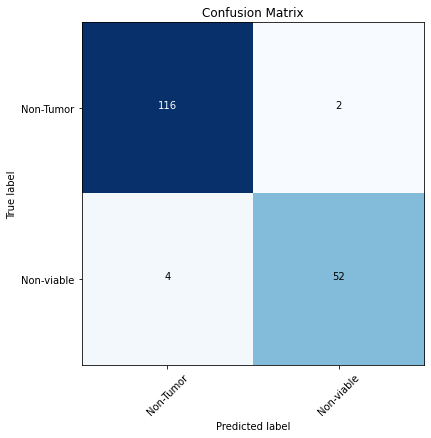

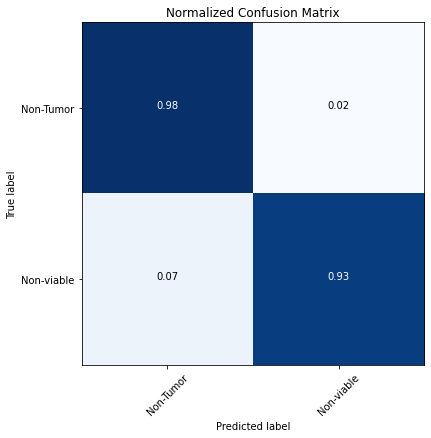

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### RFE 200

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=200)

# fit our train data into RFE 
rfe.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b2)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 200)
After applying Mututal information gain, shape for test data:  (174, 200)
k-fold validation accuracy for k=5 is:  0.942
Accuracy on test data is:  0.966
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       118
           1       0.96      0.93      0.95        56

    accuracy                           0.97       174
   macro avg       0.96      0.96      0.96       174
weighted avg       0.97      0.97      0.97       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.967     	      0.983      	   0.929   
  1       0.963     	      0.929      	   0.983   





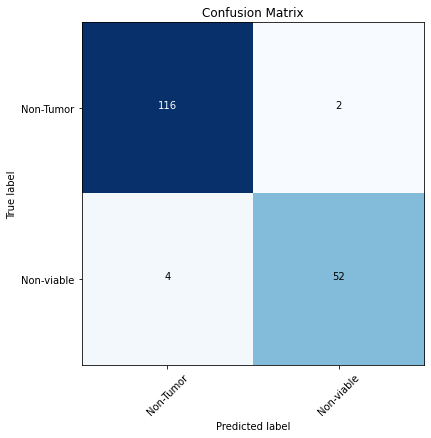

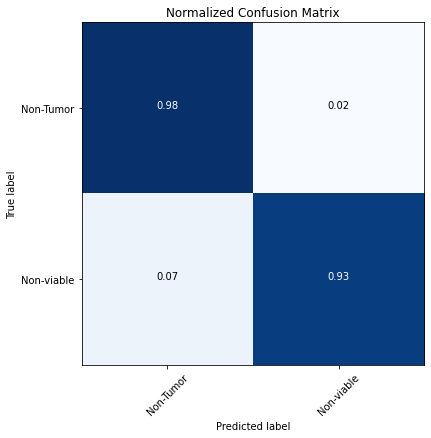

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### RFE 300

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=300)

# fit our train data into RFE 
rfe.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b2)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 300)
After applying Mututal information gain, shape for test data:  (174, 300)
k-fold validation accuracy for k=5 is:  0.936
Accuracy on test data is:  0.96
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       118
           1       0.96      0.91      0.94        56

    accuracy                           0.96       174
   macro avg       0.96      0.95      0.95       174
weighted avg       0.96      0.96      0.96       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.959     	      0.983      	   0.911   
  1       0.962     	      0.911      	   0.983   





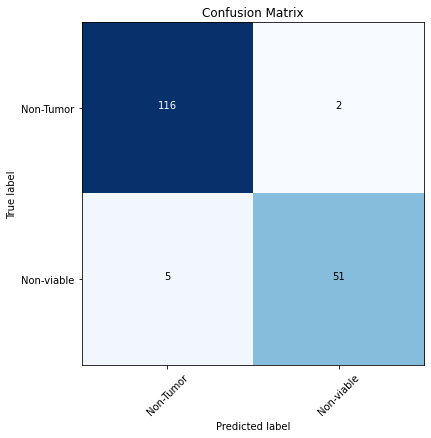

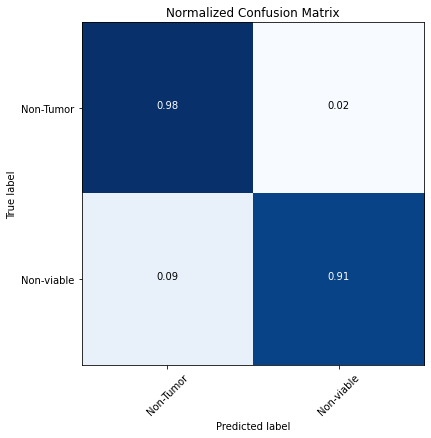

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### RFE 400

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=400)

# fit our train data into RFE 
rfe.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b2)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 400)
After applying Mututal information gain, shape for test data:  (174, 400)
k-fold validation accuracy for k=5 is:  0.941
Accuracy on test data is:  0.954
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.894


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       118
           1       0.96      0.89      0.93        56

    accuracy                           0.95       174
   macro avg       0.96      0.94      0.95       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.951     	      0.983      	   0.893   
  1       0.962     	      0.893      	   0.983   





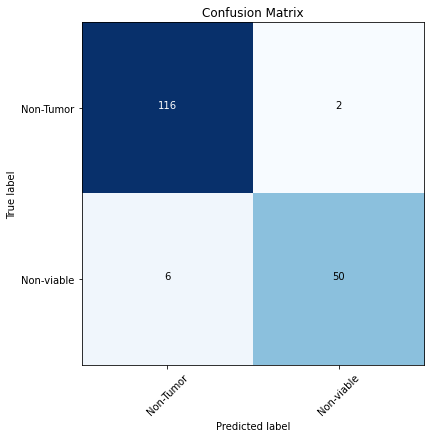

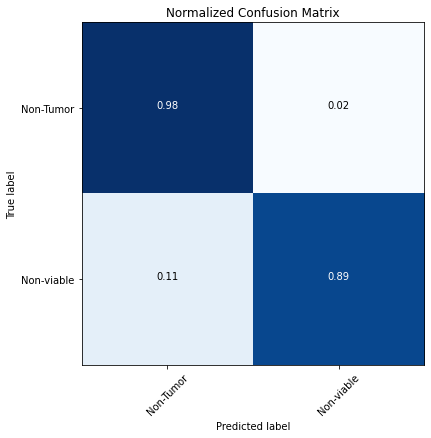

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### RFE 500

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=500)

# fit our train data into RFE 
rfe.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b2)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 500)
After applying Mututal information gain, shape for test data:  (174, 500)
k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.96
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       118
           1       0.96      0.91      0.94        56

    accuracy                           0.96       174
   macro avg       0.96      0.95      0.95       174
weighted avg       0.96      0.96      0.96       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.959     	      0.983      	   0.911   
  1       0.962     	      0.911      	   0.983   





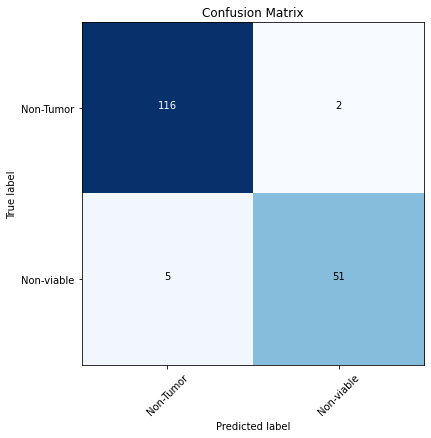

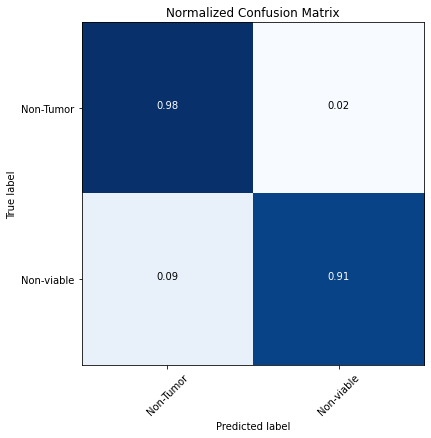

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### RFE 600

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=600)

# fit our train data into RFE 
rfe.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b2)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 600)
After applying Mututal information gain, shape for test data:  (174, 600)
k-fold validation accuracy for k=5 is:  0.941
Accuracy on test data is:  0.943
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.867


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.93      0.89      0.91        56

    accuracy                           0.94       174
   macro avg       0.94      0.93      0.93       174
weighted avg       0.94      0.94      0.94       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.966      	   0.893   
  1       0.926     	      0.893      	   0.966   





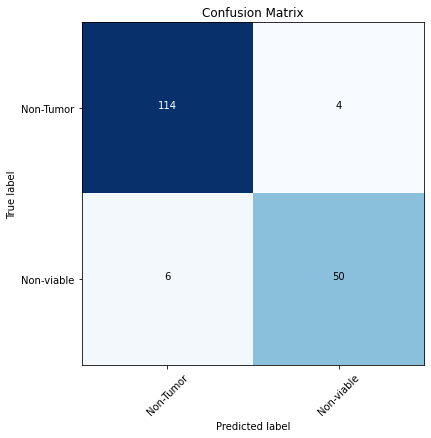

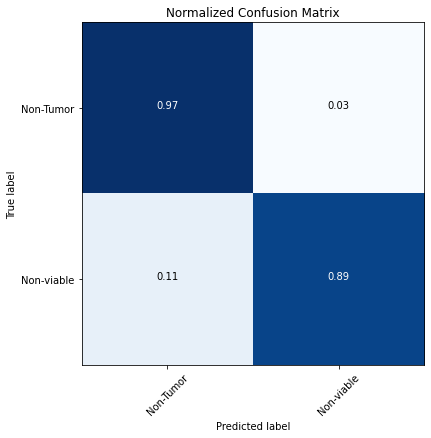

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### RFE 700

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=700)

# fit our train data into RFE 
rfe.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b2)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 700)
After applying Mututal information gain, shape for test data:  (174, 700)
k-fold validation accuracy for k=5 is:  0.95
Accuracy on test data is:  0.948
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.93      0.91      0.92        56

    accuracy                           0.95       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.911   
  1       0.927     	      0.911      	   0.966   





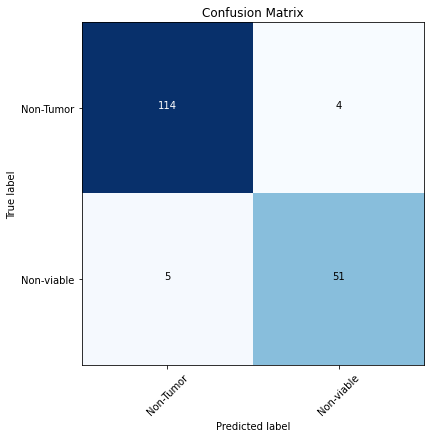

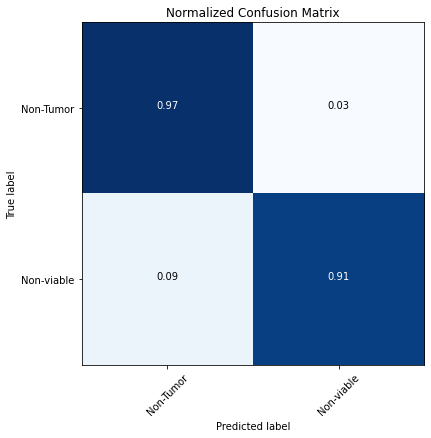

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### RFE 800

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=800)

# fit our train data into RFE 
rfe.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b2)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 800)
After applying Mututal information gain, shape for test data:  (174, 800)
k-fold validation accuracy for k=5 is:  0.941
Accuracy on test data is:  0.954
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.894


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.94      0.91      0.93        56

    accuracy                           0.95       174
   macro avg       0.95      0.94      0.95       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.975      	   0.911   
  1       0.944     	      0.911      	   0.975   





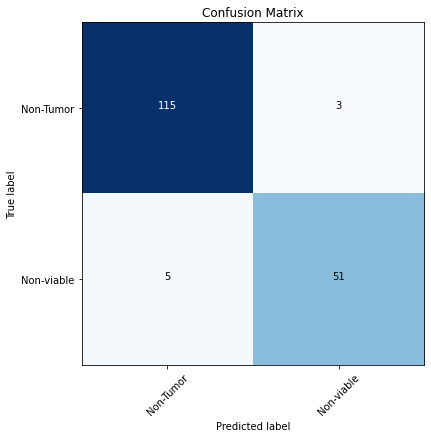

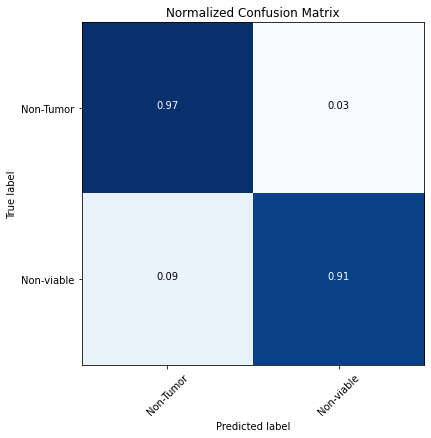

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### RFE 900

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=900)

# fit our train data into RFE 
rfe.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b2)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 900)
After applying Mututal information gain, shape for test data:  (174, 900)
k-fold validation accuracy for k=5 is:  0.941
Accuracy on test data is:  0.948
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.94      0.89      0.92        56

    accuracy                           0.95       174
   macro avg       0.95      0.93      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.975      	   0.893   
  1       0.943     	      0.893      	   0.975   





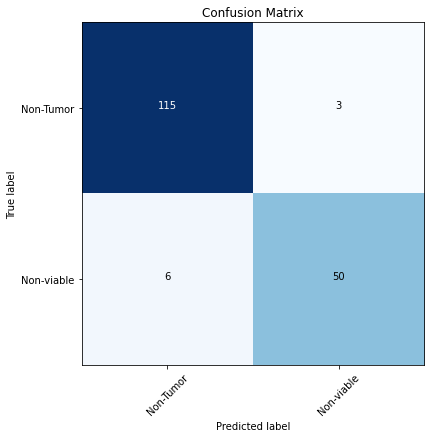

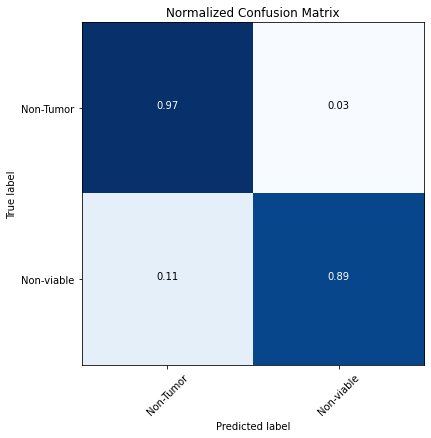

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

### Univariate

#### 100

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=100)
selector.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_uv = selector.transform(X_train_b2)

# getting transformed test features
X_test_uv = selector.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 100)
After applying Mututal information gain, shape for test data:  (174, 100)
k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.943
ROC-AUC score is:  0.975
The Matthews correlation coefficinet (MCC) is:  0.867


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.93      0.89      0.91        56

    accuracy                           0.94       174
   macro avg       0.94      0.93      0.93       174
weighted avg       0.94      0.94      0.94       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.966      	   0.893   
  1       0.926     	      0.893      	   0.966   





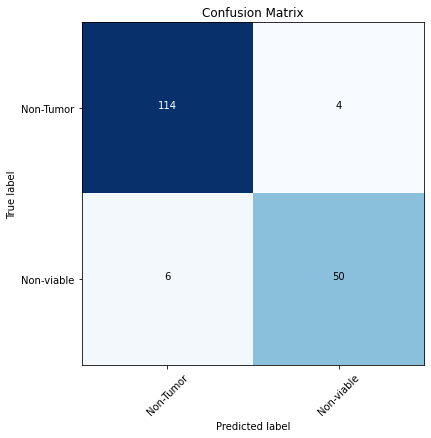

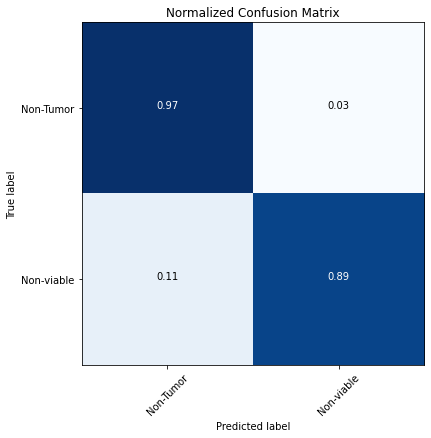

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### 200

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=200)
selector.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_uv = selector.transform(X_train_b2)

# getting transformed test features
X_test_uv = selector.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 200)
After applying Mututal information gain, shape for test data:  (174, 200)
k-fold validation accuracy for k=5 is:  0.941
Accuracy on test data is:  0.948
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.93      0.91      0.92        56

    accuracy                           0.95       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.911   
  1       0.927     	      0.911      	   0.966   





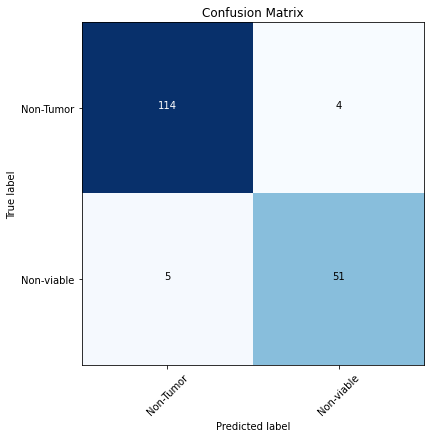

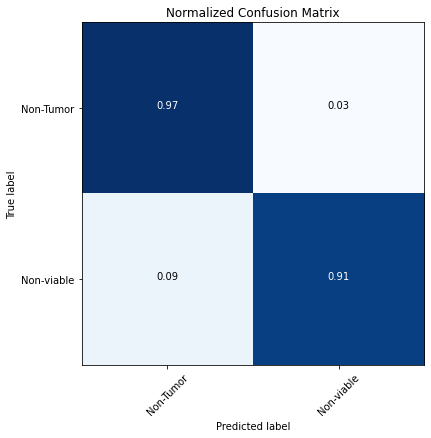

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### 300

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=300)
selector.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_uv = selector.transform(X_train_b2)

# getting transformed test features
X_test_uv = selector.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 300)
After applying Mututal information gain, shape for test data:  (174, 300)
k-fold validation accuracy for k=5 is:  0.942
Accuracy on test data is:  0.96
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.907


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.95      0.93      0.94        56

    accuracy                           0.96       174
   macro avg       0.96      0.95      0.95       174
weighted avg       0.96      0.96      0.96       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.966     	      0.975      	   0.929   
  1       0.945     	      0.929      	   0.975   





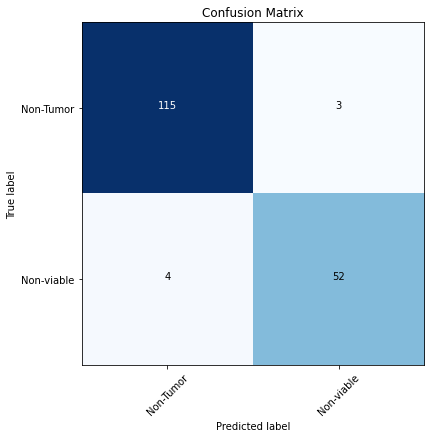

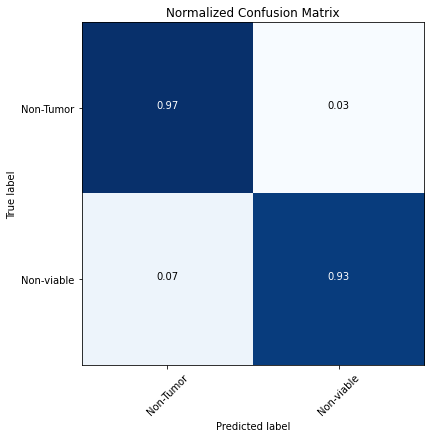

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### 400

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=400)
selector.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_uv = selector.transform(X_train_b2)

# getting transformed test features
X_test_uv = selector.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 400)
After applying Mututal information gain, shape for test data:  (174, 400)
k-fold validation accuracy for k=5 is:  0.936
Accuracy on test data is:  0.948
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.93      0.91      0.92        56

    accuracy                           0.95       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.911   
  1       0.927     	      0.911      	   0.966   





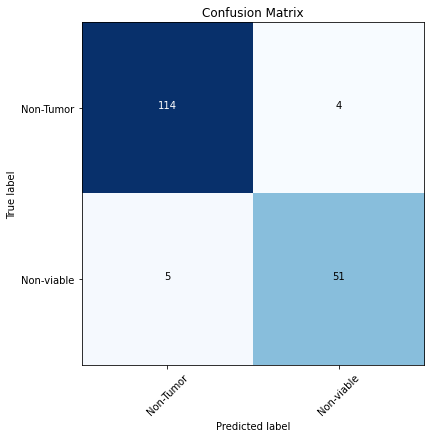

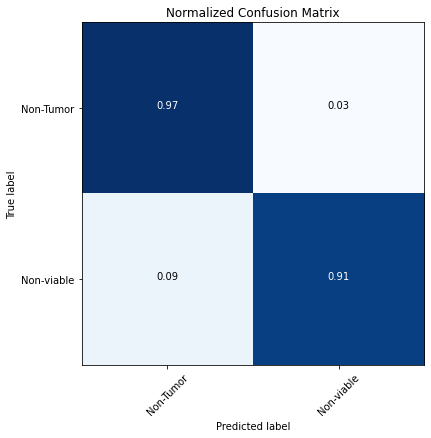

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### 500

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=500)
selector.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_uv = selector.transform(X_train_b2)

# getting transformed test features
X_test_uv = selector.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 500)
After applying Mututal information gain, shape for test data:  (174, 500)
k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.966
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.921


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       118
           1       0.98      0.91      0.94        56

    accuracy                           0.97       174
   macro avg       0.97      0.95      0.96       174
weighted avg       0.97      0.97      0.97       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.959     	      0.992      	   0.911   
  1       0.981     	      0.911      	   0.992   





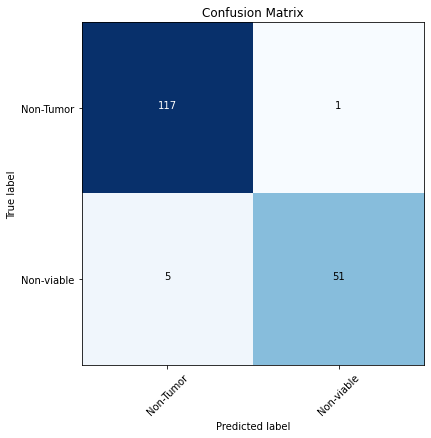

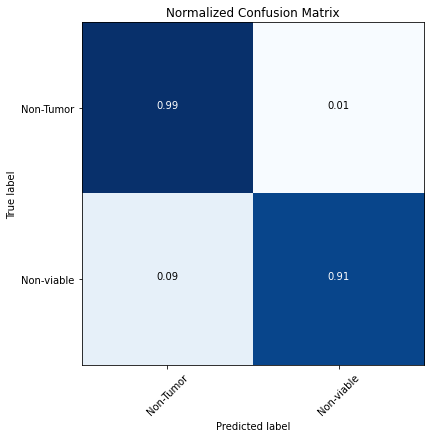

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### 600

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=600)
selector.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_uv = selector.transform(X_train_b2)

# getting transformed test features
X_test_uv = selector.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 600)
After applying Mututal information gain, shape for test data:  (174, 600)
k-fold validation accuracy for k=5 is:  0.942
Accuracy on test data is:  0.948
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       118
           1       0.94      0.89      0.92        56

    accuracy                           0.95       174
   macro avg       0.95      0.93      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.95     	      0.975      	   0.893   
  1       0.943     	      0.893      	   0.975   





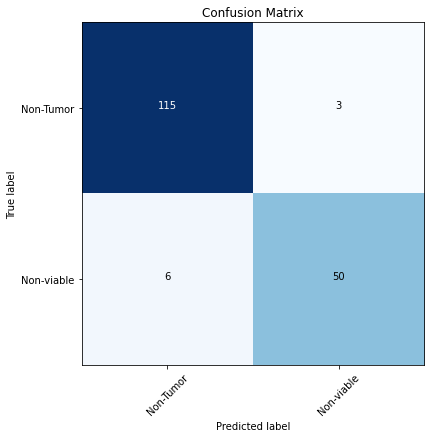

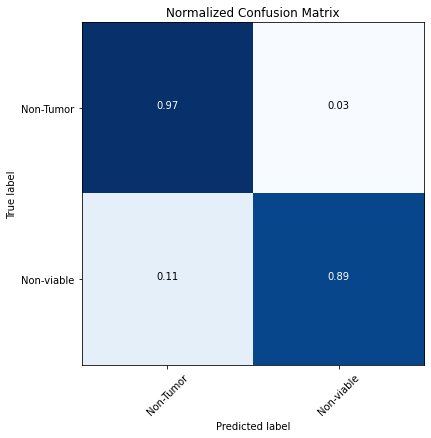

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### 700

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=700)
selector.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_uv = selector.transform(X_train_b2)

# getting transformed test features
X_test_uv = selector.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 700)
After applying Mututal information gain, shape for test data:  (174, 700)
k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.948
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.93      0.91      0.92        56

    accuracy                           0.95       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.911   
  1       0.927     	      0.911      	   0.966   





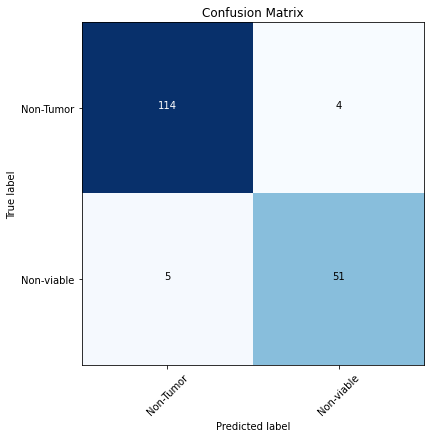

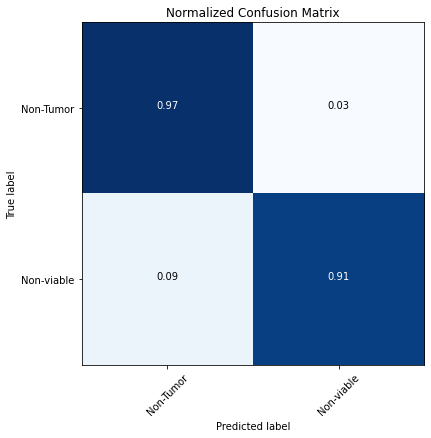

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### 800

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=800)
selector.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_uv = selector.transform(X_train_b2)

# getting transformed test features
X_test_uv = selector.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 800)
After applying Mututal information gain, shape for test data:  (174, 800)
k-fold validation accuracy for k=5 is:  0.942
Accuracy on test data is:  0.948
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.881


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.93      0.91      0.92        56

    accuracy                           0.95       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.966      	   0.911   
  1       0.927     	      0.911      	   0.966   





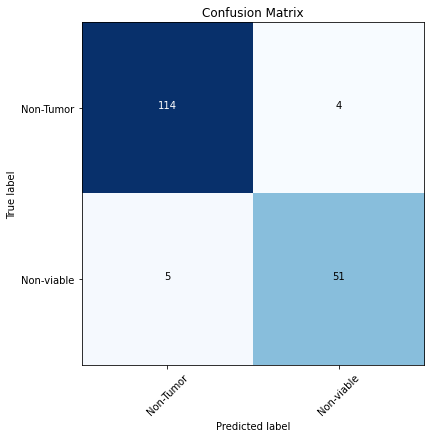

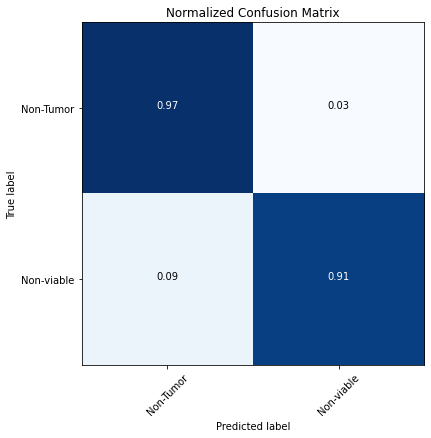

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

#### 900

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=900)
selector.fit(X_train_b2, train_y_b2)

# getting transformed train features
X_train_uv = selector.transform(X_train_b2)

# getting transformed test features
X_test_uv = selector.transform(X_test_b2)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (625, 900)
After applying Mututal information gain, shape for test data:  (174, 900)
k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.954
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.894


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       118
           1       0.94      0.91      0.93        56

    accuracy                           0.95       174
   macro avg       0.95      0.94      0.95       174
weighted avg       0.95      0.95      0.95       174




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.975      	   0.911   
  1       0.944     	      0.911      	   0.975   





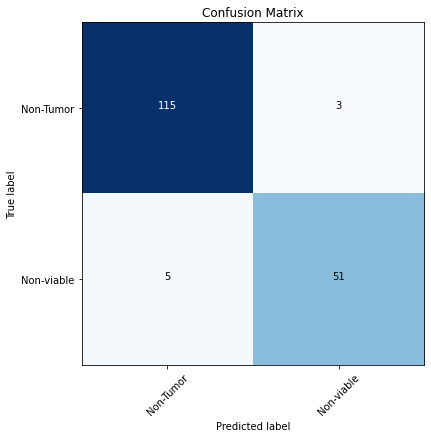

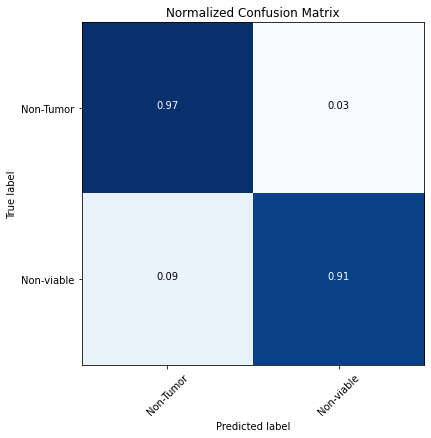

In [ ]:
classes = ['Non-Tumor', 'Non-viable']

# getting classsification reports
get_reports(test_y_b2, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b2, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b2, mlp_p)

## Non-tumor VS Viable tumor

In [ ]:
# train set and labels = train_x_b3, train_y_b3
# test set and labels = test_x_b3, test_y_b3
# total train samples 710

### Using PCA 

Text(0, 0.5, 'Cum variance')

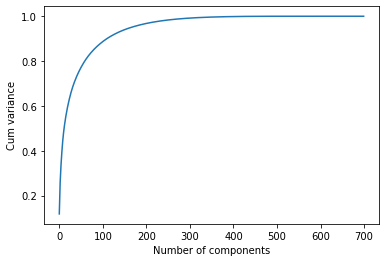

In [ ]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components= 700)  # n_components must be between: min(n_samples, n_features)
pca_test.fit(X_train_b3)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

#### PCA 100

In [ ]:
pca = PCA(n_components= 100)

X_train_pca = pca.fit_transform(X_train_b3)
X_test_pca = pca.transform(X_test_b3)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b3.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b3.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b3, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b3, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (710, 1024) 	after PCA-  (710, 100)
Test features shape:	before PCA-  (172, 1024) 	after PCA-  (172, 100)
k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.983
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.959


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       118
           2       0.98      0.96      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.983     	      0.992      	   0.963   
  1       0.981     	      0.963      	   0.992   





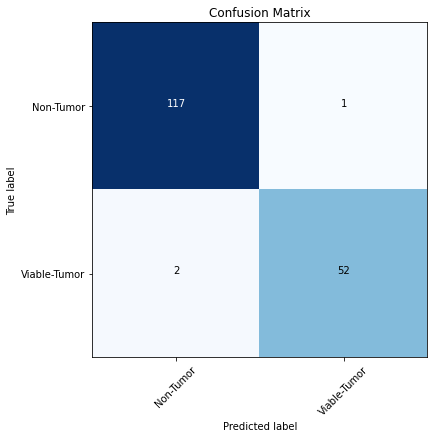

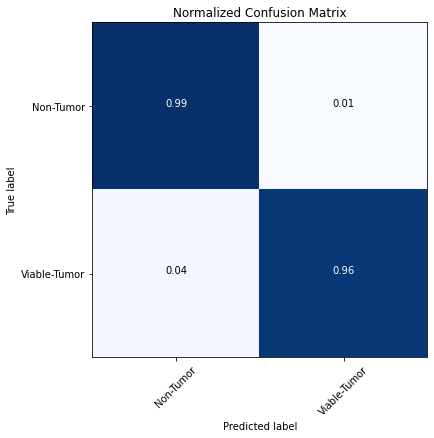

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_pred)

#### PCA 200

In [ ]:
pca = PCA(n_components= 200)

X_train_pca = pca.fit_transform(X_train_b3)
X_test_pca = pca.transform(X_test_b3)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b3.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b3.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b3, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b3, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (710, 1024) 	after PCA-  (710, 200)
Test features shape:	before PCA-  (172, 1024) 	after PCA-  (172, 200)
k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.988
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.974


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       118
           2       0.96      1.00      0.98        54

    accuracy                           0.99       172
   macro avg       0.98      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.983      	    1.0    
  1       0.964     	       1.0       	   0.983   





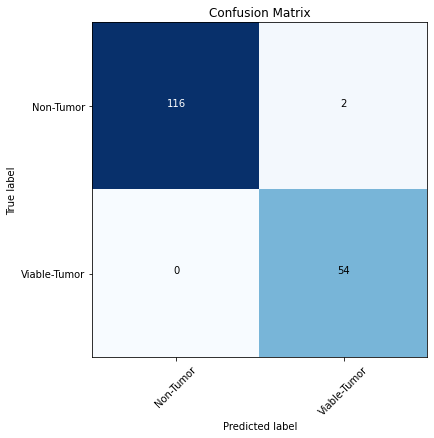

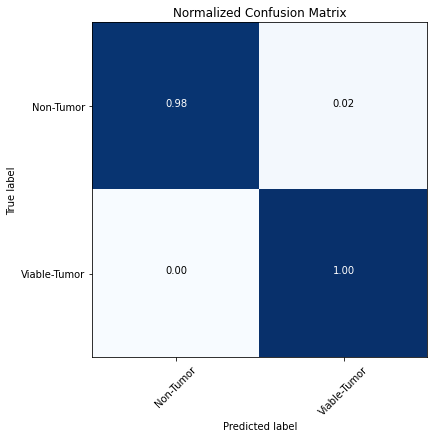

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_pred)

#### PCA 300

In [ ]:
pca = PCA(n_components= 300)

X_train_pca = pca.fit_transform(X_train_b3)
X_test_pca = pca.transform(X_test_b3)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b3.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b3.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b3, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b3, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (710, 1024) 	after PCA-  (710, 300)
Test features shape:	before PCA-  (172, 1024) 	after PCA-  (172, 300)
k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.988
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.974


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       118
           2       0.96      1.00      0.98        54

    accuracy                           0.99       172
   macro avg       0.98      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.983      	    1.0    
  1       0.964     	       1.0       	   0.983   





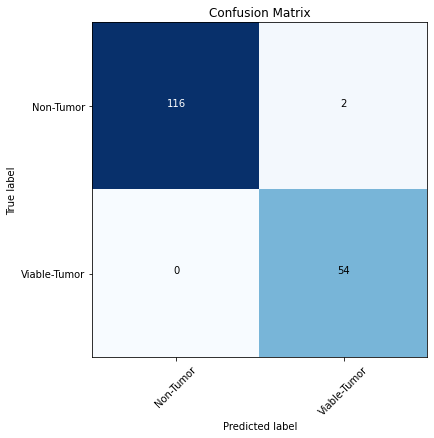

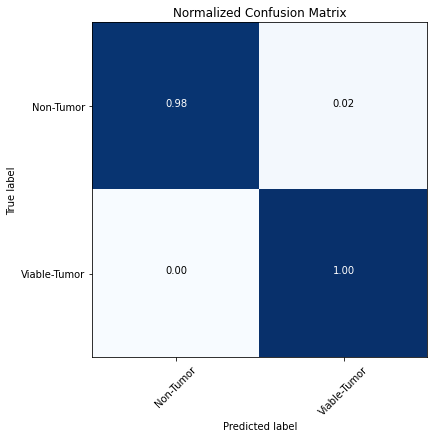

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_pred)

#### PCA 400

In [ ]:
pca = PCA(n_components= 400)

X_train_pca = pca.fit_transform(X_train_b3)
X_test_pca = pca.transform(X_test_b3)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b3.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b3.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b3, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b3, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (710, 1024) 	after PCA-  (710, 400)
Test features shape:	before PCA-  (172, 1024) 	after PCA-  (172, 400)
k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.983
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.961


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       118
           2       0.95      1.00      0.97        54

    accuracy                           0.98       172
   macro avg       0.97      0.99      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.975      	    1.0    
  1       0.947     	       1.0       	   0.975   





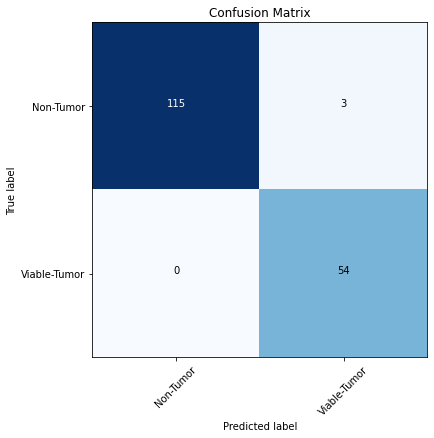

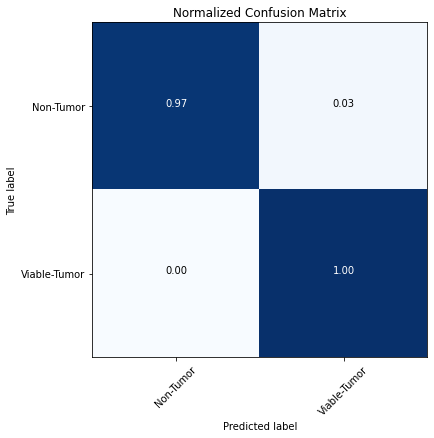

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_pred)

#### PCA 500

In [ ]:
pca = PCA(n_components= 500)

X_train_pca = pca.fit_transform(X_train_b3)
X_test_pca = pca.transform(X_test_b3)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b3.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b3.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b3, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b3, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (710, 1024) 	after PCA-  (710, 500)
Test features shape:	before PCA-  (172, 1024) 	after PCA-  (172, 500)
k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.988
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.974


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       118
           2       0.96      1.00      0.98        54

    accuracy                           0.99       172
   macro avg       0.98      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.983      	    1.0    
  1       0.964     	       1.0       	   0.983   





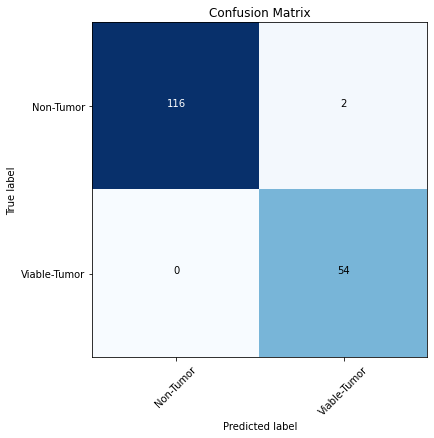

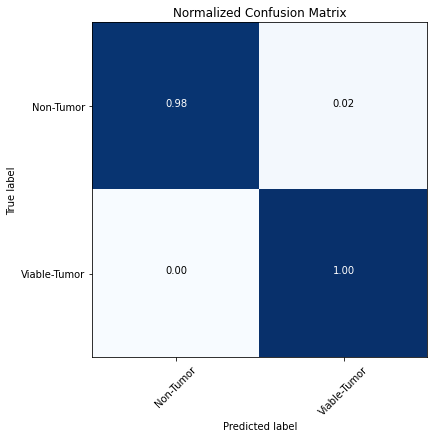

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_pred)

#### PCA 600

In [ ]:
pca = PCA(n_components= 600)

X_train_pca = pca.fit_transform(X_train_b3)
X_test_pca = pca.transform(X_test_b3)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b3.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b3.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b3, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b3, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (710, 1024) 	after PCA-  (710, 600)
Test features shape:	before PCA-  (172, 1024) 	after PCA-  (172, 600)
k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.988
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.974


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       118
           2       0.96      1.00      0.98        54

    accuracy                           0.99       172
   macro avg       0.98      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.983      	    1.0    
  1       0.964     	       1.0       	   0.983   





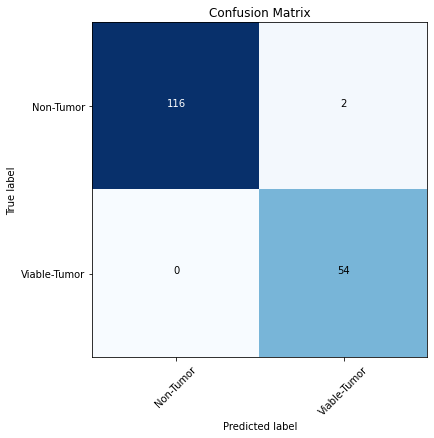

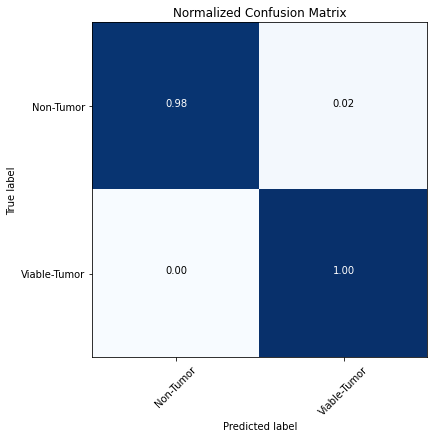

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_pred)

#### PCA 700

In [ ]:
pca = PCA(n_components= 700)

X_train_pca = pca.fit_transform(X_train_b3)
X_test_pca = pca.transform(X_test_b3)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b3.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b3.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b3, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b3, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (710, 1024) 	after PCA-  (710, 700)
Test features shape:	before PCA-  (172, 1024) 	after PCA-  (172, 700)
k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.994
ROC-AUC score is:  1.0
The Matthews correlation coefficinet (MCC) is:  0.987


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       118
           2       0.98      1.00      0.99        54

    accuracy                           0.99       172
   macro avg       0.99      1.00      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.992      	    1.0    
  1       0.982     	       1.0       	   0.992   





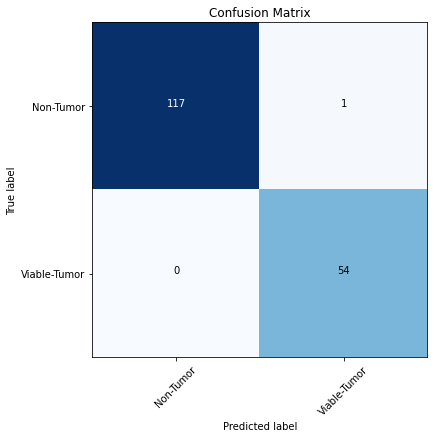

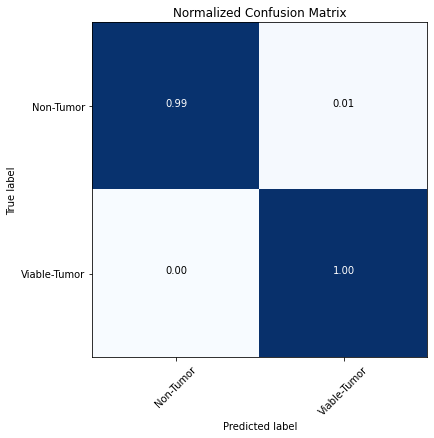

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_pred)

### Using MIG

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

#### MIG 100

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=100)

# fit to selector
X_train_ig = select.fit_transform(X_train_b3, train_y_b3)
X_test_ig = select.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 100)
After applying Mututal information gain, shape for test data:  (172, 100)
k-fold validation accuracy for k=5 is:  0.959
Accuracy on test data is:  0.971
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.934


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       118
           2       0.93      0.98      0.95        54

    accuracy                           0.97       172
   macro avg       0.96      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.966      	   0.981   
  1        0.93     	      0.981      	   0.966   





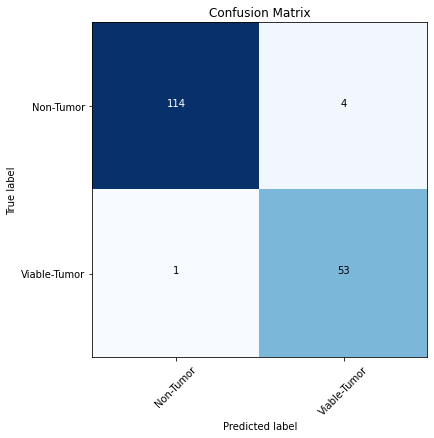

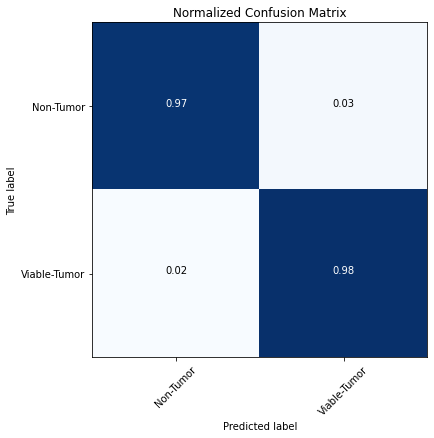

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### MIG 200

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=200)

# fit to selector
X_train_ig = select.fit_transform(X_train_b3, train_y_b3)
X_test_ig = select.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 200)
After applying Mututal information gain, shape for test data:  (172, 200)
k-fold validation accuracy for k=5 is:  0.961
Accuracy on test data is:  0.988
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.974


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       118
           2       0.96      1.00      0.98        54

    accuracy                           0.99       172
   macro avg       0.98      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.983      	    1.0    
  1       0.964     	       1.0       	   0.983   





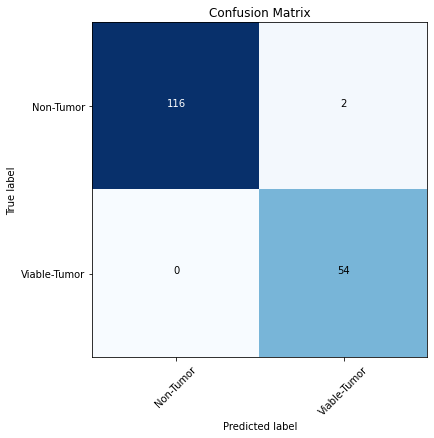

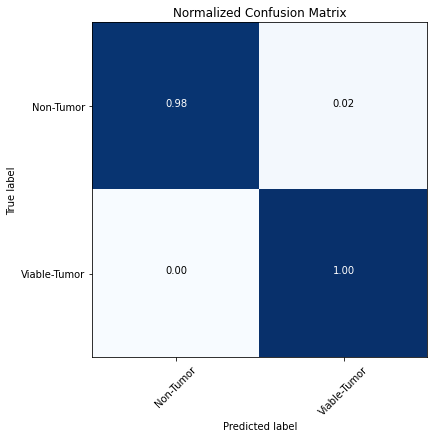

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### MIG 300

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=300)

# fit to selector
X_train_ig = select.fit_transform(X_train_b3, train_y_b3)
X_test_ig = select.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 300)
After applying Mututal information gain, shape for test data:  (172, 300)
k-fold validation accuracy for k=5 is:  0.968
Accuracy on test data is:  0.983
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.96


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       118
           2       0.96      0.98      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.983      	   0.981   
  1       0.964     	      0.981      	   0.983   





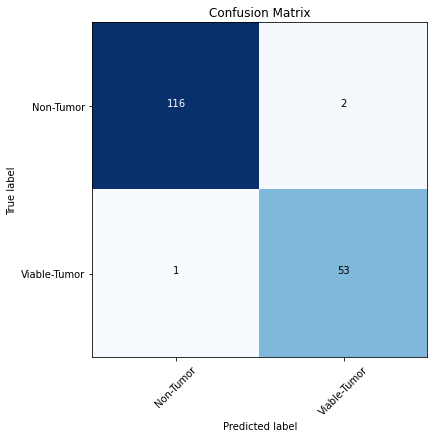

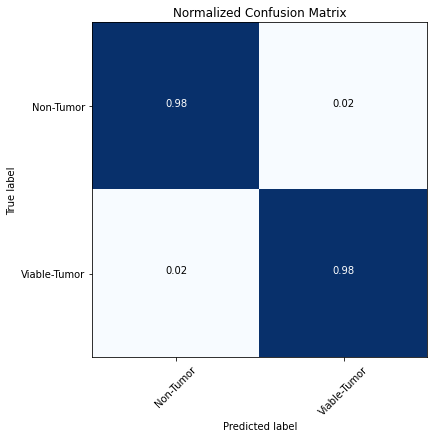

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### MIG 400

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=400)

# fit to selector
X_train_ig = select.fit_transform(X_train_b3, train_y_b3)
X_test_ig = select.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 400)
After applying Mututal information gain, shape for test data:  (172, 400)
k-fold validation accuracy for k=5 is:  0.959
Accuracy on test data is:  0.977
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.947


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       118
           2       0.95      0.98      0.96        54

    accuracy                           0.98       172
   macro avg       0.97      0.98      0.97       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.975      	   0.981   
  1       0.946     	      0.981      	   0.975   





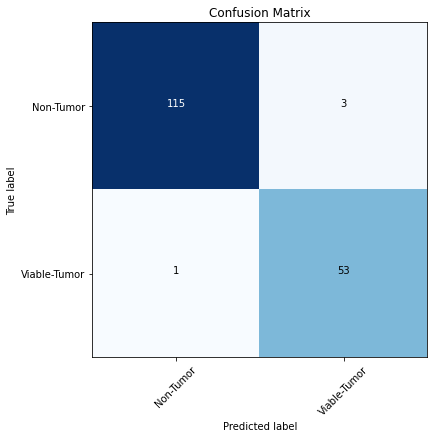

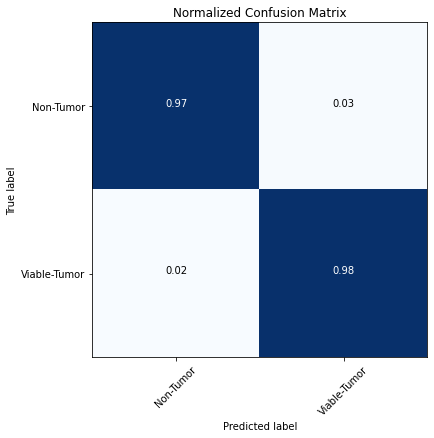

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### MIG 500

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=500)

# fit to selector
X_train_ig = select.fit_transform(X_train_b3, train_y_b3)
X_test_ig = select.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 500)
After applying Mututal information gain, shape for test data:  (172, 500)
k-fold validation accuracy for k=5 is:  0.962
Accuracy on test data is:  0.983
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.959


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       118
           2       0.98      0.96      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.983     	      0.992      	   0.963   
  1       0.981     	      0.963      	   0.992   





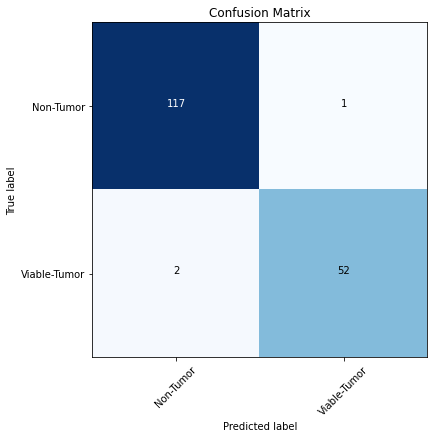

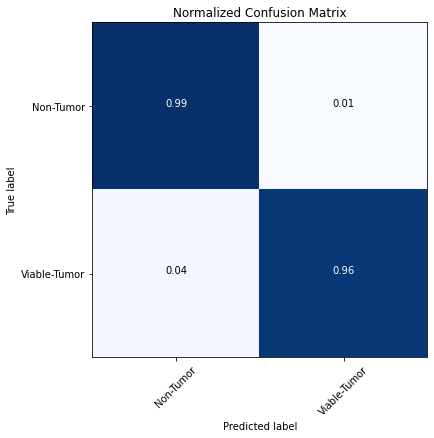

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### MIG 600

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=600)

# fit to selector
X_train_ig = select.fit_transform(X_train_b3, train_y_b3)
X_test_ig = select.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 600)
After applying Mututal information gain, shape for test data:  (172, 600)
k-fold validation accuracy for k=5 is:  0.966
Accuracy on test data is:  0.988
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.973


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       118
           2       0.98      0.98      0.98        54

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.992     	      0.992      	   0.981   
  1       0.981     	      0.981      	   0.992   





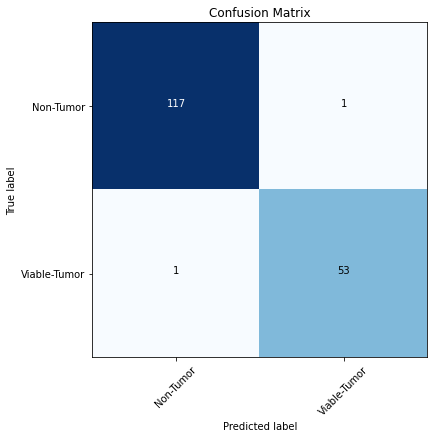

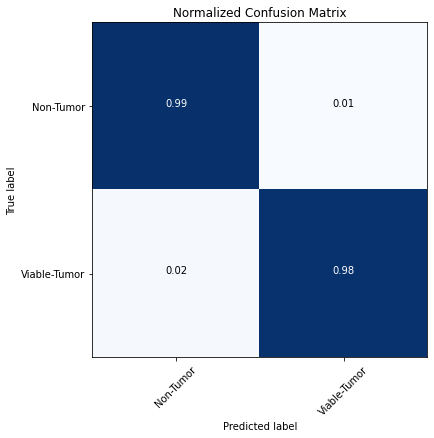

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### MIG 700

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=700)

# fit to selector
X_train_ig = select.fit_transform(X_train_b3, train_y_b3)
X_test_ig = select.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 700)
After applying Mututal information gain, shape for test data:  (172, 700)
k-fold validation accuracy for k=5 is:  0.958
Accuracy on test data is:  0.994
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.987


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       118
           2       0.98      1.00      0.99        54

    accuracy                           0.99       172
   macro avg       0.99      1.00      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.992      	    1.0    
  1       0.982     	       1.0       	   0.992   





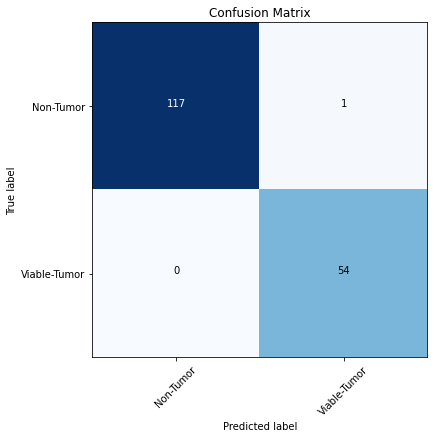

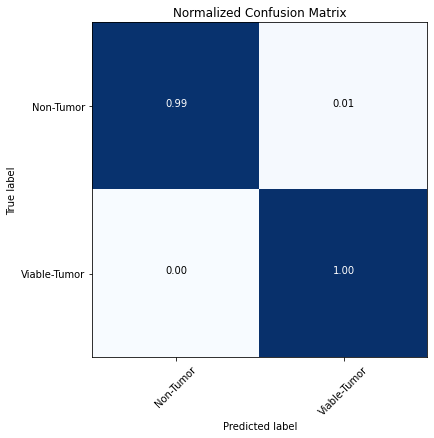

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### MIG 800

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=800)

# fit to selector
X_train_ig = select.fit_transform(X_train_b3, train_y_b3)
X_test_ig = select.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 800)
After applying Mututal information gain, shape for test data:  (172, 800)
k-fold validation accuracy for k=5 is:  0.968
Accuracy on test data is:  0.994
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.987


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       118
           2       0.98      1.00      0.99        54

    accuracy                           0.99       172
   macro avg       0.99      1.00      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.992      	    1.0    
  1       0.982     	       1.0       	   0.992   





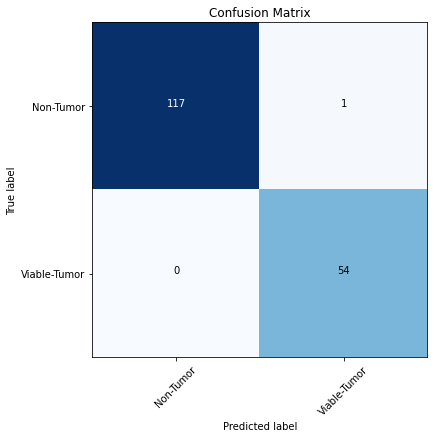

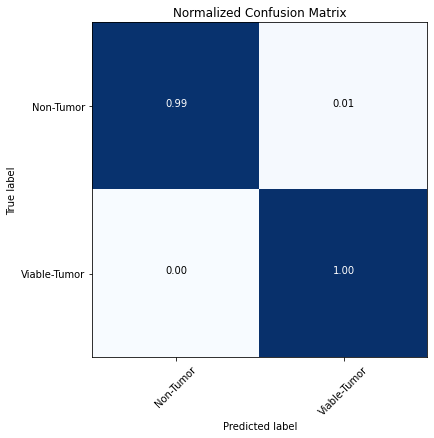

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### MIG 900

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=900)

# fit to selector
X_train_ig = select.fit_transform(X_train_b3, train_y_b3)
X_test_ig = select.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 900)
After applying Mututal information gain, shape for test data:  (172, 900)
k-fold validation accuracy for k=5 is:  0.963
Accuracy on test data is:  0.983
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.959


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       118
           2       0.98      0.96      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.983     	      0.992      	   0.963   
  1       0.981     	      0.963      	   0.992   





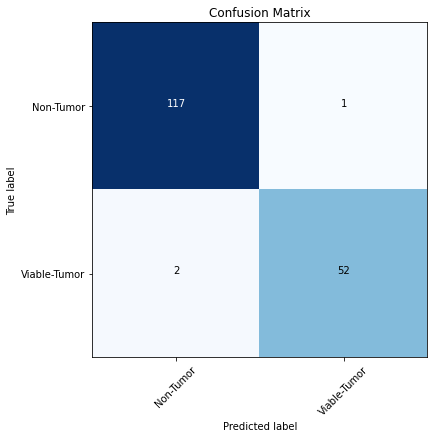

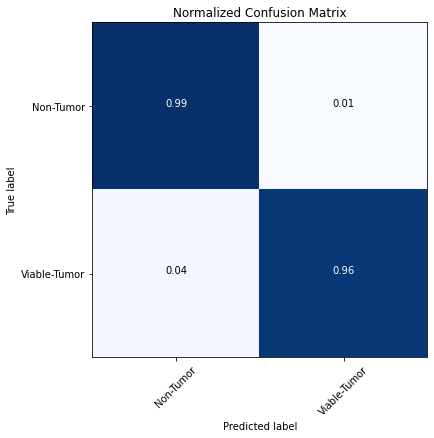

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

### Using RFE 

#### RFE 100

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=100)

# fit our train data into RFE 
rfe.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b3)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 100)
After applying Mututal information gain, shape for test data:  (172, 100)
k-fold validation accuracy for k=5 is:  0.961
Accuracy on test data is:  0.977
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.947


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       118
           2       0.95      0.98      0.96        54

    accuracy                           0.98       172
   macro avg       0.97      0.98      0.97       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.975      	   0.981   
  1       0.946     	      0.981      	   0.975   





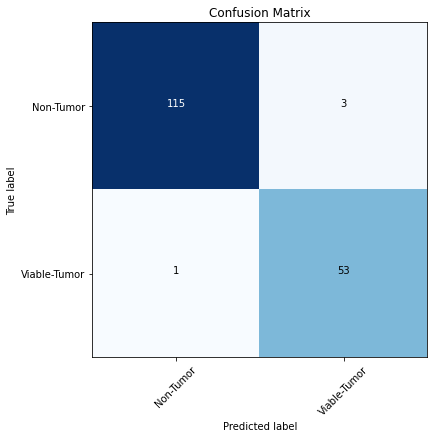

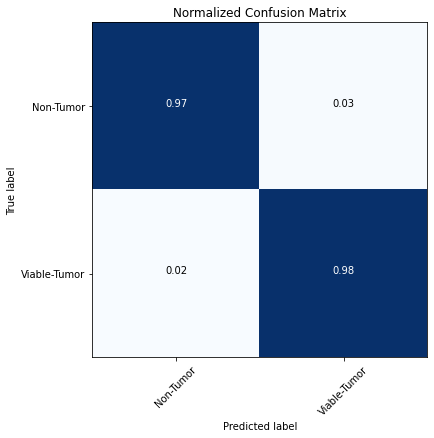

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### RFE 200

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=200)

# fit our train data into RFE 
rfe.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b3)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 200)
After applying Mututal information gain, shape for test data:  (172, 200)
k-fold validation accuracy for k=5 is:  0.968
Accuracy on test data is:  0.971
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.932


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       118
           2       0.96      0.94      0.95        54

    accuracy                           0.97       172
   macro avg       0.97      0.96      0.97       172
weighted avg       0.97      0.97      0.97       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.975     	      0.983      	   0.944   
  1       0.962     	      0.944      	   0.983   





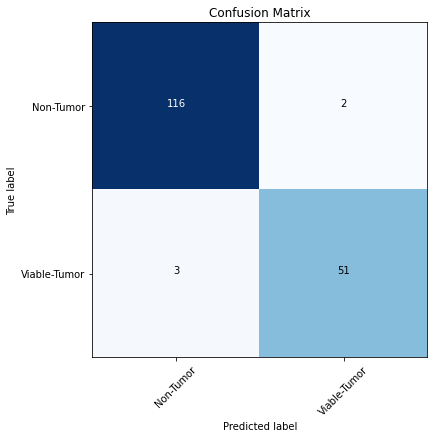

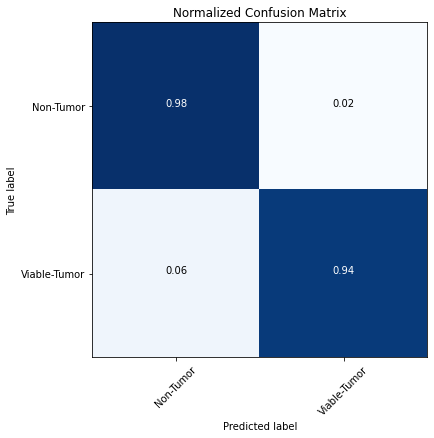

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### RFE 300

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=300)

# fit our train data into RFE 
rfe.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b3)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 300)
After applying Mututal information gain, shape for test data:  (172, 300)
k-fold validation accuracy for k=5 is:  0.955
Accuracy on test data is:  0.977
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.946


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       118
           2       0.96      0.96      0.96        54

    accuracy                           0.98       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.983     	      0.983      	   0.963   
  1       0.963     	      0.963      	   0.983   





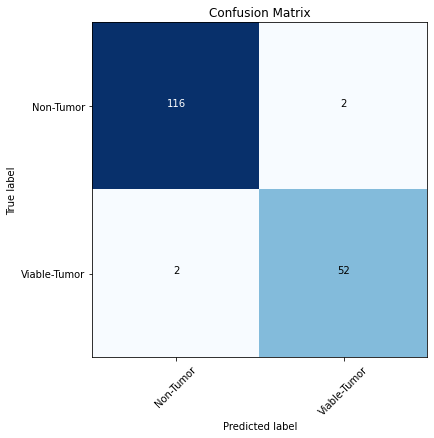

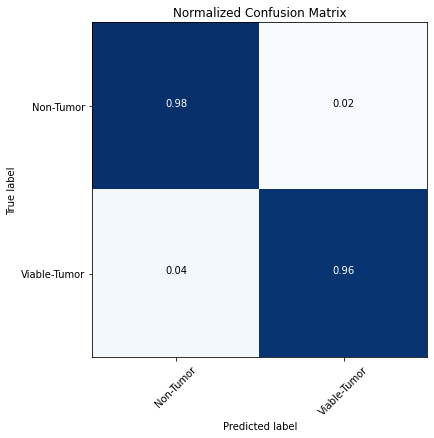

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### RFE 400

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=400)

# fit our train data into RFE 
rfe.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b3)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 400)
After applying Mututal information gain, shape for test data:  (172, 400)
k-fold validation accuracy for k=5 is:  0.969
Accuracy on test data is:  0.983
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.96


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       118
           2       0.96      0.98      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.983      	   0.981   
  1       0.964     	      0.981      	   0.983   





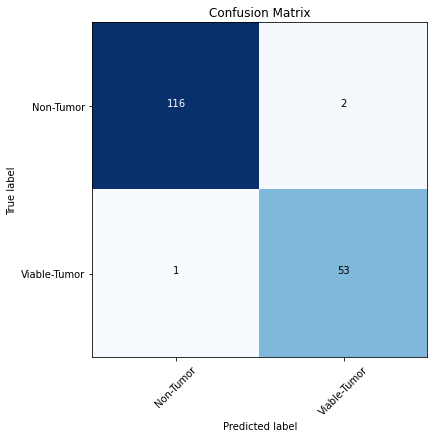

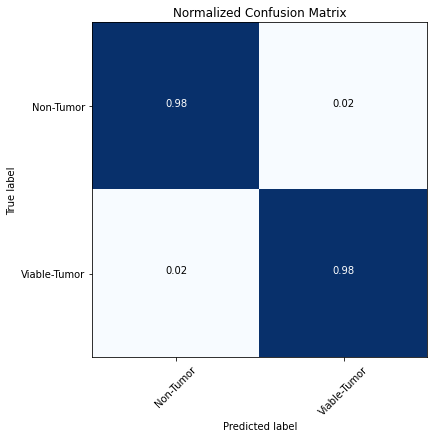

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### RFE 500

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=500)

# fit our train data into RFE 
rfe.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b3)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 500)
After applying Mututal information gain, shape for test data:  (172, 500)
k-fold validation accuracy for k=5 is:  0.963
Accuracy on test data is:  0.983
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.96


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       118
           2       0.96      0.98      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.983      	   0.981   
  1       0.964     	      0.981      	   0.983   





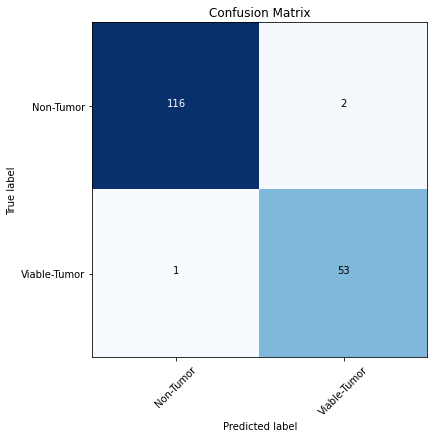

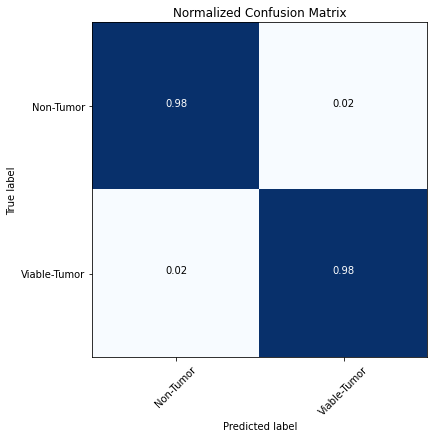

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### RFE 600

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=600)

# fit our train data into RFE 
rfe.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b3)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 600)
After applying Mututal information gain, shape for test data:  (172, 600)
k-fold validation accuracy for k=5 is:  0.963
Accuracy on test data is:  0.994
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.987


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       118
           2       0.98      1.00      0.99        54

    accuracy                           0.99       172
   macro avg       0.99      1.00      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.992      	    1.0    
  1       0.982     	       1.0       	   0.992   





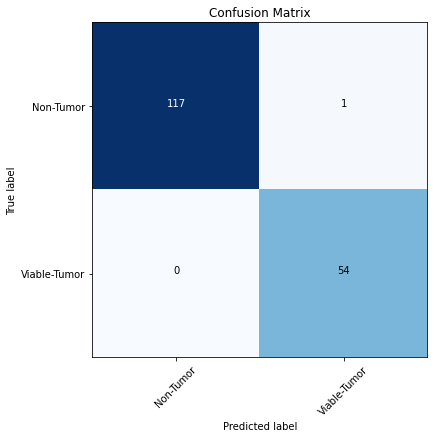

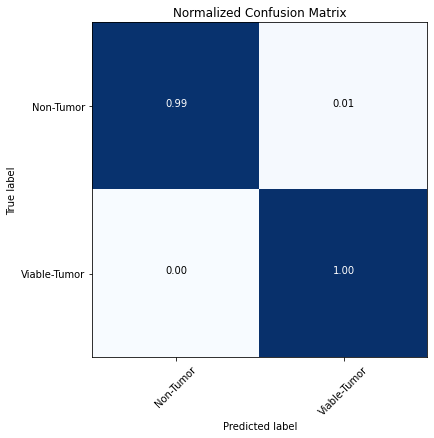

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### RFE 700

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=700)

# fit our train data into RFE 
rfe.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b3)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 700)
After applying Mututal information gain, shape for test data:  (172, 700)
k-fold validation accuracy for k=5 is:  0.965
Accuracy on test data is:  0.983
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.959


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       118
           2       0.98      0.96      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.983     	      0.992      	   0.963   
  1       0.981     	      0.963      	   0.992   





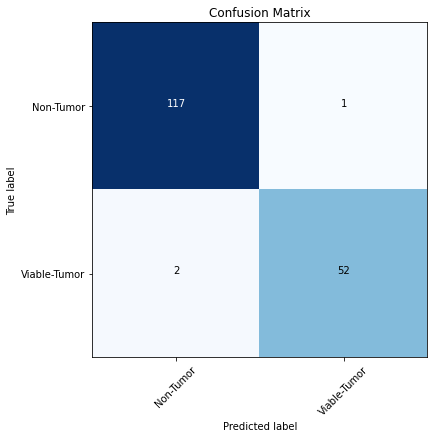

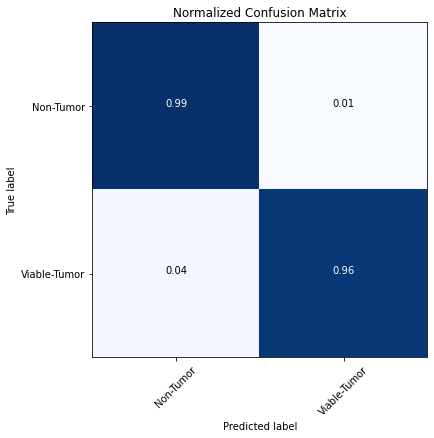

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### RFE 800

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=800)

# fit our train data into RFE 
rfe.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b3)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 800)
After applying Mututal information gain, shape for test data:  (172, 800)
k-fold validation accuracy for k=5 is:  0.965
Accuracy on test data is:  0.983
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.96


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       118
           2       0.96      0.98      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.983      	   0.981   
  1       0.964     	      0.981      	   0.983   





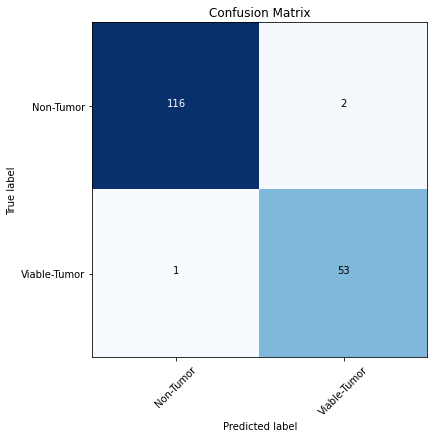

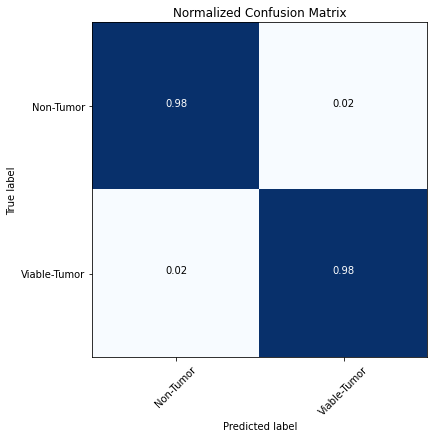

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### RFE 900

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=900)

# fit our train data into RFE 
rfe.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b3)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 900)
After applying Mututal information gain, shape for test data:  (172, 900)
k-fold validation accuracy for k=5 is:  0.97
Accuracy on test data is:  0.983
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.959


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       118
           2       0.98      0.96      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.983     	      0.992      	   0.963   
  1       0.981     	      0.963      	   0.992   





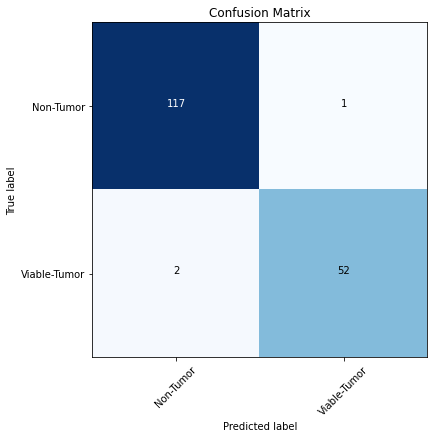

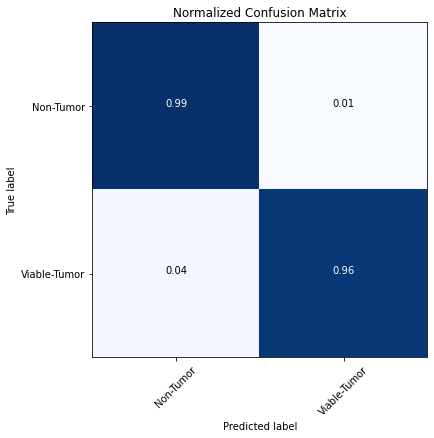

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

### Univariat

#### TBA 100

In [ ]:
# univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=100)
selector.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_uv = selector.transform(X_train_b3)

# getting transformed test features
X_test_uv = selector.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)m
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 100)
After applying Mututal information gain, shape for test data:  (172, 100)
k-fold validation accuracy for k=5 is:  0.965
Accuracy on test data is:  0.977
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       118
           2       0.95      0.98      0.96        54

    accuracy                           0.98       172
   macro avg       0.97      0.98      0.97       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.975      	   0.981   
  1       0.946     	      0.981      	   0.975   





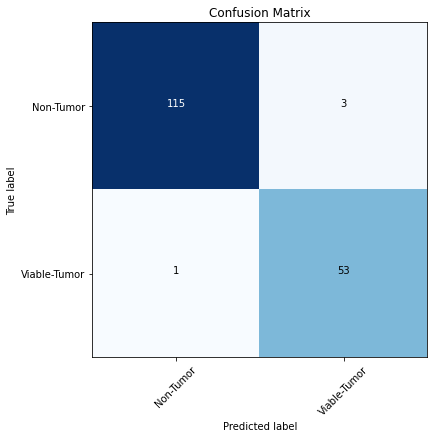

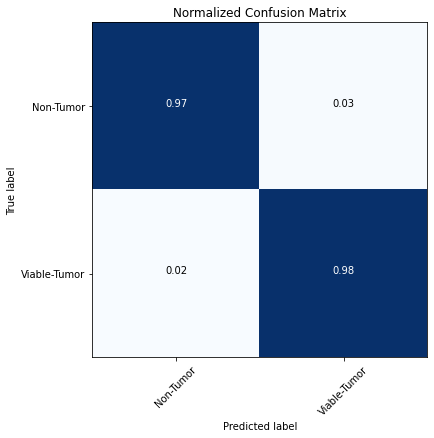

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### TBA 200

In [ ]:
# univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=200)
selector.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_uv = selector.transform(X_train_b3)

# getting transformed test features
X_test_uv = selector.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)m
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 200)
After applying Mututal information gain, shape for test data:  (172, 200)
k-fold validation accuracy for k=5 is:  0.962
Accuracy on test data is:  0.977
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.947


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       118
           2       0.95      0.98      0.96        54

    accuracy                           0.98       172
   macro avg       0.97      0.98      0.97       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.975      	   0.981   
  1       0.946     	      0.981      	   0.975   





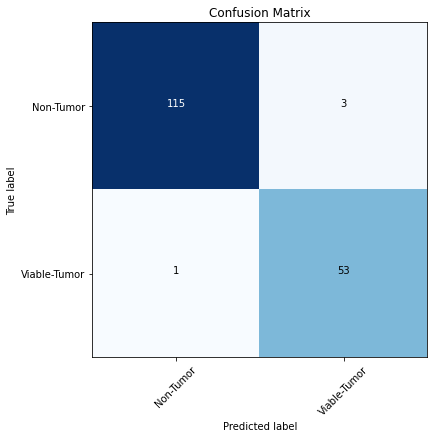

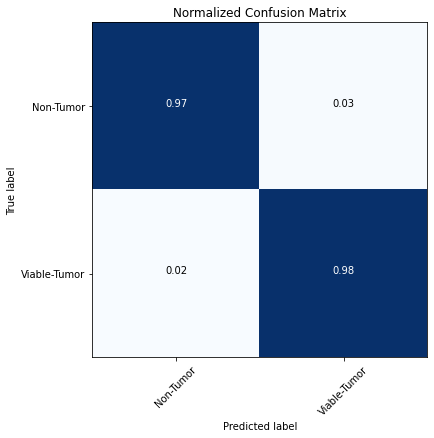

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### TBA 300

In [ ]:
# univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=300)
selector.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_uv = selector.transform(X_train_b3)

# getting transformed test features
X_test_uv = selector.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)m
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 300)
After applying Mututal information gain, shape for test data:  (172, 300)
k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.988
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.974


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       118
           2       0.96      1.00      0.98        54

    accuracy                           0.99       172
   macro avg       0.98      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.983      	    1.0    
  1       0.964     	       1.0       	   0.983   





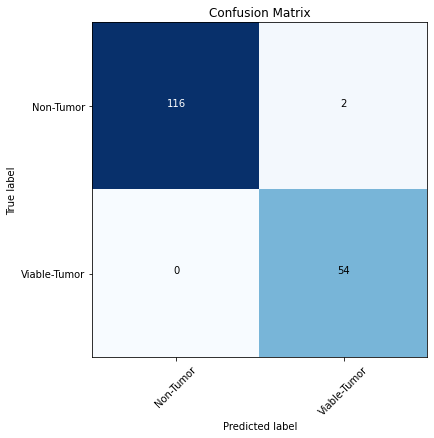

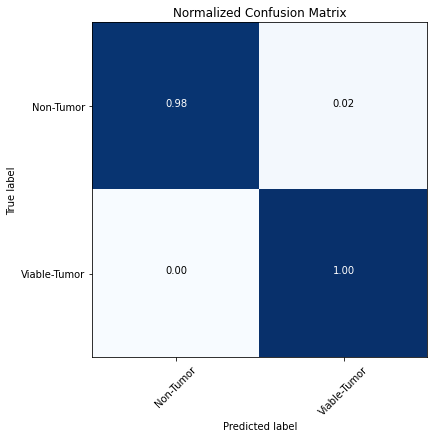

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### TBA 400

In [ ]:
# univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=400)
selector.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_uv = selector.transform(X_train_b3)

# getting transformed test features
X_test_uv = selector.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)m
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 400)
After applying Mututal information gain, shape for test data:  (172, 400)
k-fold validation accuracy for k=5 is:  0.965
Accuracy on test data is:  0.988
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.973


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       118
           2       0.98      0.98      0.98        54

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.992     	      0.992      	   0.981   
  1       0.981     	      0.981      	   0.992   





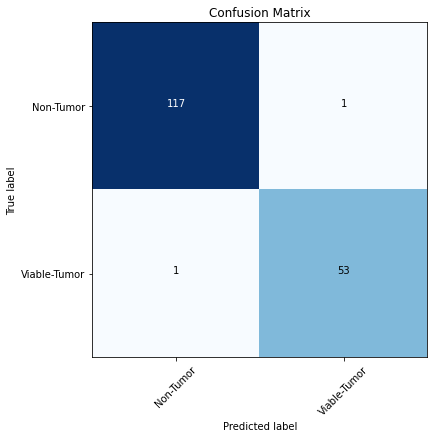

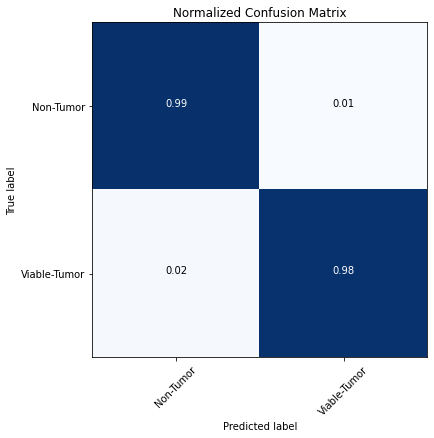

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### TBA 500

In [ ]:
# univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=500)
selector.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_uv = selector.transform(X_train_b3)

# getting transformed test features
X_test_uv = selector.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)m
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 500)
After applying Mututal information gain, shape for test data:  (172, 500)
k-fold validation accuracy for k=5 is:  0.962
Accuracy on test data is:  0.988
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.973


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       118
           2       0.98      0.98      0.98        54

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.992     	      0.992      	   0.981   
  1       0.981     	      0.981      	   0.992   





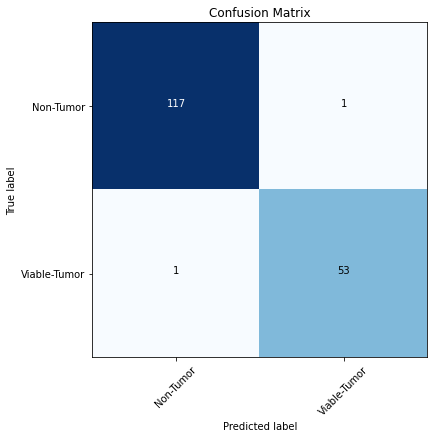

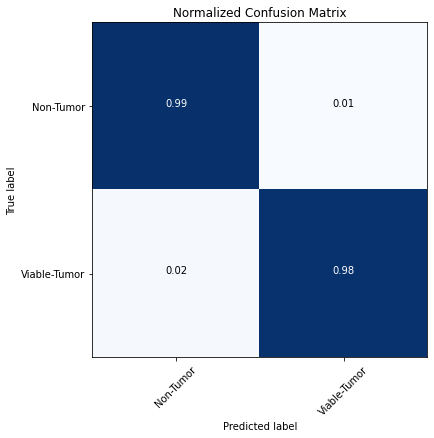

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### TBA 600

In [ ]:
# univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=600)
selector.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_uv = selector.transform(X_train_b3)

# getting transformed test features
X_test_uv = selector.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)m
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 600)
After applying Mututal information gain, shape for test data:  (172, 600)
k-fold validation accuracy for k=5 is:  0.968
Accuracy on test data is:  0.983
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.96


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       118
           2       0.96      0.98      0.97        54

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.983      	   0.981   
  1       0.964     	      0.981      	   0.983   





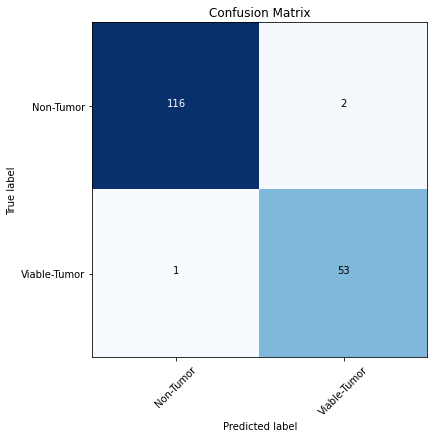

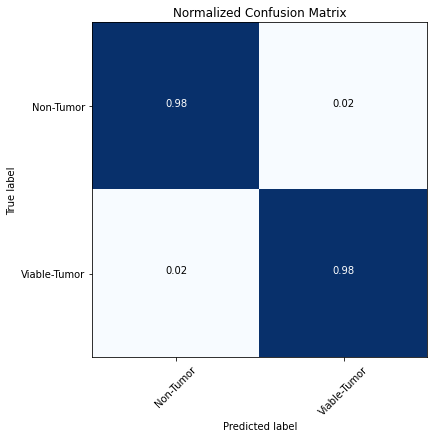

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### TBA 700

In [ ]:
# univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=700)
selector.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_uv = selector.transform(X_train_b3)

# getting transformed test features
X_test_uv = selector.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)m
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 700)
After applying Mututal information gain, shape for test data:  (172, 700)
k-fold validation accuracy for k=5 is:  0.961
Accuracy on test data is:  0.994
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.987


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       118
           2       0.98      1.00      0.99        54

    accuracy                           0.99       172
   macro avg       0.99      1.00      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.992      	    1.0    
  1       0.982     	       1.0       	   0.992   





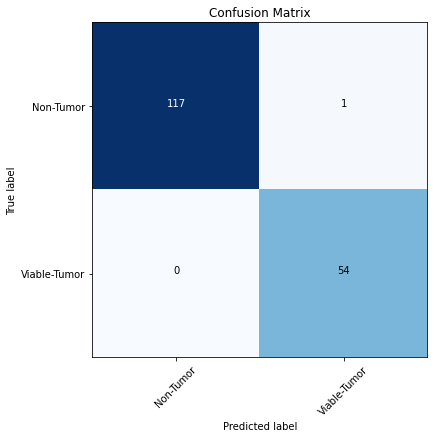

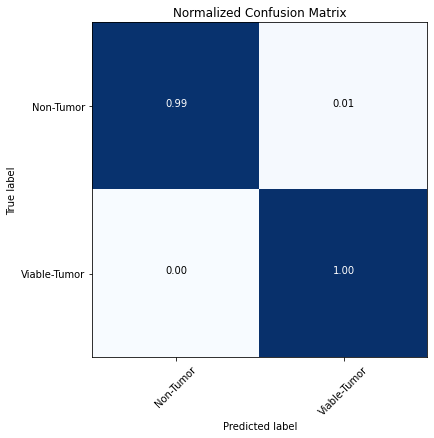

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### TBA 800

In [ ]:
# univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=800)
selector.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_uv = selector.transform(X_train_b3)

# getting transformed test features
X_test_uv = selector.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)m
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 800)
After applying Mututal information gain, shape for test data:  (172, 800)
k-fold validation accuracy for k=5 is:  0.966
Accuracy on test data is:  0.988
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.974


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       118
           2       0.96      1.00      0.98        54

    accuracy                           0.99       172
   macro avg       0.98      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        1.0      	      0.983      	    1.0    
  1       0.964     	       1.0       	   0.983   





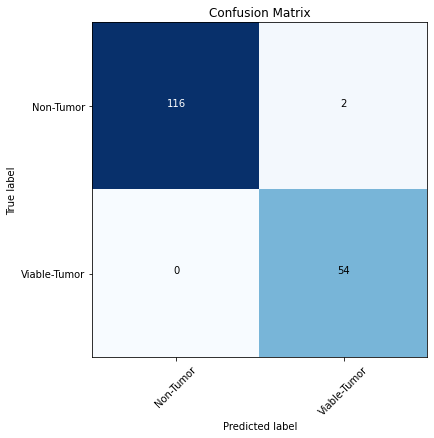

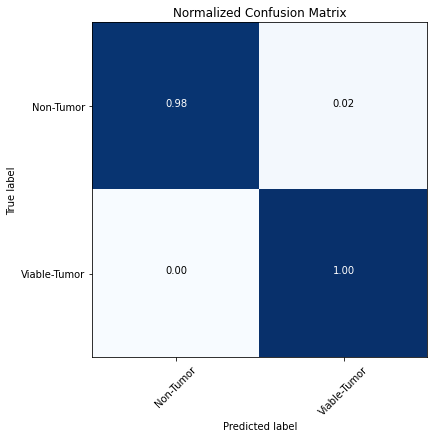

In [ ]:
classes = ['Non-Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b3, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b3, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b3, mlp_p)

#### TBA 900

In [ ]:
# univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=900)
selector.fit(X_train_b3, train_y_b3)

# getting transformed train features
X_train_uv = selector.transform(X_train_b3)

# getting transformed test features
X_test_uv = selector.transform(X_test_b3)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)m
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (710, 900)
After applying Mututal information gain, shape for test data:  (172, 900)
k-fold validation accuracy for k=5 is:  0.963
Accuracy on test data is:  0.988
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.973


## Non-viable tumor VS Viable tumor

In [ ]:
# total train smaples 497

### Using PCA 

Text(0, 0.5, 'Cum variance')

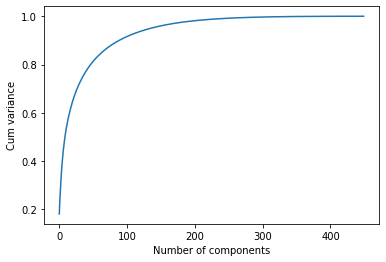

In [ ]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components= 450)  # n_components must be between: min(n_samples, n_features)
pca_test.fit(X_train_b4)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

#### PCA 100

In [ ]:
pca = PCA(n_components= 100)

X_train_pca = pca.fit_transform(X_train_b4)
X_test_pca = pca.transform(X_test_b4)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b4.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b4.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b4, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (497, 1024) 	after PCA-  (497, 100)
Test features shape:	before PCA-  (110, 1024) 	after PCA-  (110, 100)
k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.945
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





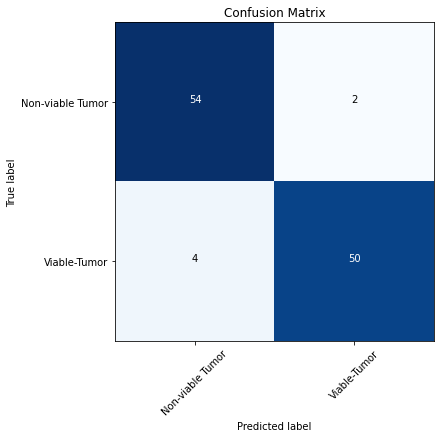

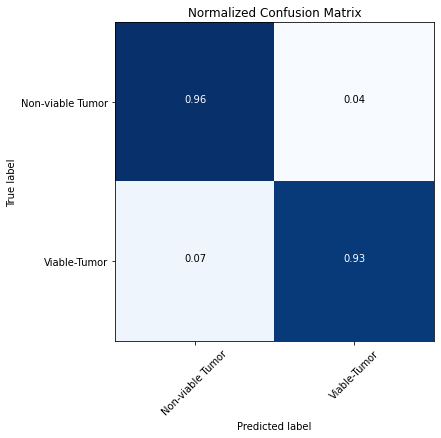

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_pred)

#### PCA 200

In [ ]:
pca = PCA(n_components= 200)

X_train_pca = pca.fit_transform(X_train_b4)
X_test_pca = pca.transform(X_test_b4)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b4.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b4.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b4, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (497, 1024) 	after PCA-  (497, 200)
Test features shape:	before PCA-  (110, 1024) 	after PCA-  (110, 200)
k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.918
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.837


              precision    recall  f1-score   support

           1       0.90      0.95      0.92        56
           2       0.94      0.89      0.91        54

    accuracy                           0.92       110
   macro avg       0.92      0.92      0.92       110
weighted avg       0.92      0.92      0.92       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.898     	      0.946      	   0.889   
  1       0.941     	      0.889      	   0.946   





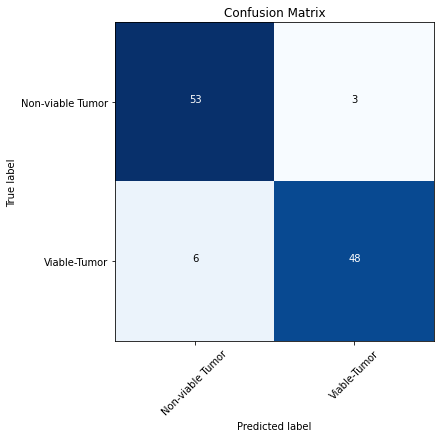

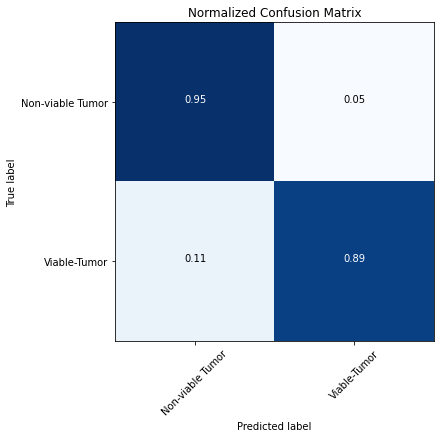

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_pred)

#### PCA 300

In [ ]:
pca = PCA(n_components= 300)

X_train_pca = pca.fit_transform(X_train_b4)
X_test_pca = pca.transform(X_test_b4)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b4.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b4.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b4, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (497, 1024) 	after PCA-  (497, 300)
Test features shape:	before PCA-  (110, 1024) 	after PCA-  (110, 300)
k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.927
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.854


              precision    recall  f1-score   support

           1       0.93      0.93      0.93        56
           2       0.93      0.93      0.93        54

    accuracy                           0.93       110
   macro avg       0.93      0.93      0.93       110
weighted avg       0.93      0.93      0.93       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.929     	      0.929      	   0.926   
  1       0.926     	      0.926      	   0.929   





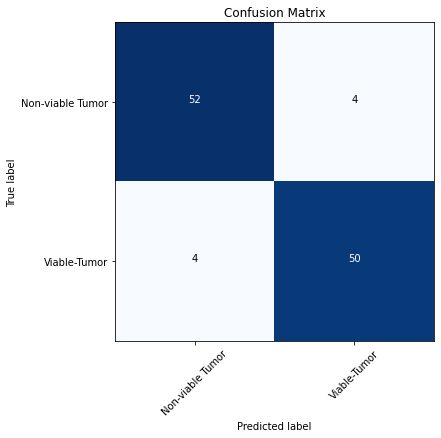

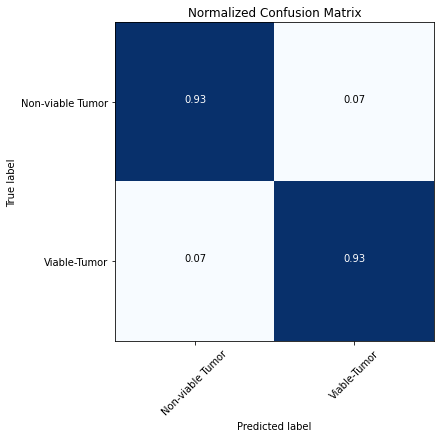

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_pred)

#### PCA 400

In [ ]:
pca = PCA(n_components= 400)

X_train_pca = pca.fit_transform(X_train_b4)
X_test_pca = pca.transform(X_test_b4)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b4.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b4.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b4, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (497, 1024) 	after PCA-  (497, 400)
Test features shape:	before PCA-  (110, 1024) 	after PCA-  (110, 400)
k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.955
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.909


              precision    recall  f1-score   support

           1       0.95      0.96      0.96        56
           2       0.96      0.94      0.95        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.947     	      0.964      	   0.944   
  1       0.962     	      0.944      	   0.964   





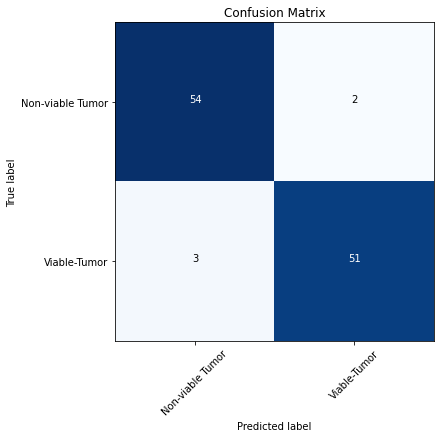

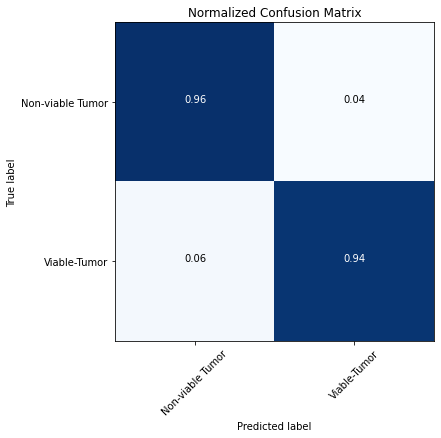

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_pred)

#### PCA 0.9

In [ ]:
pca = PCA(0.9)

X_train_pca = pca.fit_transform(X_train_b4)
X_test_pca = pca.transform(X_test_b4)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b4.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b4.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b4, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (497, 1024) 	after PCA-  (497, 90)
Test features shape:	before PCA-  (110, 1024) 	after PCA-  (110, 90)
k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.936
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.873


              precision    recall  f1-score   support

           1       0.93      0.95      0.94        56
           2       0.94      0.93      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.93     	      0.946      	   0.926   
  1       0.943     	      0.926      	   0.946   





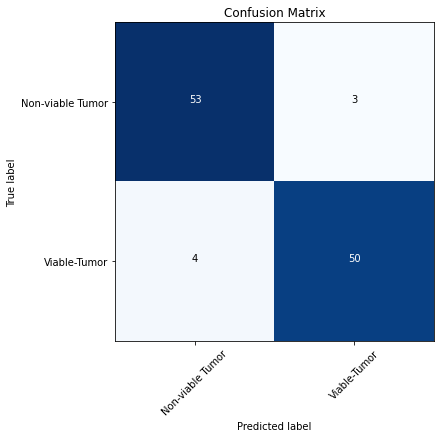

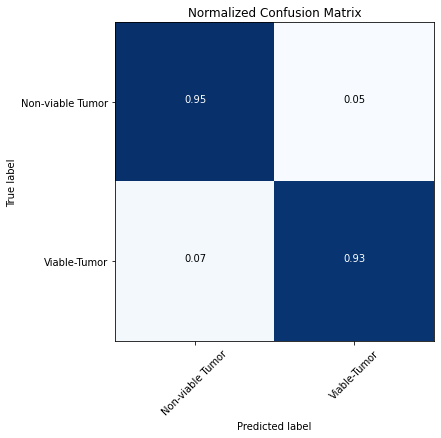

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_pred)

#### PCA 0.85

In [ ]:
pca = PCA(0.85)

X_train_pca = pca.fit_transform(X_train_b4)
X_test_pca = pca.transform(X_test_b4)

# checking shape of train and test features after implementing PCA
print("Train features shape:\tbefore PCA- ", X_train_b4.shape, "\tafter PCA- ", X_train_pca.shape)
print("Test features shape:\tbefore PCA- ", X_test_b4.shape, "\tafter PCA- ", X_test_pca.shape)

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_pca, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b4, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_pca)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_pca)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Train features shape:	before PCA-  (497, 1024) 	after PCA-  (497, 64)
Test features shape:	before PCA-  (110, 1024) 	after PCA-  (110, 64)
k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.955
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.91


              precision    recall  f1-score   support

           1       0.93      0.98      0.96        56
           2       0.98      0.93      0.95        54

    accuracy                           0.95       110
   macro avg       0.96      0.95      0.95       110
weighted avg       0.96      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.932     	      0.982      	   0.926   
  1        0.98     	      0.926      	   0.982   





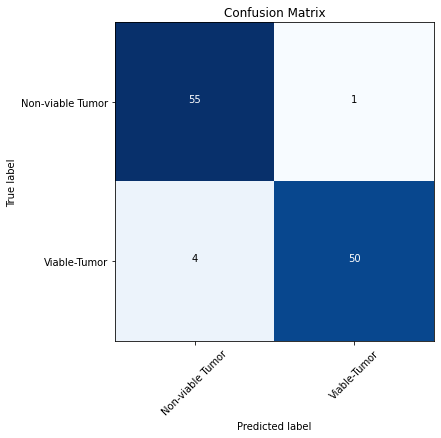

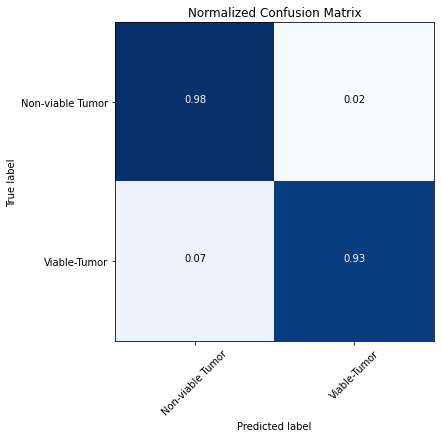

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_pred)

### Using MIG

#### MIG 100

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=100)

# fit to selector
X_train_ig = select.fit_transform(X_train_b4, train_y_b4)
X_test_ig = select.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 100)
After applying Mututal information gain, shape for test data:  (110, 100)
k-fold validation accuracy for k=5 is:  0.95
Accuracy on test data is:  0.936
ROC-AUC score is:  0.974
The Matthews correlation coefficinet (MCC) is:  0.873


              precision    recall  f1-score   support

           1       0.93      0.95      0.94        56
           2       0.94      0.93      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.93     	      0.946      	   0.926   
  1       0.943     	      0.926      	   0.946   





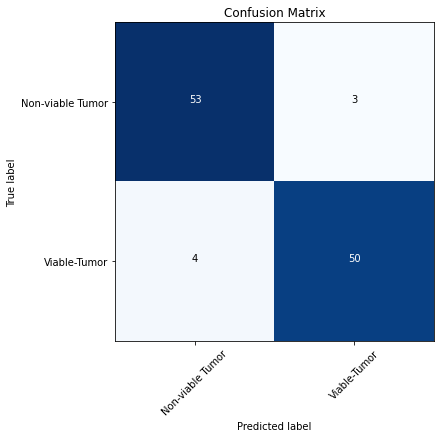

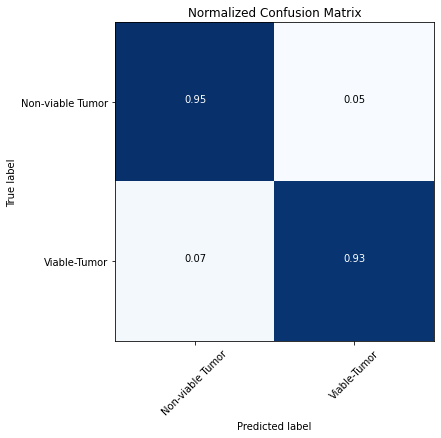

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### MIG 200

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=200)

# fit to selector
X_train_ig = select.fit_transform(X_train_b4, train_y_b4)
X_test_ig = select.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 200)
After applying Mututal information gain, shape for test data:  (110, 200)
k-fold validation accuracy for k=5 is:  0.95
Accuracy on test data is:  0.936
ROC-AUC score is:  0.973
The Matthews correlation coefficinet (MCC) is:  0.874


              precision    recall  f1-score   support

           1       0.92      0.96      0.94        56
           2       0.96      0.91      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.915     	      0.964      	   0.907   
  1       0.961     	      0.907      	   0.964   





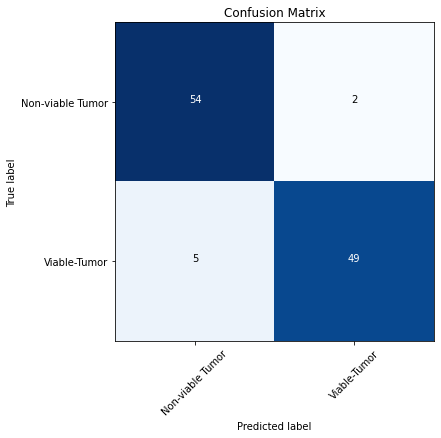

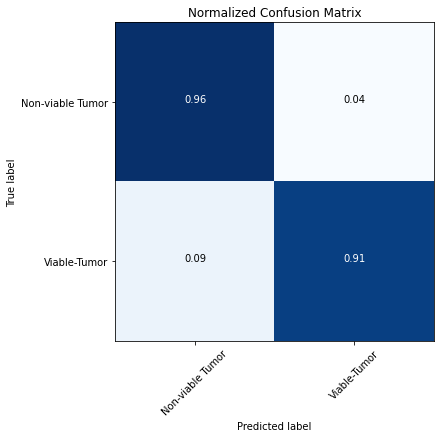

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### MIG 300

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=300)

# fit to selector
X_train_ig = select.fit_transform(X_train_b4, train_y_b4)
X_test_ig = select.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 300)
After applying Mututal information gain, shape for test data:  (110, 300)
k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.945
ROC-AUC score is:  0.976
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





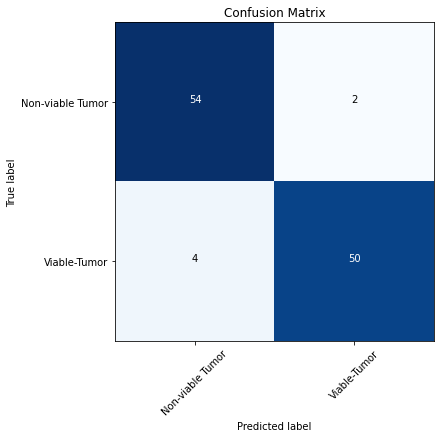

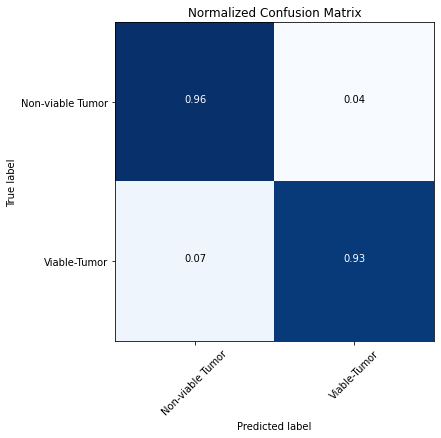

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### MIG 400

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=400)

# fit to selector
X_train_ig = select.fit_transform(X_train_b4, train_y_b4)
X_test_ig = select.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 400)
After applying Mututal information gain, shape for test data:  (110, 400)
k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.936
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.873


              precision    recall  f1-score   support

           1       0.93      0.95      0.94        56
           2       0.94      0.93      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.93     	      0.946      	   0.926   
  1       0.943     	      0.926      	   0.946   





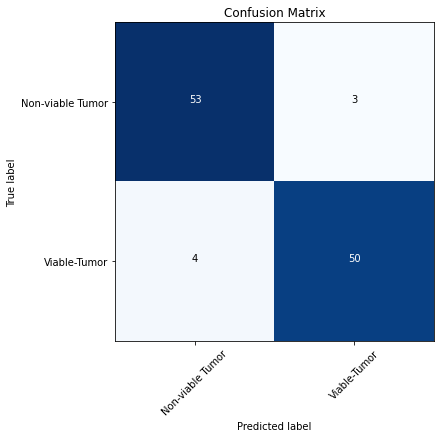

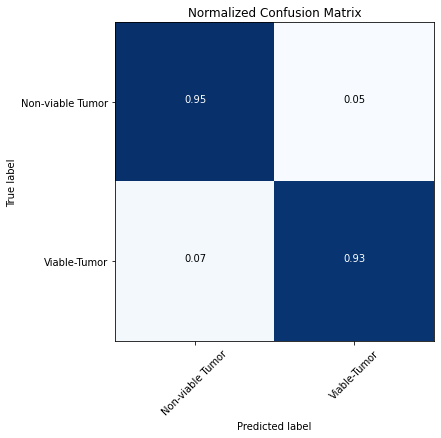

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### MIG 500

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=500)

# fit to selector
X_train_ig = select.fit_transform(X_train_b4, train_y_b4)
X_test_ig = select.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 500)
After applying Mututal information gain, shape for test data:  (110, 500)
k-fold validation accuracy for k=5 is:  0.95
Accuracy on test data is:  0.945
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





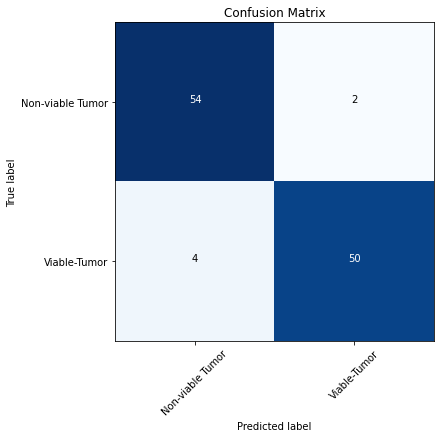

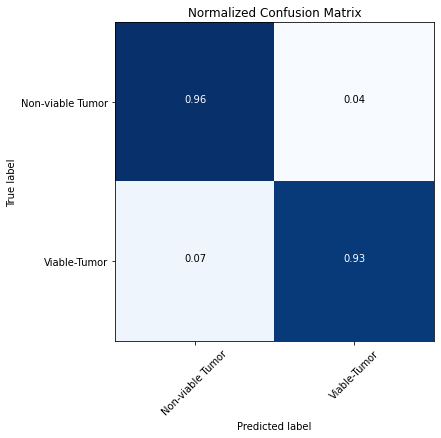

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### MIG 600

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=600)

# fit to selector
X_train_ig = select.fit_transform(X_train_b4, train_y_b4)
X_test_ig = select.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 600)
After applying Mututal information gain, shape for test data:  (110, 600)
k-fold validation accuracy for k=5 is:  0.95
Accuracy on test data is:  0.936
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.874


              precision    recall  f1-score   support

           1       0.92      0.96      0.94        56
           2       0.96      0.91      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.915     	      0.964      	   0.907   
  1       0.961     	      0.907      	   0.964   





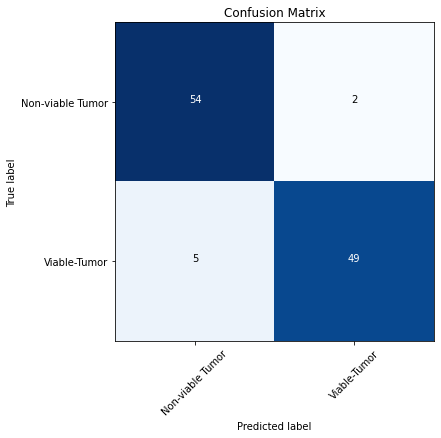

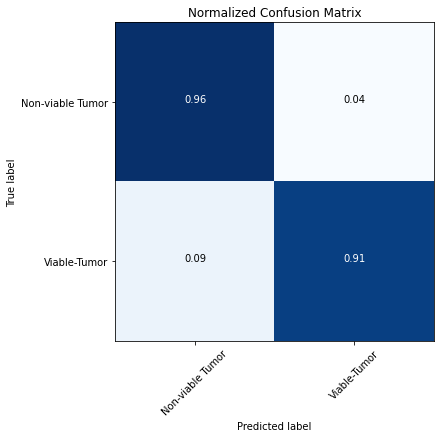

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### MIG 700

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=700)

# fit to selector
X_train_ig = select.fit_transform(X_train_b4, train_y_b4)
X_test_ig = select.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 700)
After applying Mututal information gain, shape for test data:  (110, 700)
k-fold validation accuracy for k=5 is:  0.948
Accuracy on test data is:  0.945
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





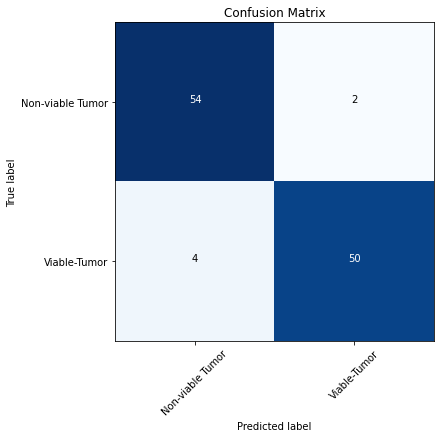

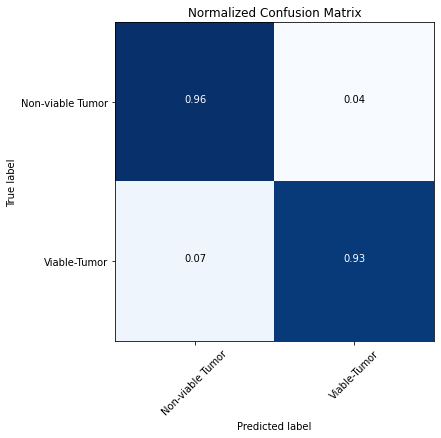

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### MIG 800

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=800)

# fit to selector
X_train_ig = select.fit_transform(X_train_b4, train_y_b4)
X_test_ig = select.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 800)
After applying Mututal information gain, shape for test data:  (110, 800)
k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.945
ROC-AUC score is:  0.981
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





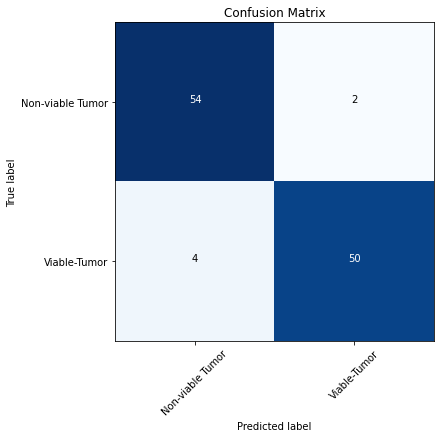

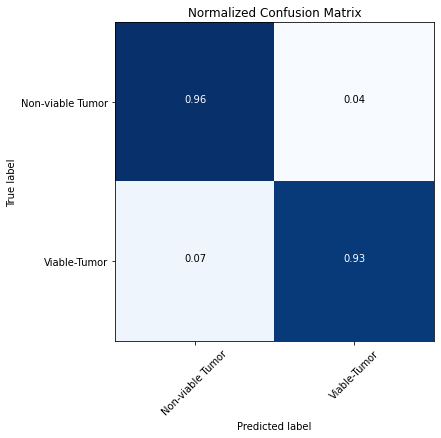

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### MIG 900

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectKBest

# selecting best features
select = SelectKBest(mutual_info_classif, k=900)

# fit to selector
X_train_ig = select.fit_transform(X_train_b4, train_y_b4)
X_test_ig = select.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_ig.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_ig.shape)

# defining MLP classifier
mlp_ig = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_ig.fit(X_train_ig, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_ig, X_train_ig, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_ig.predict(X_test_ig)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_ig.predict_proba(X_test_ig)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 900)
After applying Mututal information gain, shape for test data:  (110, 900)
k-fold validation accuracy for k=5 is:  0.948
Accuracy on test data is:  0.936
ROC-AUC score is:  0.98
The Matthews correlation coefficinet (MCC) is:  0.873


              precision    recall  f1-score   support

           1       0.93      0.95      0.94        56
           2       0.94      0.93      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.93     	      0.946      	   0.926   
  1       0.943     	      0.926      	   0.946   





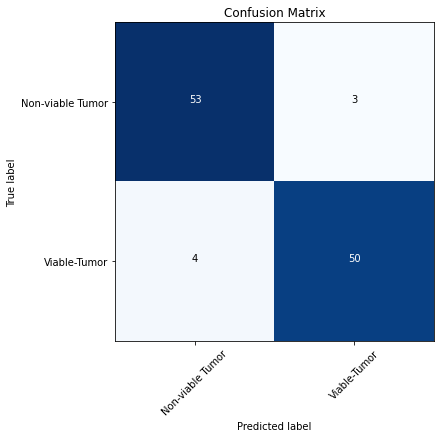

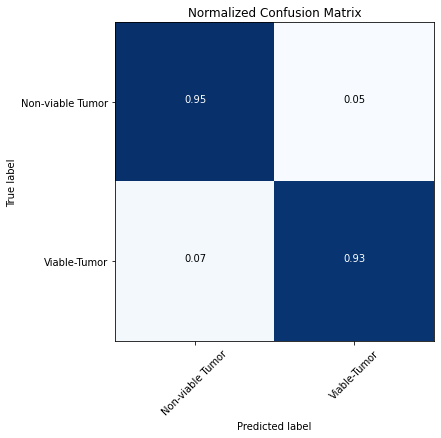

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

### Using RFE 

#### RFE 100

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=100)

# fit our train data into RFE 
rfe.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b4)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 100)
After applying Mututal information gain, shape for test data:  (110, 100)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.927
ROC-AUC score is:  0.976
The Matthews correlation coefficinet (MCC) is:  0.855


              precision    recall  f1-score   support

           1       0.91      0.95      0.93        56
           2       0.94      0.91      0.92        54

    accuracy                           0.93       110
   macro avg       0.93      0.93      0.93       110
weighted avg       0.93      0.93      0.93       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.914     	      0.946      	   0.907   
  1       0.942     	      0.907      	   0.946   





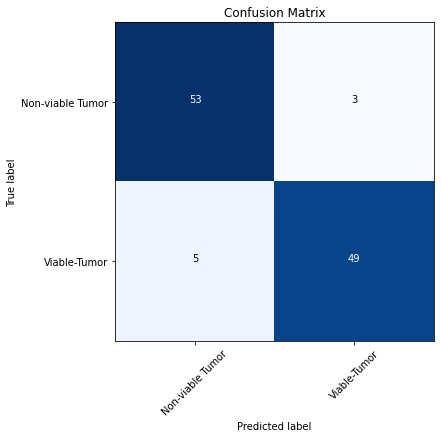

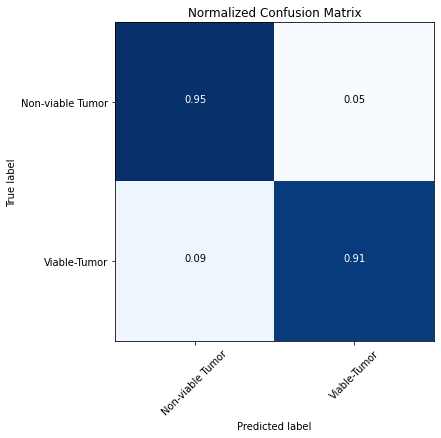

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### RFE 200

After applying mutual information gain, shape for train data:  (497, 200)
After applying Mututal information gain, shape for test data:  (110, 200)
k-fold validation accuracy for k=5 is:  0.95
Accuracy on test data is:  0.945
ROC-AUC score is:  0.98
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





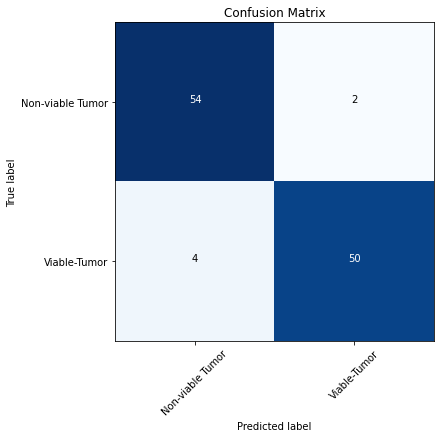

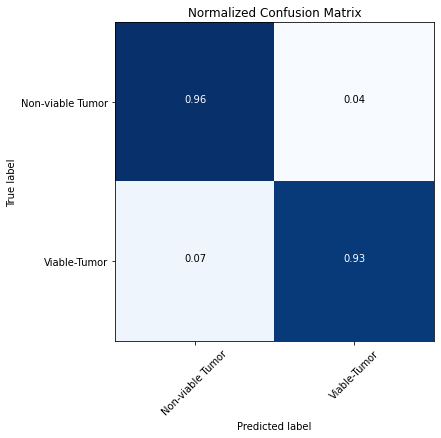

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=200)

# fit our train data into RFE 
rfe.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b4)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("===============================================================")
print("===============================================================\n\n")

classes = ['Non-viable Tumor', 'Viable-Tumor']
# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### RFE 300

After applying mutual information gain, shape for train data:  (497, 300)
After applying Mututal information gain, shape for test data:  (110, 300)
k-fold validation accuracy for k=5 is:  0.948
Accuracy on test data is:  0.955
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.909


              precision    recall  f1-score   support

           1       0.95      0.96      0.96        56
           2       0.96      0.94      0.95        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.947     	      0.964      	   0.944   
  1       0.962     	      0.944      	   0.964   





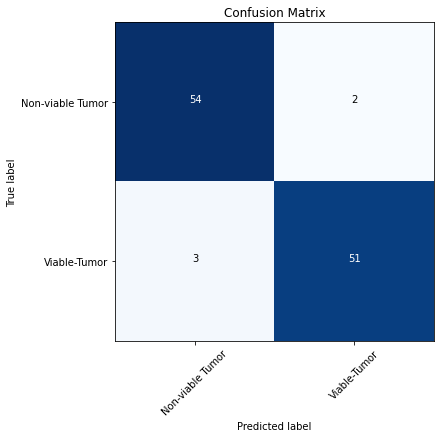

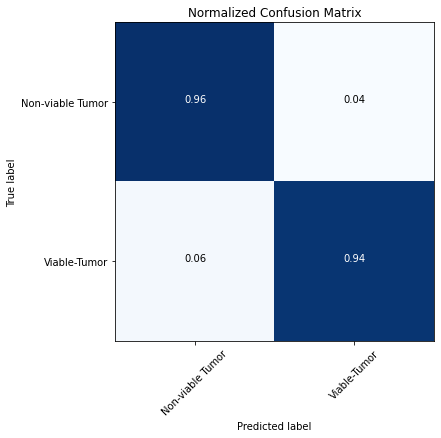

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=300)

# fit our train data into RFE 
rfe.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b4)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("===============================================================")
print("===============================================================\n\n")

classes = ['Non-viable Tumor', 'Viable-Tumor']
# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### RFE 400

After applying mutual information gain, shape for train data:  (497, 400)
After applying Mututal information gain, shape for test data:  (110, 400)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.945
ROC-AUC score is:  0.975
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.95      0.95      0.95        56
           2       0.94      0.94      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.946     	      0.946      	   0.944   
  1       0.944     	      0.944      	   0.946   





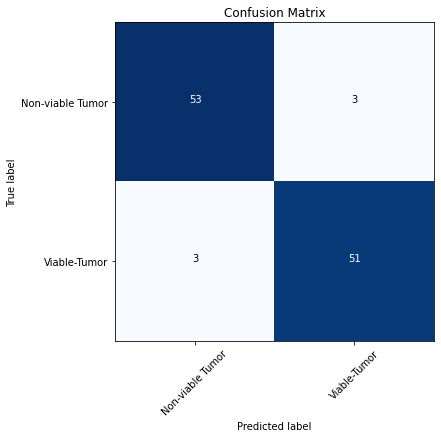

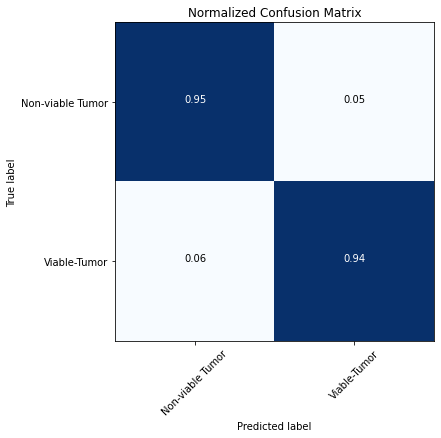

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=400)

# fit our train data into RFE 
rfe.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b4)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("===============================================================")
print("===============================================================\n\n")

classes = ['Non-viable Tumor', 'Viable-Tumor']
# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### RFE 500

After applying mutual information gain, shape for train data:  (497, 500)
After applying Mututal information gain, shape for test data:  (110, 500)
k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.945
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.95      0.95      0.95        56
           2       0.94      0.94      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.946     	      0.946      	   0.944   
  1       0.944     	      0.944      	   0.946   





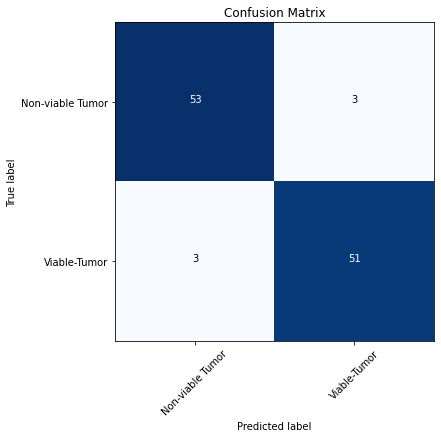

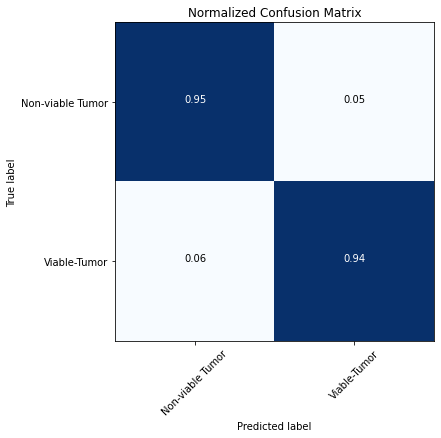

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=500)

# fit our train data into RFE 
rfe.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b4)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("===============================================================")
print("===============================================================\n\n")

classes = ['Non-viable Tumor', 'Viable-Tumor']
# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### RFE 600

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=600)

# fit our train data into RFE 
rfe.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b4)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("===============================================================")
print("===============================================================\n\n")

classes = ['Non-viable Tumor', 'Viable-Tumor']
# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### RFE 700

After applying mutual information gain, shape for train data:  (497, 700)
After applying Mututal information gain, shape for test data:  (110, 700)
k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.945
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





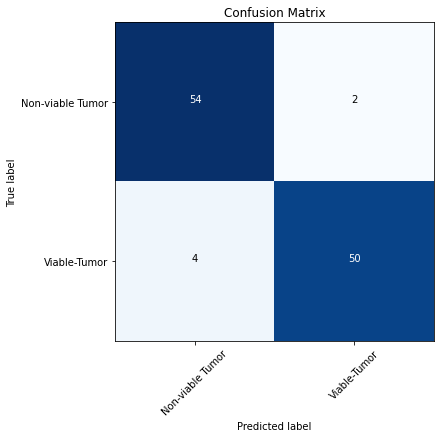

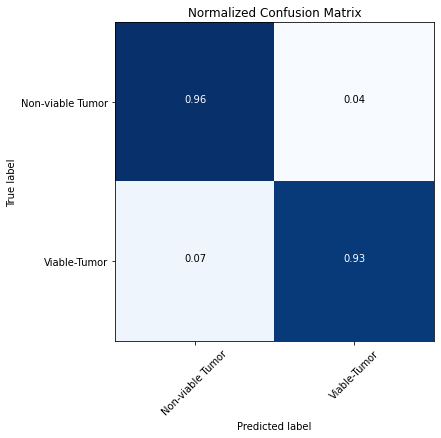

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=700)

# fit our train data into RFE 
rfe.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b4)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("===============================================================")
print("===============================================================\n\n")

classes = ['Non-viable Tumor', 'Viable-Tumor']
# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### RFE 800

After applying mutual information gain, shape for train data:  (497, 800)
After applying Mututal information gain, shape for test data:  (110, 800)
k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.945
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.891


              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





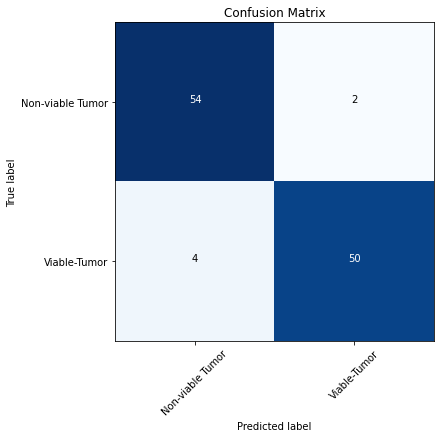

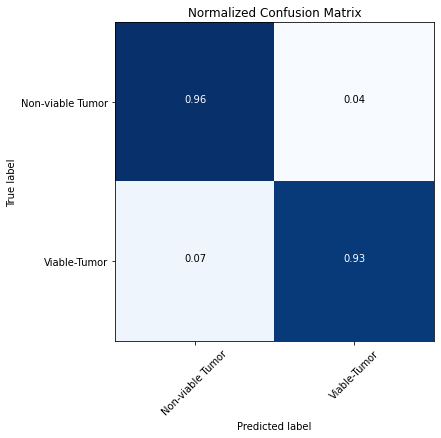

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=800)

# fit our train data into RFE 
rfe.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b4)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("===============================================================")
print("===============================================================\n\n")

classes = ['Non-viable Tumor', 'Viable-Tumor']
# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### RFE 900

After applying mutual information gain, shape for train data:  (497, 900)
After applying Mututal information gain, shape for test data:  (110, 900)
k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.936
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.874


              precision    recall  f1-score   support

           1       0.92      0.96      0.94        56
           2       0.96      0.91      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.915     	      0.964      	   0.907   
  1       0.961     	      0.907      	   0.964   





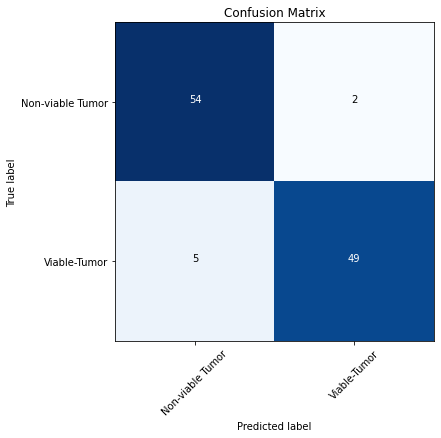

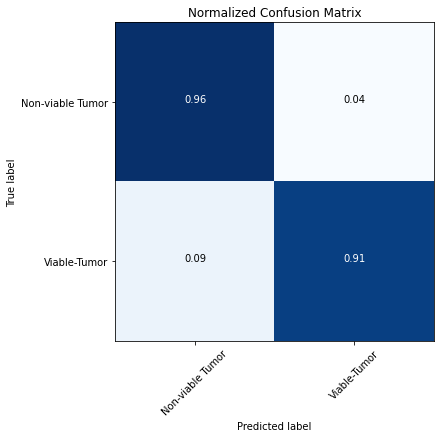

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=900)

# fit our train data into RFE 
rfe.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_rfe = rfe.transform(X_train_b4)

# getting transformed test features
X_test_rfe = rfe.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("===============================================================")
print("===============================================================\n\n")

classes = ['Non-viable Tumor', 'Viable-Tumor']
# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

### Univariat

#### 100

In [ ]:
# Univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=100)
selector.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_uv = selector.transform(X_train_b4)

# getting transformed test features
X_test_uv = selector.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

After applying mutual information gain, shape for train data:  (497, 100)
After applying Mututal information gain, shape for test data:  (110, 100)
k-fold validation accuracy for k=5 is:  0.958
Accuracy on test data is:  0.936
ROC-AUC score is:  0.969
The Matthews correlation coefficinet (MCC) is:  0.873


              precision    recall  f1-score   support

           1       0.93      0.95      0.94        56
           2       0.94      0.93      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.93     	      0.946      	   0.926   
  1       0.943     	      0.926      	   0.946   





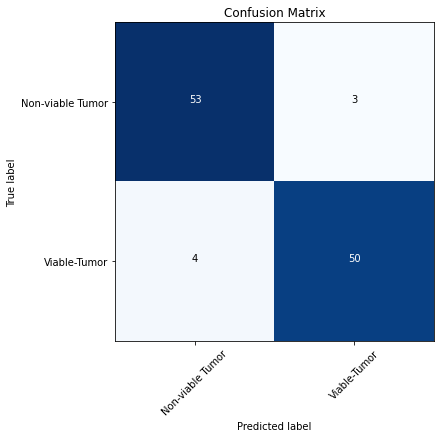

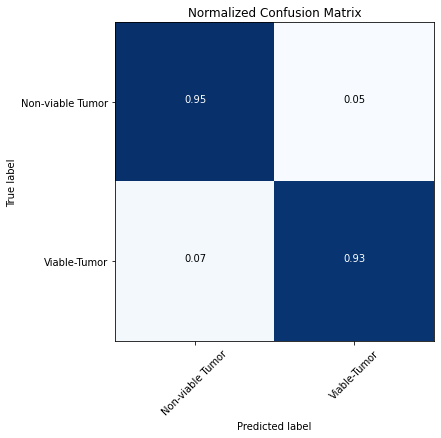

In [ ]:
classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### 200

After applying mutual information gain, shape for train data:  (497, 200)
After applying Mututal information gain, shape for test data:  (110, 200)
k-fold validation accuracy for k=5 is:  0.96
Accuracy on test data is:  0.927
ROC-AUC score is:  0.975
The Matthews correlation coefficinet (MCC) is:  0.855
              precision    recall  f1-score   support

           1       0.91      0.95      0.93        56
           2       0.94      0.91      0.92        54

    accuracy                           0.93       110
   macro avg       0.93      0.93      0.93       110
weighted avg       0.93      0.93      0.93       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.914     	      0.946      	   0.907   
  1       0.942     	      0.907      	   0.946   





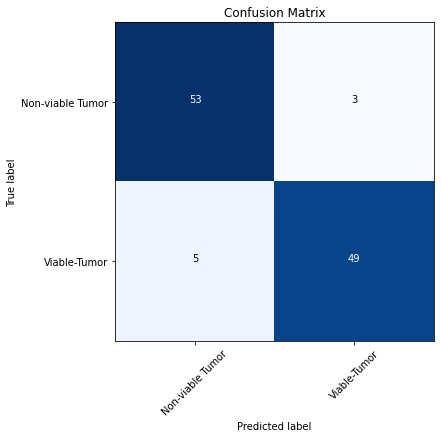

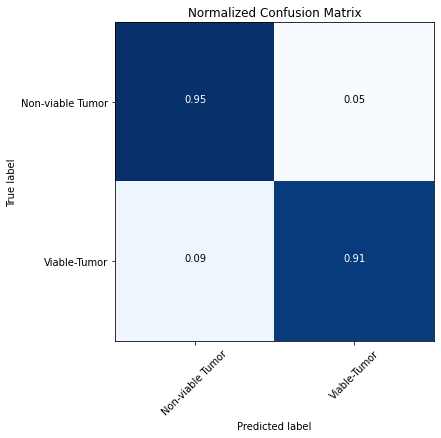

In [ ]:
# Univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=200)
selector.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_uv = selector.transform(X_train_b4)

# getting transformed test features
X_test_uv = selector.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("=================================================================================")
print("=================================================================================")

classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### 300

After applying mutual information gain, shape for train data:  (497, 300)
After applying Mututal information gain, shape for test data:  (110, 300)
k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.945
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.891
              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





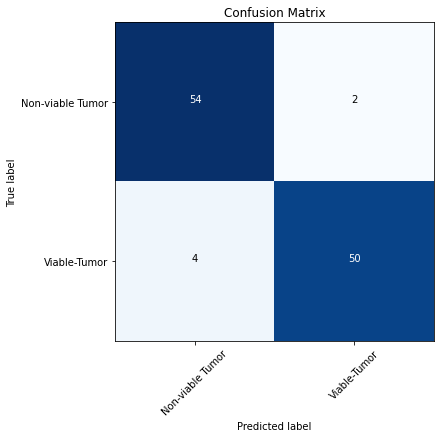

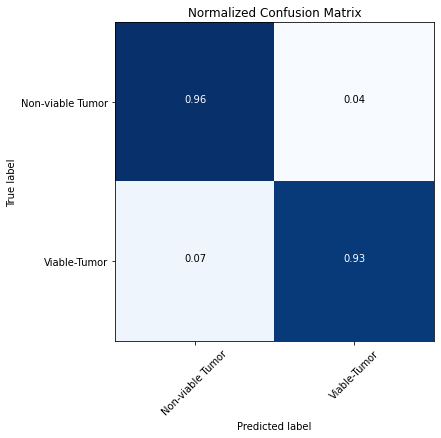

In [ ]:
 # Univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=300)
selector.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_uv = selector.transform(X_train_b4)

# getting transformed test features
X_test_uv = selector.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("=================================================================================")
print("=================================================================================")

classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### 400

After applying mutual information gain, shape for train data:  (497, 400)
After applying Mututal information gain, shape for test data:  (110, 400)
k-fold validation accuracy for k=5 is:  0.96
Accuracy on test data is:  0.955
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.909
              precision    recall  f1-score   support

           1       0.95      0.96      0.96        56
           2       0.96      0.94      0.95        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.947     	      0.964      	   0.944   
  1       0.962     	      0.944      	   0.964   





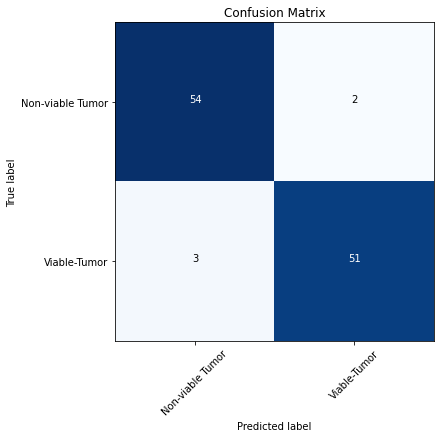

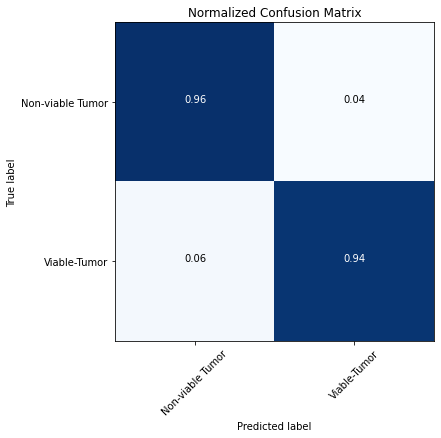

In [ ]:
# Univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=400)
selector.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_uv = selector.transform(X_train_b4)

# getting transformed test features
X_test_uv = selector.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("=================================================================================")
print("=================================================================================")

classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### 500

After applying mutual information gain, shape for train data:  (497, 500)
After applying Mututal information gain, shape for test data:  (110, 500)
k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.945
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.891
              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





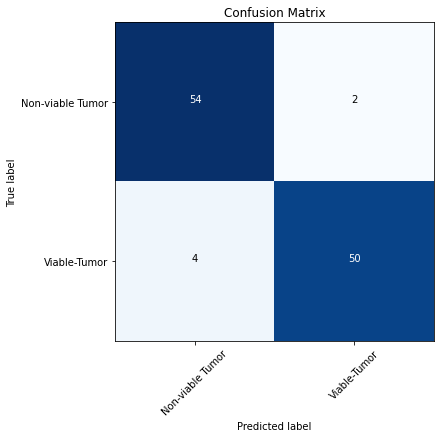

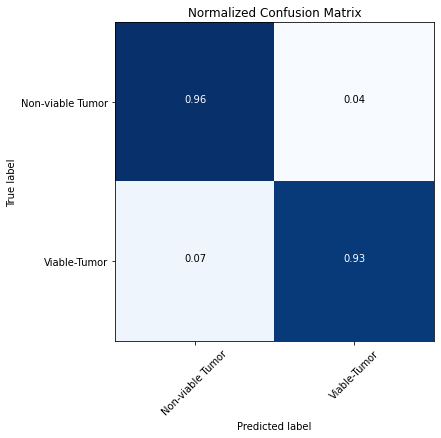

In [ ]:
# Univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=500)
selector.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_uv = selector.transform(X_train_b4)

# getting transformed test features
X_test_uv = selector.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("=================================================================================")
print("=================================================================================")

classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### 600

After applying mutual information gain, shape for train data:  (497, 600)
After applying Mututal information gain, shape for test data:  (110, 600)
k-fold validation accuracy for k=5 is:  0.95
Accuracy on test data is:  0.945
ROC-AUC score is:  0.976
The Matthews correlation coefficinet (MCC) is:  0.891
              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





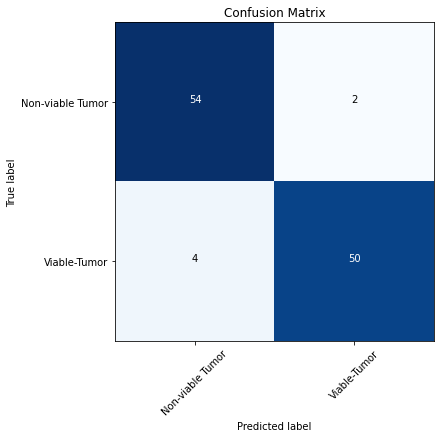

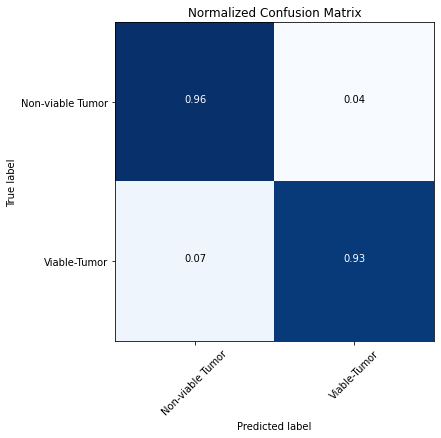

In [ ]:
# Univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=600)
selector.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_uv = selector.transform(X_train_b4)

# getting transformed test features
X_test_uv = selector.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("=================================================================================")
print("=================================================================================")

classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### 700

After applying mutual information gain, shape for train data:  (497, 700)
After applying Mututal information gain, shape for test data:  (110, 700)
k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.945
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.891
              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





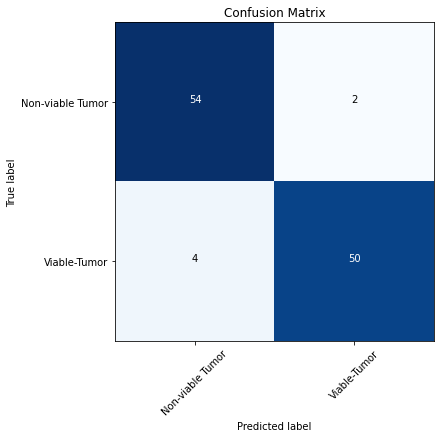

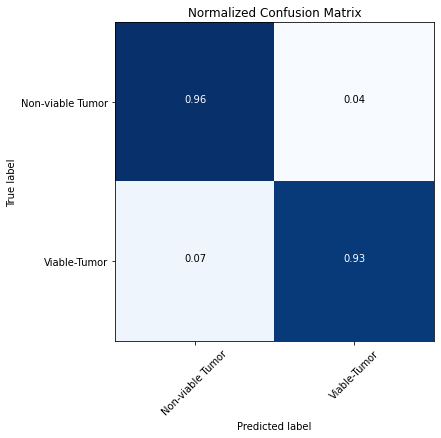

In [ ]:
# Univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=700)
selector.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_uv = selector.transform(X_train_b4)

# getting transformed test features
X_test_uv = selector.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("=================================================================================")
print("=================================================================================")

classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### 800

After applying mutual information gain, shape for train data:  (497, 800)
After applying Mututal information gain, shape for test data:  (110, 800)
k-fold validation accuracy for k=5 is:  0.948
Accuracy on test data is:  0.936
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.874
              precision    recall  f1-score   support

           1       0.92      0.96      0.94        56
           2       0.96      0.91      0.93        54

    accuracy                           0.94       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.94      0.94      0.94       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.915     	      0.964      	   0.907   
  1       0.961     	      0.907      	   0.964   





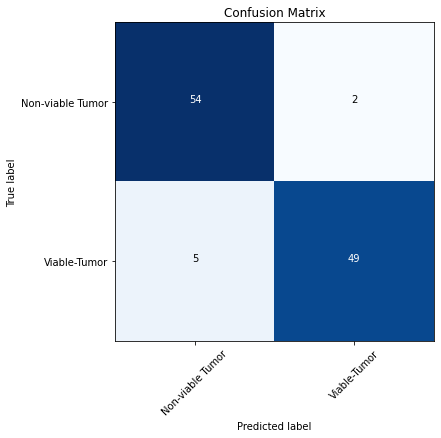

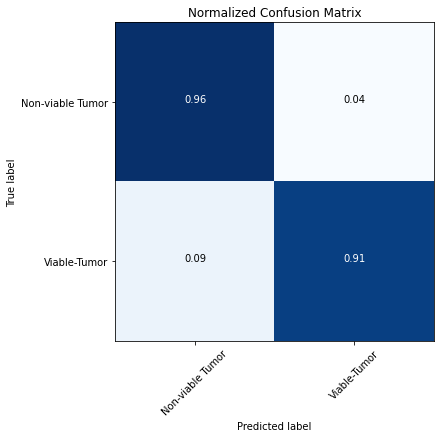

In [ ]:
# Univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=800)
selector.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_uv = selector.transform(X_train_b4)

# getting transformed test features
X_test_uv = selector.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("=================================================================================")
print("=================================================================================")

classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)

#### 900

After applying mutual information gain, shape for train data:  (497, 900)
After applying Mututal information gain, shape for test data:  (110, 900)
k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.945
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.891
              precision    recall  f1-score   support

           1       0.93      0.96      0.95        56
           2       0.96      0.93      0.94        54

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.931     	      0.964      	   0.926   
  1       0.962     	      0.926      	   0.964   





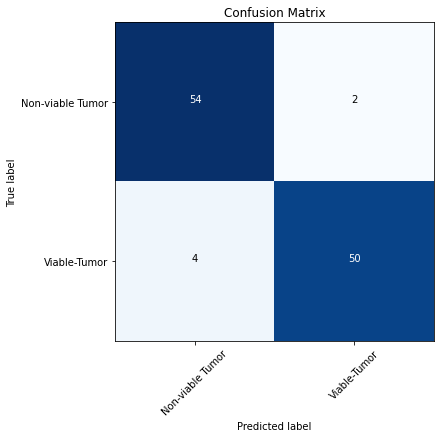

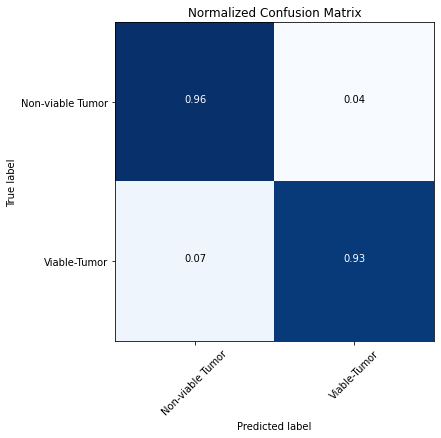

In [ ]:
# Univariat feature selection 
from sklearn.feature_selection import SelectKBest, f_classif

# taking certain number of features for feature selection 
selector = SelectKBest(f_classif, k=900)
selector.fit(X_train_b4, train_y_b4)

# getting transformed train features
X_train_uv = selector.transform(X_train_b4)

# getting transformed test features
X_test_uv = selector.transform(X_test_b4)

print("After applying mutual information gain, shape for train data: ", X_train_uv.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_uv.shape)

# defining MLP classifier 
mlp_uv = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_uv.fit(X_train_uv, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_uv, X_train_uv, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_uv.predict(X_test_uv)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_probs = mlp_uv.predict_proba(X_test_uv)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

print("=================================================================================")
print("=================================================================================")

classes = ['Non-viable Tumor', 'Viable-Tumor']

# getting classsification reports
get_reports(test_y_b4, mlp_p)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b4, mlp_p)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b4, mlp_p)